# Projet 10 : Détecter des faux billets avec python
-------
## Introduction 

### Contexte

En tant que Data Analyst dans une entreprise spécialisé dans la data, en prestation au sein de l'Organisation nationale de lutte contre le faux-monnayage.

### Mission:

- Mettre en place des méthodes d'identification des contrefacons de billets en euros.
- A partir de certains informations relatives ax billets, mettre en place un modélisation capable d'identifier automatiquement les vrais des faux billets.

### Compétences requises:

- Utiliser une regression linéaire afin de combler les valeurs manquantes présentent dans le jeu de données.
- Utiliser des algorithmes d'apprentissages supervisées et non-supervisés afin de predire si un billet est vrai ou faux.
- Savoir valider un modèle de prédiction.

-------


### Plan

Voici les points qui seront vu pendant ce notebook:
- Importations des librairies et importation des données.
- Exploration des données et nettoyage
    - Analyse exploratoire des données (**AED**)
        - Analyse univariée et multivariée
        - Analyse des données atypiques
        - Relations entre les variables
    - Traitement des valeurs manquantes
        - Modélisation avec **régression linéaire**
        - Validation du modèle linéaire
        - Imputation des données
    - Analyse des composants principaux (**ACP** ou PCA)
        - Relations entre les variables
        - Repartition des individus (projection sur les axes d'inertie)
- Mise en place de modèles de prediction des faux billets
    - Algorithme **K-means**
    - **K-nn ( k Nearest Neighbors)**
    - **Regression logistique**
    - Choix et application d'un modèle
- Conclusion
- Utilisation du modèle (test soutenance)
-------

### Importations des librairies 

In [681]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.gofplots as sm
import statsmodels.formula.api as smf

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, precision_score, recall_score, mean_squared_error
from sklearn.metrics import accuracy_score,silhouette_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from statsmodels.genmod import families
from statsmodels.stats.api import linear_rainbow
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white

from gap_statistic import OptimalK
from scipy import stats
from scipy.stats import t
from matplotlib.collections import LineCollection

# 提高 jupyter notebook圖形顯示解析度
%config InlineBackend.figure_format = 'retina'

### Importation des données.

In [682]:
df_billets = pd.read_csv('billets.csv',sep = ';')
df_billets1 = df_billets.copy()
df_billets1.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

## Exploration des données et nettoyage

In [683]:
df_billets1.shape

(1500, 7)

Il y a 1500 données avec 7 features dans le jeu de données.

In [684]:
df_billets1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [685]:
df_billets1.is_genuine.unique()

array([ True, False])

On constate que "is_genuine" est une variable nominale.

On transforme les valeurs booléennes de "is_genuine" en valeurs numériques de 0 et 1.

In [686]:
# Encoder la variable is_genuine
df_billets1['is_genuine'].replace([False,True], [0,1], inplace=True)
df_billets1.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   
3           1    171.36       103.91        103.94        3.62       3.01   
4           1    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

"is_genuine" est transformé en variable quantitative binaire.

On vérifie si qu'il y a des valeur nulles.

In [687]:
df_billets1.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

On constate qu'il y a 37 valeur nulles dans la variable " margin_low". On va les traitement après.

## Analyse exploratoire des données (**AED**)

### Visualisation univariée

On fait les boxplots pour visualiser chaque variable.

1 diagonal
2 height_left
3 height_right
4 margin_low
5 margin_up
6 length


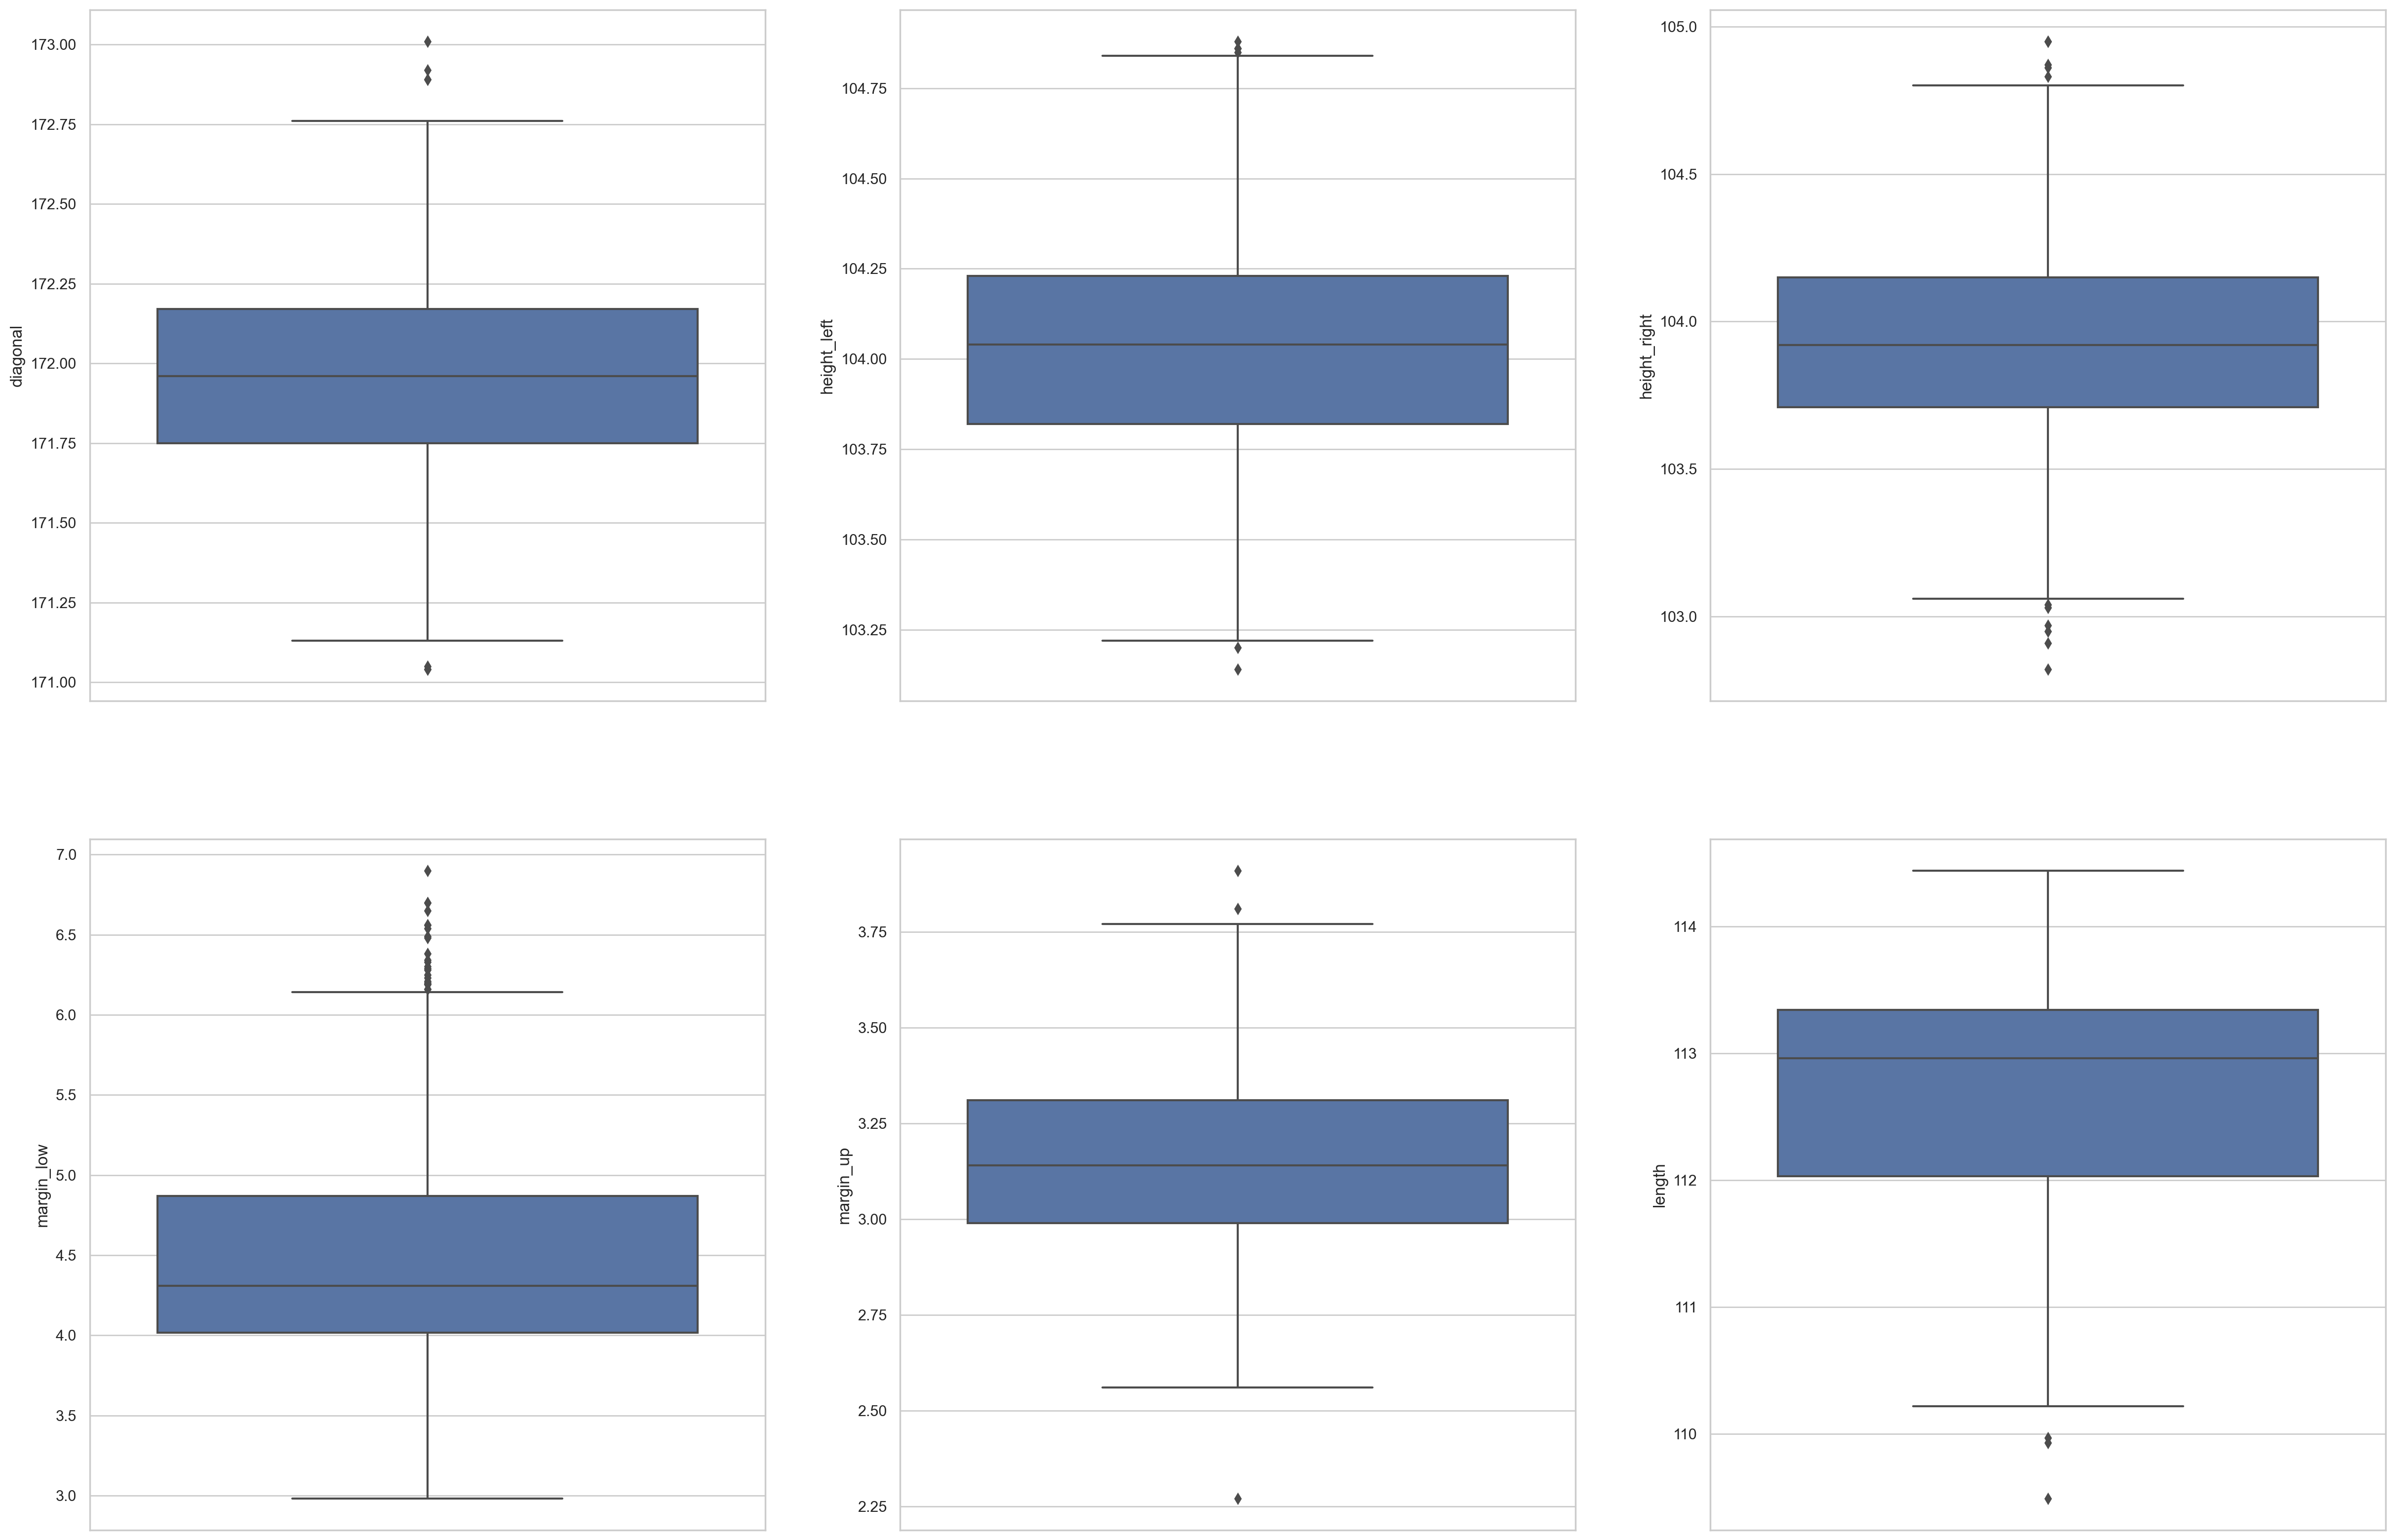

In [688]:
# Afficher des boxplot
plt.figure(figsize=(30, 20))
sns.set(style="whitegrid")

for i in range(1,7):
    print(i,df_billets1.columns[i])
    plt.subplot(2,3,i)
    sns.boxplot(data=df_billets1, y=df_billets1.columns[i])

plt.savefig('Distribution de l\'ensemble variables par boxplot.jpg')

### Visualisation bivarié

On utilise les boxplot pour montrer la relation entre chaque variable et 'is genuine'.

1 diagonal
2 height_left
3 height_right
4 margin_low
5 margin_up
6 length


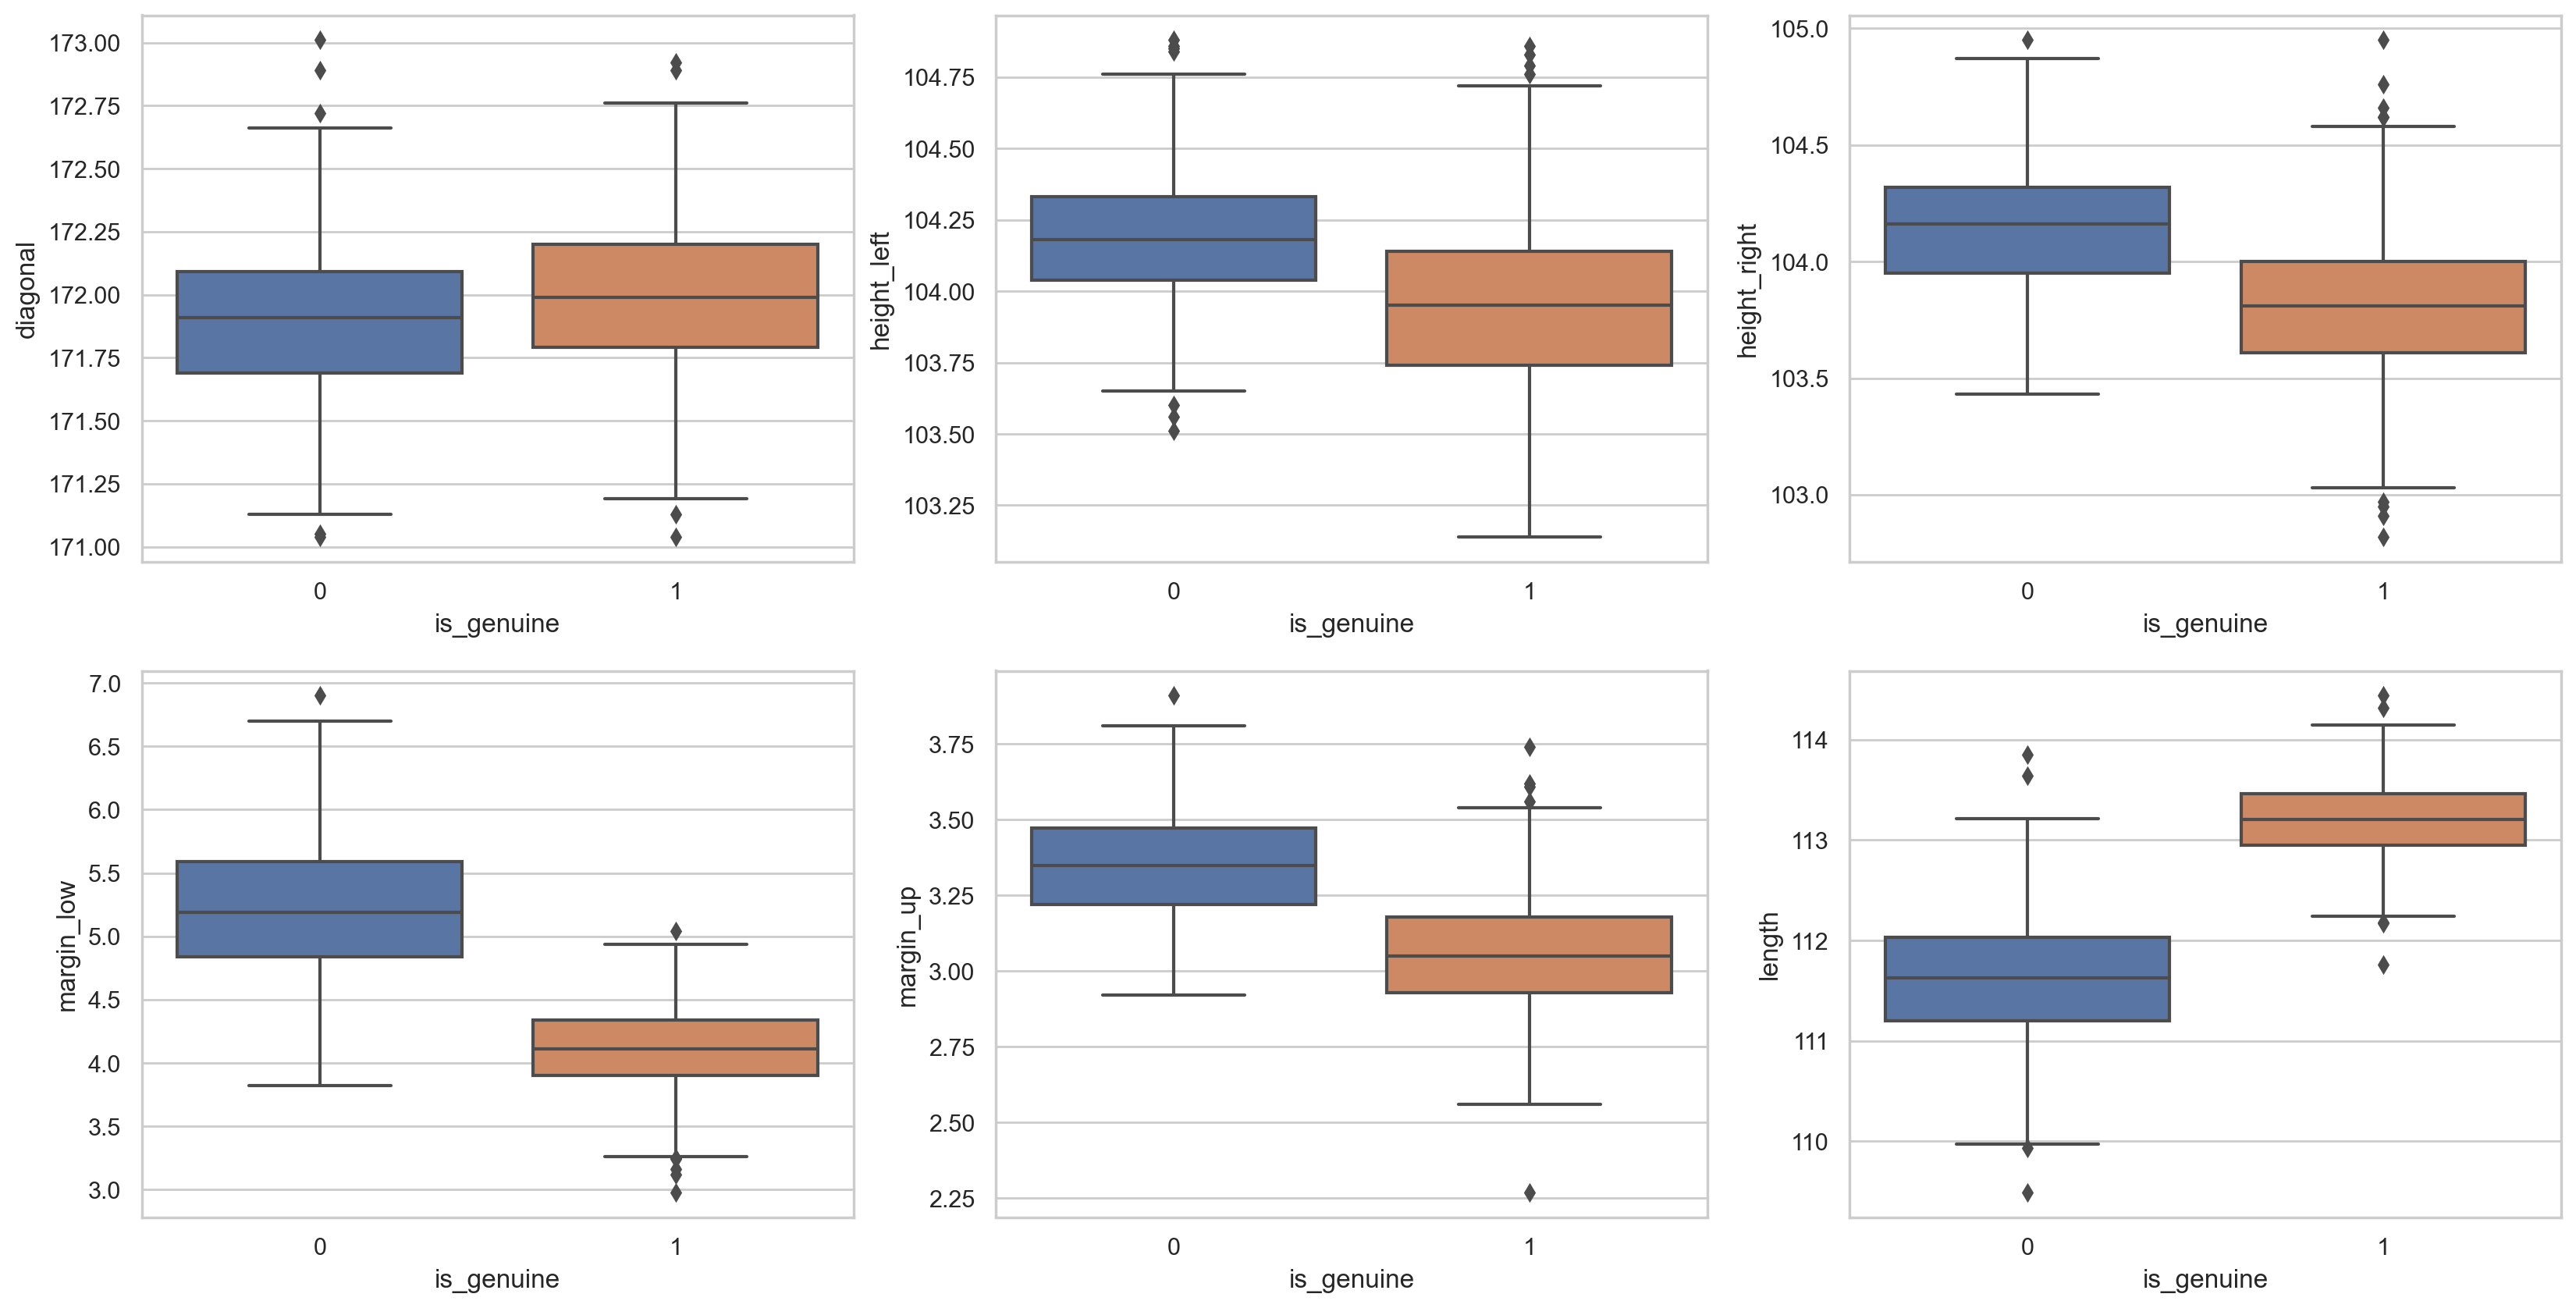

In [689]:
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")

for i in range(1,7):
    print(i ,df_billets1.columns[i])
    plt.subplot(2,3,i)
    sns.boxplot(data=df_billets1,x='is_genuine', y=df_billets1.columns[i])    

- 0 : faux billets 
- 1 : vrai billets

On remarque que les données entre les vrais et les faux billets présentaient des différences significatives dans les variables "margin low", "length" et "margin up", comme cela est visible dans les boxplots. 

Les statistiques descriptives:   

In [690]:
df_billets1.describe().T

count        mean       std     min      25%     50%     75%  \
is_genuine    1500.0    0.666667  0.471562    0.00    0.000    1.00    1.00   
diagonal      1500.0  171.958440  0.305195  171.04  171.750  171.96  172.17   
height_left   1500.0  104.029533  0.299462  103.14  103.820  104.04  104.23   
height_right  1500.0  103.920307  0.325627  102.82  103.710  103.92  104.15   
margin_low    1463.0    4.485967  0.663813    2.98    4.015    4.31    4.87   
margin_up     1500.0    3.151473  0.231813    2.27    2.990    3.14    3.31   
length        1500.0  112.678500  0.872730  109.49  112.030  112.96  113.34   

                 max  
is_genuine      1.00  
diagonal      173.01  
height_left   104.88  
height_right  104.95  
margin_low      6.90  
margin_up       3.91  
length        114.44

#### La corrélation entre les différentes variables

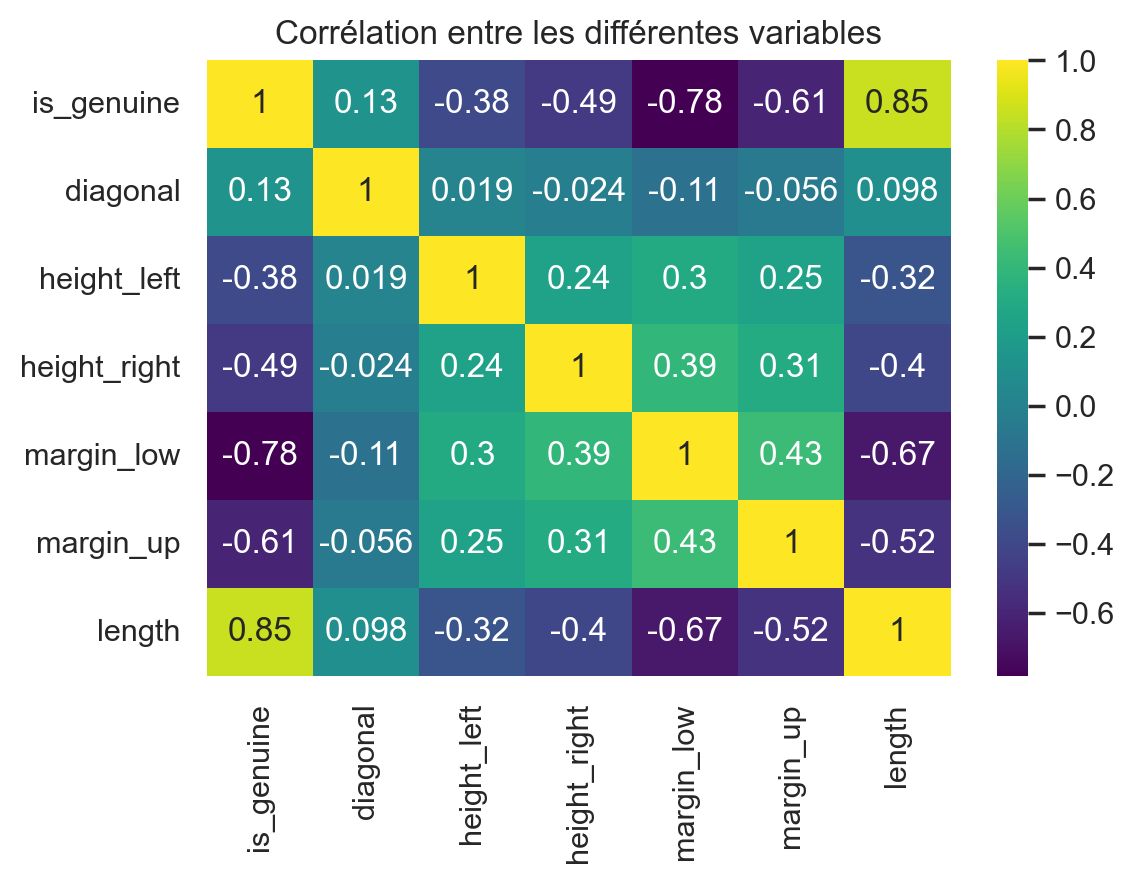

In [691]:
plt.figure(figsize=(6, 4))
sns.heatmap(df_billets1.corr(),cmap='viridis',annot=True).set(title='Corrélation entre les différentes variables')
# On sauvegarde la heatmap en tant qu'image
plt.savefig('Heatmap_des_correlations_entres_variables.jpg')

On constate que les variables *length* et *margin_low* semblent etre les deux variables les plus corrélées avec *is_genuine*. Ils sont donc les variables les plus influentes pour déterminer si un billet est vrai ou faux.
- Cependant *margin_low* et *length* sont aussi corrélées entre elles.

#### Les relations entres les variables selon *is_genuine*

<Figure size 100x100 with 0 Axes>

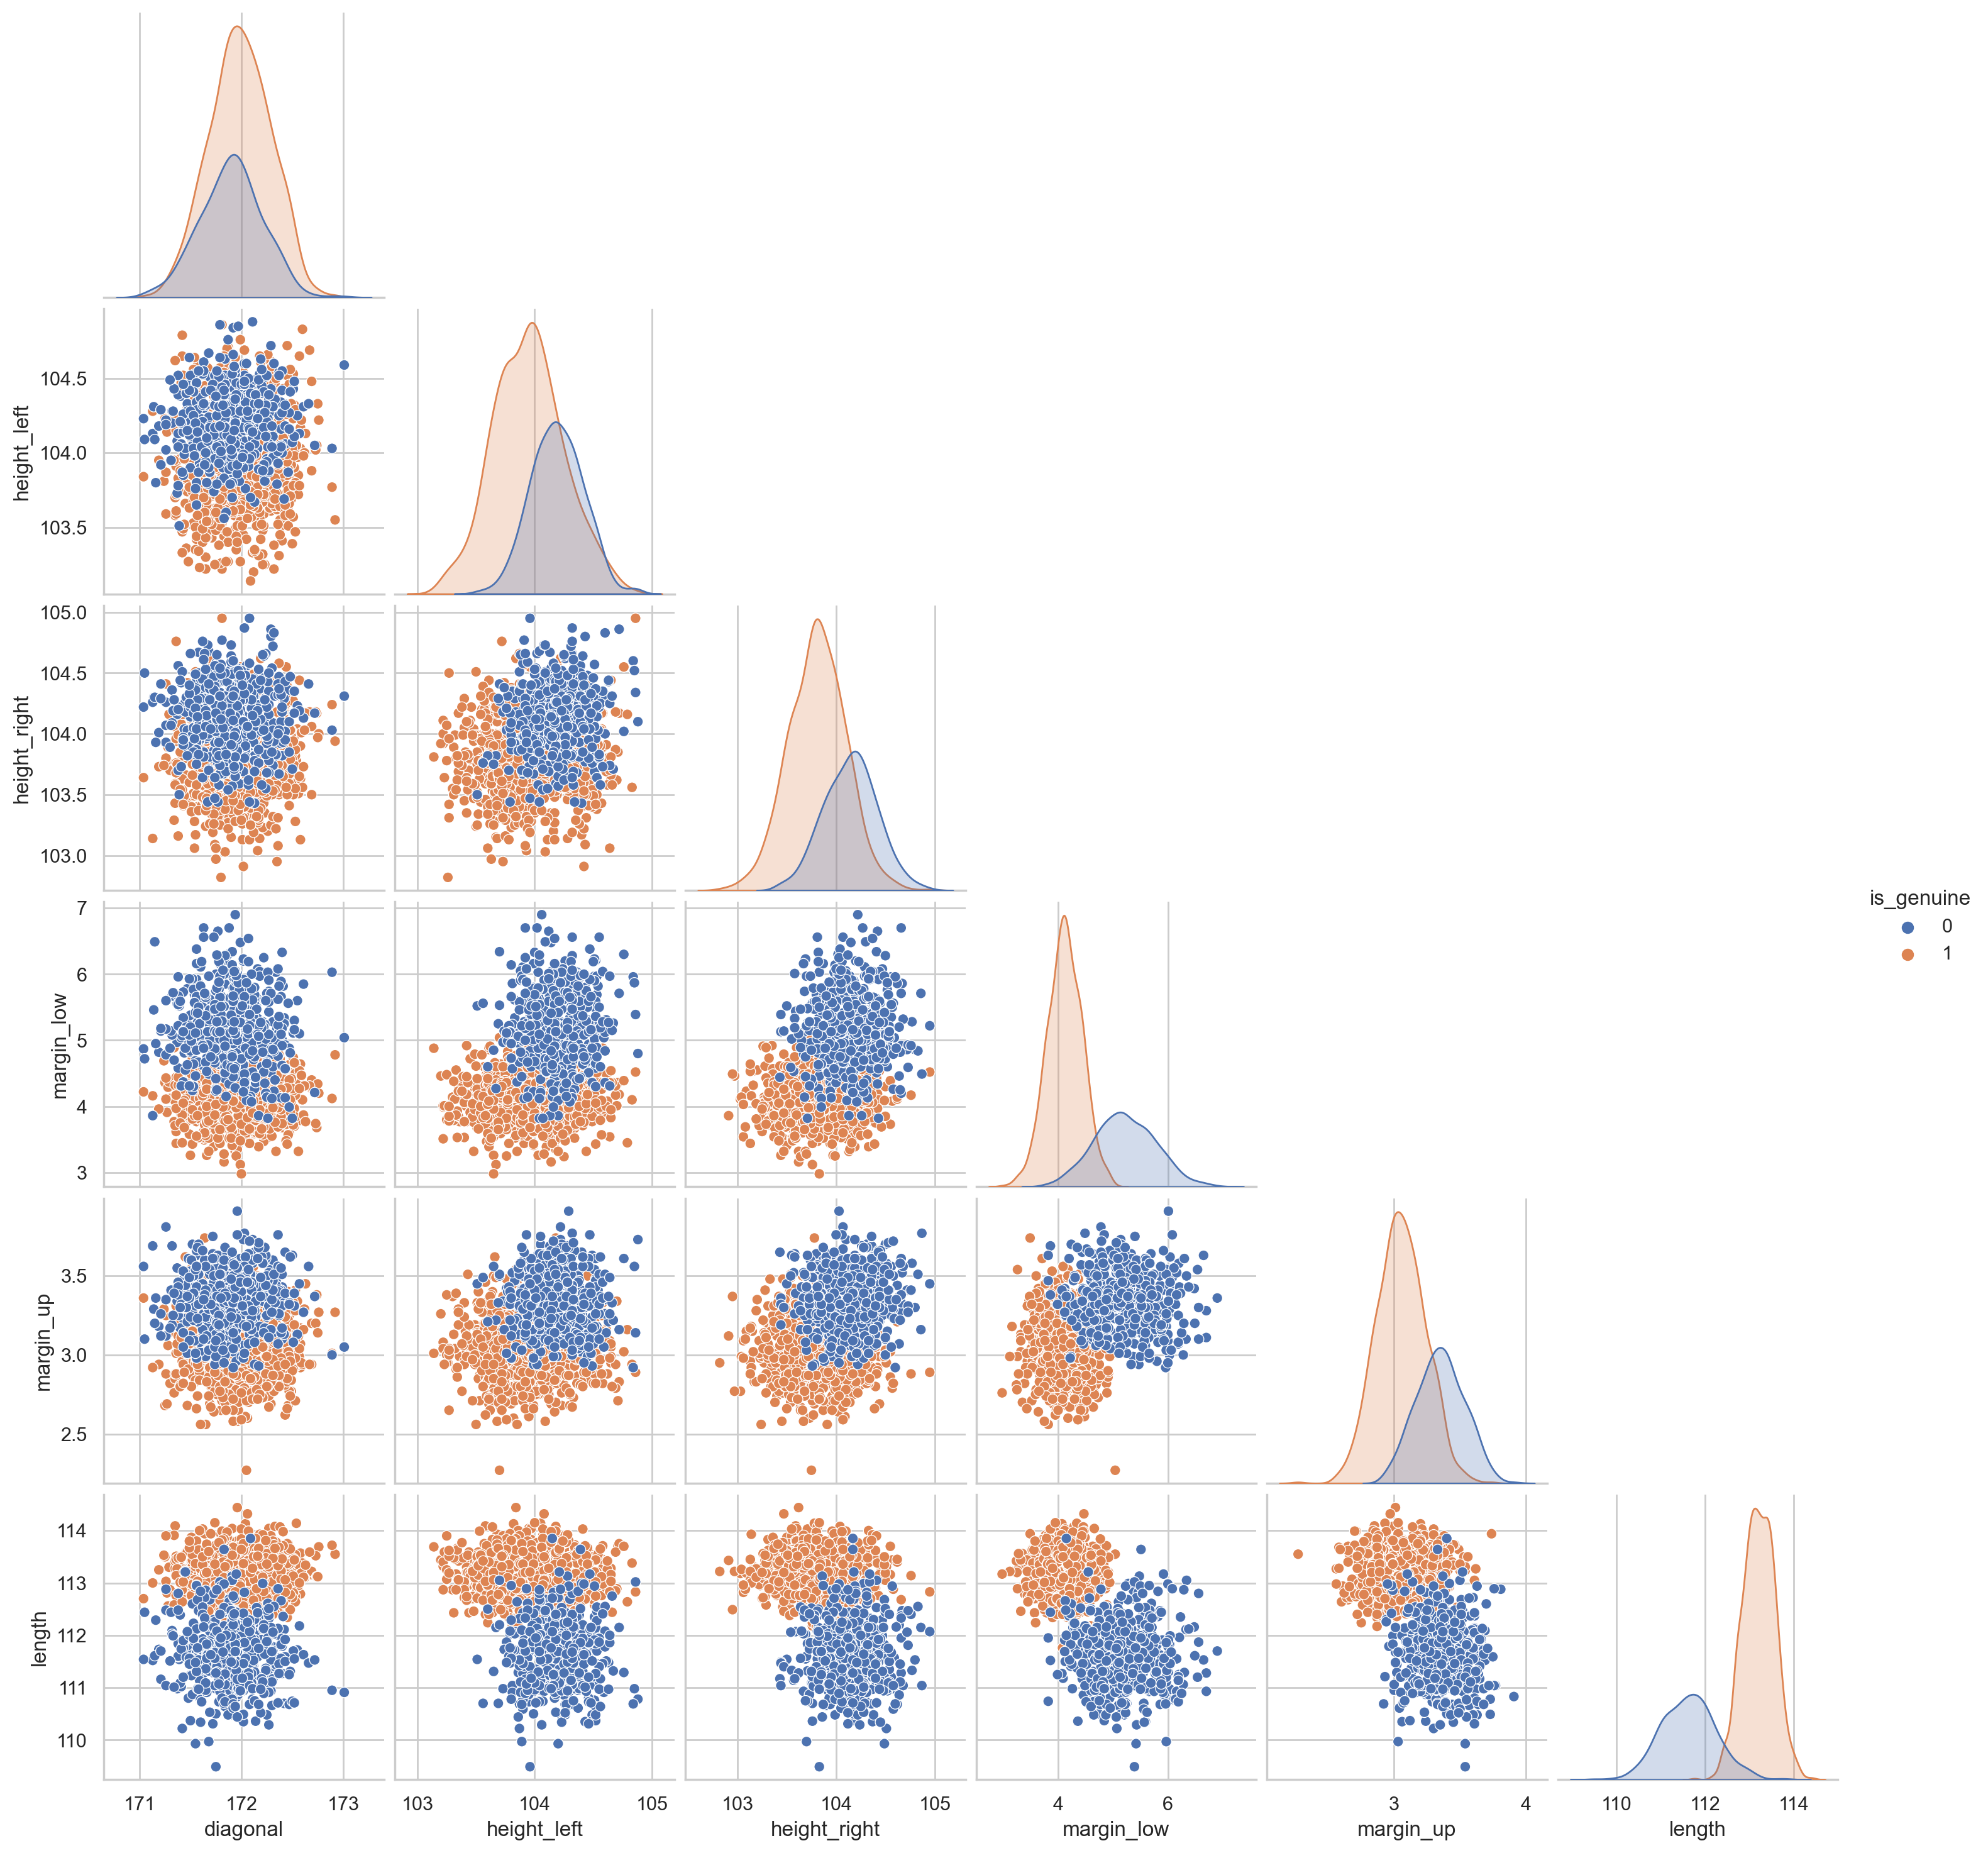

In [692]:
plt.figure(figsize=(1, 1))
sns.pairplot(df_billets1,hue='is_genuine',corner=True)

On voit ici par exemple que : 
- Les groupes de billets sont bien distinctes entre *length* et *margin_low*, et *length* et *margin_up*.
- Au contraire, les groupes ne sont pas distinctes entre *height_right* et *diagonal*.
- Une variable ne suffit pas pour distinguer la valeur de *is_genuine*. Il en faut au moins deux.

On revérifie qu'il y a 37 valeurs nulles dans "*margin_low*".

In [693]:
df_billets1.margin_low.isna().sum()

37

## Traitement des valeurs manquantes 

On va utiliser un modèle de régression linéaire multiple (avec plusieurs features) pour remplacer les valeurs manquantes.

### Modélisation - Régression linéaire multiple

In [694]:
df_billets1.shape

(1500, 7)

On n'utilise pas " is_genuine", car c'est une variable qualitative.

In [695]:
# data prep
df = df_billets1.dropna(axis=0).reset_index(drop=True).copy()
X = df[["diagonal","height_left","height_right", "margin_up", "length"]]
y = df["margin_low"]


# Division des données en données de train et de test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state =1) 

# Training
# Premier modele avec totues les features
model_linreg_first = LinearRegression()
model_linreg_first =model_linreg_first.fit(X_train, y_train)

In [696]:
# Evaluation
print("r2 score:", model_linreg_first.score(X_train, y_train))
print("intercept:", model_linreg_first.intercept_)
print("slope:", model_linreg_first.coef_) # regression line往下或往上

r2 score: 0.4731708830096394
intercept: 24.34268556331221
slope: [-0.12199179  0.16999104  0.27531021  0.25363622 -0.40798163]


- **R2 score** : un coefficient de détermination du modèle, il est utilisé pour mesurer la qualité de l'ajustement du modèle aux données.  

                - Le score R2 varie entre 0 et 1. (1 = perfect fitting) 

- **Intercept** : c'est le point où la ligne de régression croise l'axe vertical.
- **Slope** : le coefficient des variables indépendantes utilisé pour expliquer la direction et l'ampleur de l'impact des variables indépendantes sur la variable dépendante.

Ici, on a 0,47 comme R2 score, ce qui signifie que notre modèle n'est pas un modèle parfait.

### Validation du modèle

In [697]:
df_regmul0 = pd.DataFrame(X_train).copy()
df_regmul0["margin_low"] = y_train

In [698]:
X_train.shape

(1170, 5)

In [699]:
df_regmul0.shape

(1170, 6)

In [700]:
reg_multiple_1 = smf.ols('margin_low ~ diagonal + height_left + height_right + margin_up + length', data=df_regmul0).fit()

In [701]:
print(reg_multiple_1.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     209.1
Date:                Tue, 09 May 2023   Prob (F-statistic):          3.55e-159
Time:                        22:22:12   Log-Likelihood:                -818.37
No. Observations:                1170   AIC:                             1649.
Df Residuals:                    1164   BIC:                             1679.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       24.3427     10.841      2.245   

- **P>|t|** :  Toutes les variables sont corrélées avec la variable predictor '*margin_low*'.    
- **P < 0.05** : la variable indépendante X a un impact significatif sur Y. Cela signifie que cette variable est significative.
- **P > 0.05** : la variable indépendante X n'a pas d'impact significatif sur Y et doit être supprimée.

In [702]:
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

In [703]:
backward_elimination(X_train, y_train)

['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

Dans ce cas, toutes les variables sont significatives.
On va les utiliser pour notre modèle.

In [704]:
x_features=df.loc[:,['diagonal','height_left','height_right','length','margin_up']]
y_actual= df['margin_low']
y_pred = reg_multiple_1.predict(x_features)

On calcule: 

- le **MSE** (Mean squared Error) : En utilisant le model sur les données de tests ( et non sur le training_data) :
    - Une mesure de l'erreur moyenne quadratique des prédictions d'un modèle par rapport aux valeurs réelles.
    - Plus la valeur de MSE est faible, meilleure est la performance du modèle.

- le **RMSE**  (Erreur quadratique moyenne) 
    - Une mesure similaire à MSE, mais la racine carrée est prise de la moyenne des carrés des écarts. 
    - utilisant aussi pour mesurer l'erreur moyenne d'un modèle de régression. 
    - Plus il est faible, plus le fit est bon.

Note: Ces valeurs doivent etre testées sur les données de tests ( ci-dessus, je teste aussi sur le train mais cela ne peut pas être fiable)

In [705]:
X_test

diagonal  height_left  height_right  margin_up  length
719     171.69       103.85        103.53       3.19  112.68
683     171.71       103.52        103.34       3.31  113.15
503     171.91       104.34        103.73       2.95  113.69
424     172.04       103.82        103.99       3.14  113.23
846     172.25       104.21        103.79       3.25  112.71
...        ...          ...           ...        ...     ...
1183    171.88       104.14        104.42       3.18  111.38
1231    171.59       104.05        104.40       3.45  111.14
163     172.31       104.05        103.51       2.86  113.18
47      172.13       104.15        103.93       2.87  113.31
1087    171.94       104.14        104.14       3.06  112.04

[293 rows x 5 columns]

In [706]:
y_pred_test = model_linreg_first.predict(X_test)
y_pred_train = model_linreg_first.predict(X_train)

In [707]:
print("MSE (Mean Squared Error) : (test){} vs (train){}".
      format(mean_squared_error(y_test, y_pred_test), mean_squared_error(y_train, y_pred_train) ))
print("RMSE (Mean Squared Error) :(test) {} vs (train) {}".
      format(math.sqrt(mean_squared_error(y_test, y_pred_test)), math.sqrt(mean_squared_error(y_train, y_pred_train) )))

MSE (Mean Squared Error) : (test)0.2024748057127204 vs (train)0.2371752486114196
RMSE (Mean Squared Error) :(test) 0.44997200547669675 vs (train) 0.4870064153698795


Ces résultats indiquent que le modèle a une erreur de prédiction moyenne plus faible sur les données de testing set que sur les données de training set, ce qui est un bon signe. 


Dans l'analyse de régression linéaire, l'objectif est de minimiser les résidus. <br>
La somme résiduelle des carrés est fonction du paramètre. <br>
Afin de trouver la valeur minimale du résidu, la dérivée partielle du résidu par rapport au paramètre est nulle et la somme résiduelle est nulle, c'est-à-dire *la valeur moyenne du résidu est nulle*.

In [708]:
# Moyenne des residus
moyenne_residus = y_actual - y_pred
print("Moyenne des résidus : ", moyenne_residus.mean())

Moyenne des résidus :  -0.004651140385410836


### Analyse des résultats
 -Test d'hypothèses par analyse des résidus:

Les assumptions clés à vérifier lorsqu'on fait une Regression Linéaire:
1.	The functional form of regression is correctly specified i.e. there exists a linear relationship between the coefficient of the parameters (independent variables) and the dependent variable Y. 
2.	The residuals are normally distributed
3.	The variance of the residuals is constant across all values of the independent variable X (Homoscedasticity)
4.	There is no autocorrelation between errors
5.	There is no (low) correlation between independent variables( multi collinearity)

On va vérifier les points suivants un par un:

- **Outliers** 
- **Linéarité** 
- **Normalité de la distribution des résidus** 
- **Homocédasticité** 
- **Non-autocorrélation** 
- **Multicollinéarité**  



### 1. Outliers

In [709]:
n = X_train.shape[0] # df.shape[0]  # n: le nombre d'individus de l'échantillon
p = 2     # p: le nombre de variables

In [710]:
analyses_leverage = pd.DataFrame({'obs':np.arange(1, n+1)})

In [711]:
analyses_leverage.shape

(1170, 1)

**Le calcul des leviers**
 - Il permet d'identifier les points (valeurs aberrantes ou des observations avec des caractéristiques uniques) qui ont un impact important sur la relation entre les variables de la régression.
 - Pour identifier ces poins qui ont une influence importante sur les résultats de la régression.


On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [712]:
analyses_leverage['levier'] = reg_multiple_1.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

*Le seuil de levier* est un seuil arbitraire utilisé pour identifier les observations ayant un levier élevé.

- Les observations ayant un levier supérieur à ce seuil sont considérées comme ayant une influence importante sur les résultats de la régression.

In [713]:
seuil_levier

0.003418803418803419

On plot sur un echantillons de n/8 pour visualiser les outliers

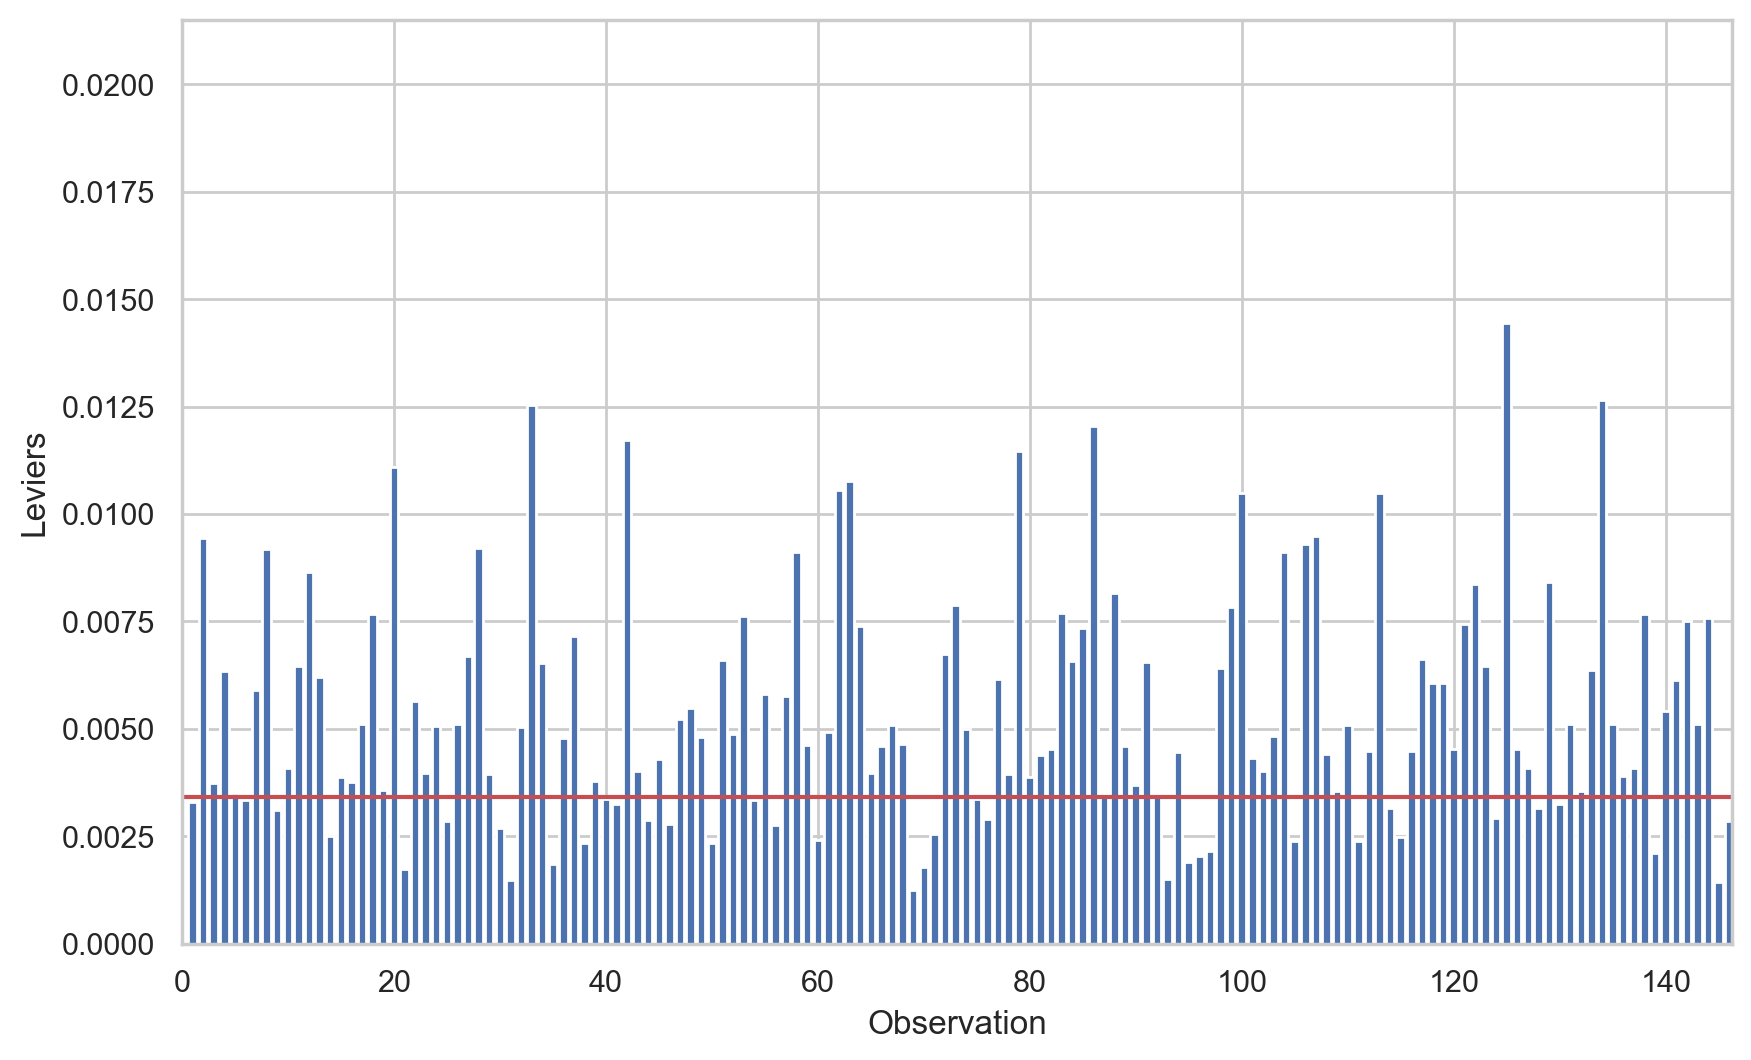

In [828]:
plt.figure(figsize=(10,6))
plt.bar(analyses_leverage['obs'], analyses_leverage['levier'])
plt.xlim(left=0, right=n/8)
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n/8], [seuil_levier, seuil_levier], color='r')
plt.show()

Pour sélectionner les points pour lesquels le levier est supérieur au seuil, on exécute la ligne suivante :

In [715]:
analyses_leverage.loc[analyses_leverage['levier'] > seuil_levier, :]

obs    levier
1        2  0.009434
2        3  0.003743
3        4  0.006345
4        5  0.003498
6        7  0.005894
...    ...       ...
1163  1164  0.004478
1165  1166  0.004124
1167  1168  0.003812
1168  1169  0.006663
1169  1170  0.003937

[827 rows x 2 columns]

Ici, on constate qu'il y a 827 observations dont le levier est supérieur au seuil de levier fixé, cela signifie que ces observations ont une influence importante sur les résultats de la régression linéaire. 
Cela peut indiquer qu'il y a des valeurs aberrantes ou des observations extrêmes qui ont un impact important sur la relation entre les variables indépendantes et la variable dépendante dans la régression linéaire.

**Le calcul des résidus studentisés**
- Il permet d'identifier les observations qui ont une influence importante sur le modèle. 
- Il sont les résidus standardisés en les divisant par leur écart-type estimé. En utilisant pour détecter les observations qui sont éloignées du modèle plus que ce qui serait attendu par hasard.

Ces observations sont appelées "outliers" ou "points aberrants" et peuvent avoir une influence considérable sur les résultats de la régression.

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [716]:
# Nous allons ic réaliser les tests à un niveau alpha=5% :
alpha = 0.05

In [717]:
analyses_leverage['rstudent'] = reg_multiple_1.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

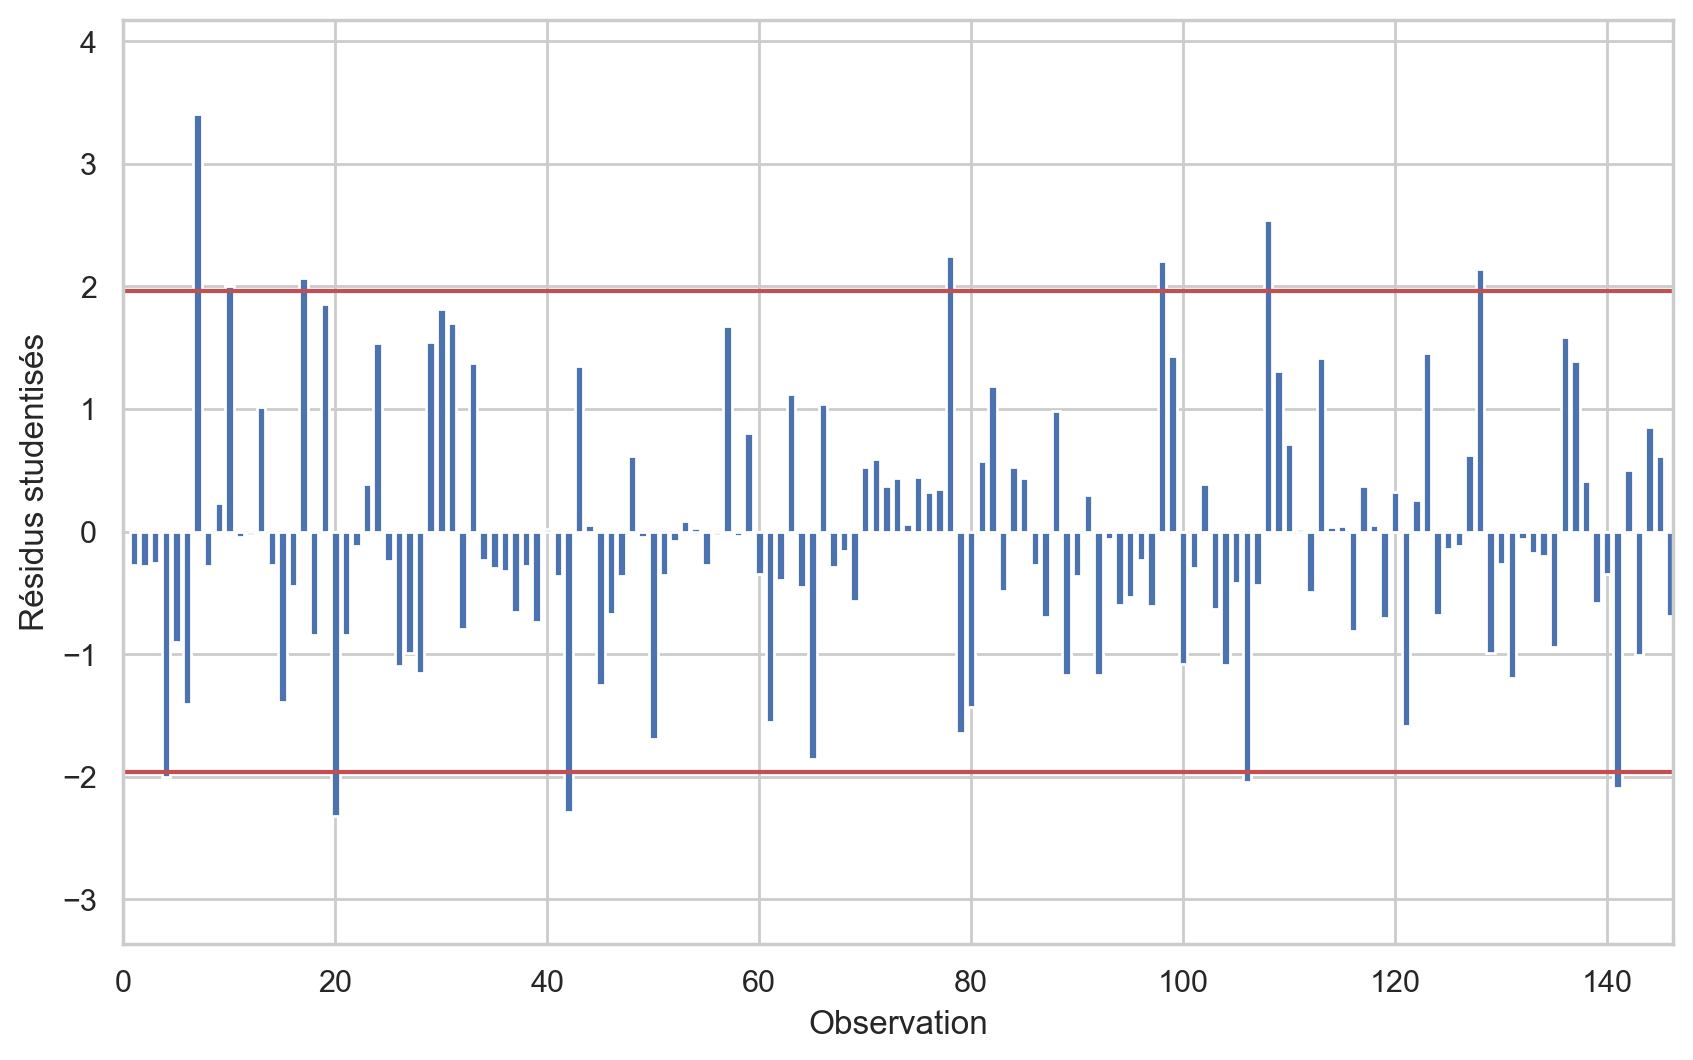

In [718]:
plt.figure(figsize=(10,6))
plt.bar(analyses_leverage['obs'], analyses_leverage['rstudent'])
plt.xlim(left=0, right=n/8)
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n/8], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n/8], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

Dans le graphique, les barres représentent les résidus studentisés pour chaque observation. 

Les observations dont les barres dépassent les lignes rouges représentent des valeurs aberrantes potentielles, c'est-à-dire des valeurs qui ont un impact disproportionné sur les résultats de la régression. 

Les lignes rouges représentent le seuil au-delà duquel une observation est considérée comme aberrante en termes de résidus studentisés. 
Ainsi, les observations dont les barres dépassent ces seuils sont des valeurs aberrantes potentielles qui doivent être examinées de plus près pour voir s'il est nécessaire de les exclure de l'analyse.

**Déterminez la distance de Cook**
- C'est une mesure qui permet de quantifier l'influence de chaque observation sur la régression linéaire. <br>
  Elle mesure l'effet qu'aurait la suppression de l'observation sur les estimations des paramètres du modèle. 


In [719]:
# Pour trouver la distance de Cook, nous exécutons ceci :
influence = reg_multiple_1.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p. 

In [720]:
analyses_leverage['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

On peut détecter les observations influentes comme ceci :

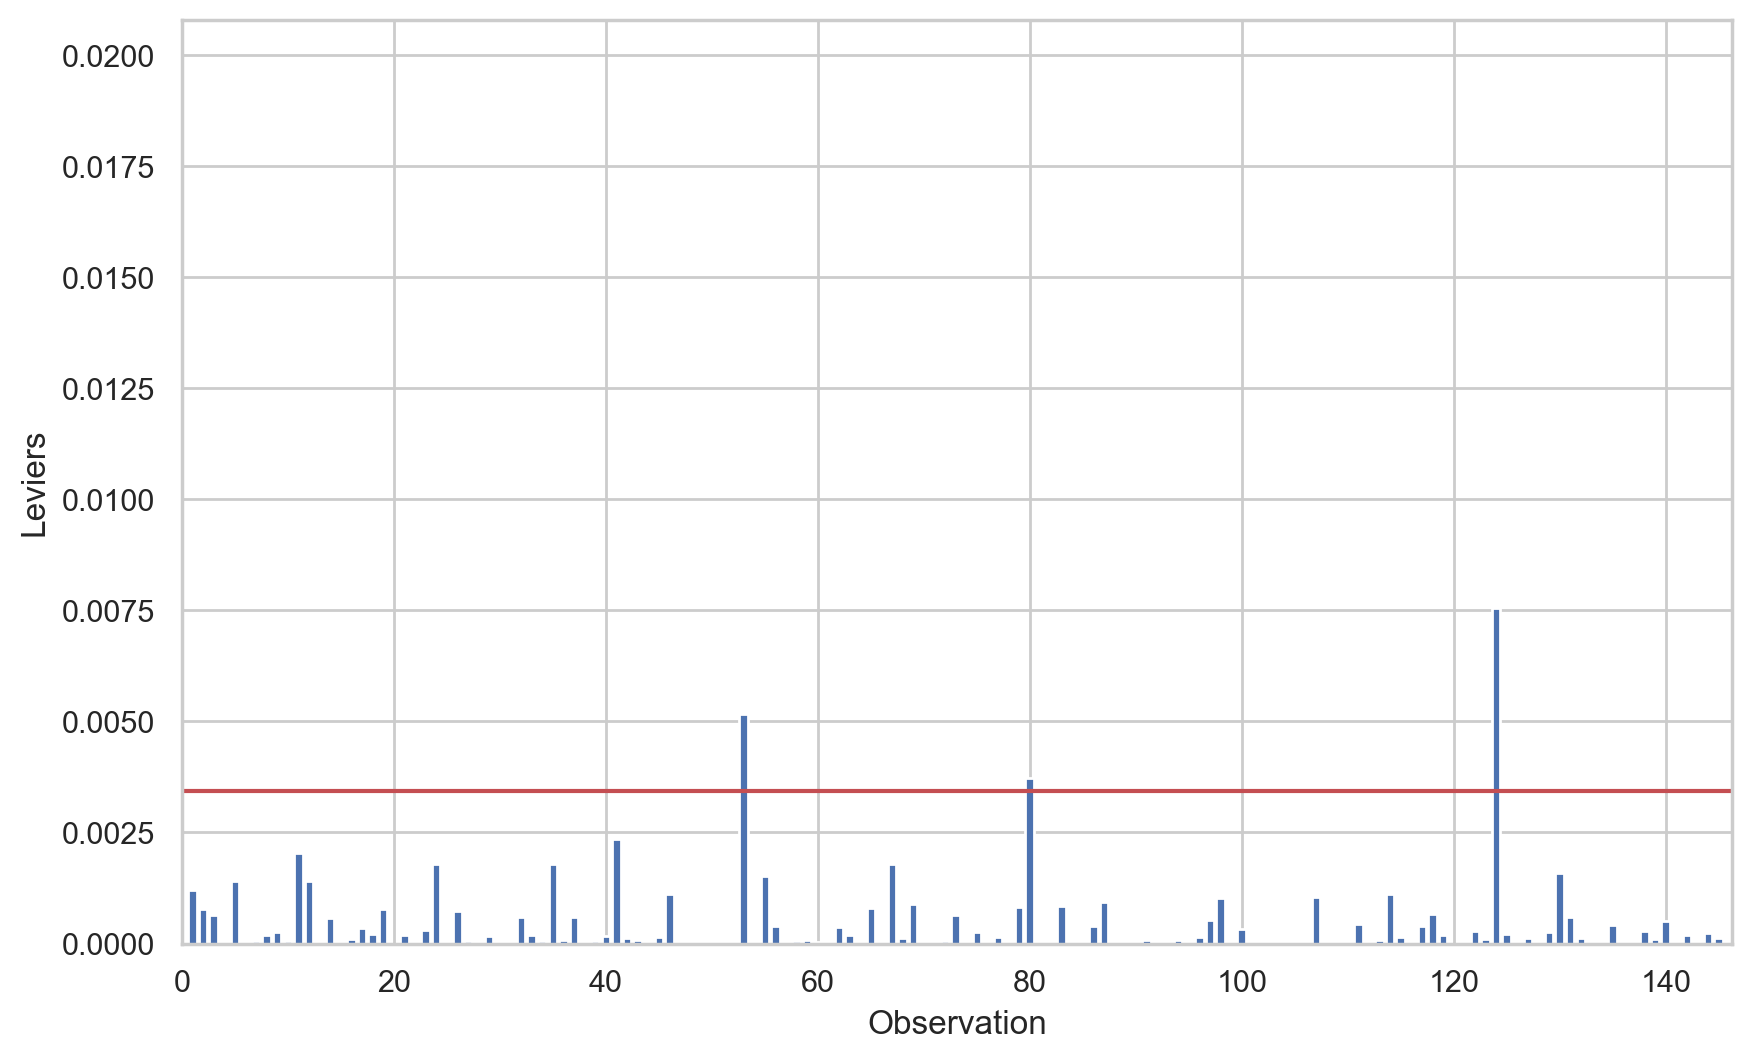

In [721]:
plt.figure(figsize=(10,6))
plt.bar(analyses_leverage['obs'], analyses_leverage['dcooks'])
plt.xlim(left=0, right=n/8)
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n/8], [seuil_dcook, seuil_dcook], color='r')
plt.show()

Les observations qui se trouvent au-dessus de la ligne rouge représentent les points qui ont une influence importante sur la régression.

- Plus la distance de Cook est grande, plus l'observation a une influence importante sur la régression.

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.

### 2. Linéarité

 **Rainbow test**

 - H0 : La relation entre les variables independants et la variable dependente est linéaire. 
 - H1 : H0 est refusé.

In [722]:
# Perform the Rainbow test
rainbow_statistic, p_value = linear_rainbow(reg_multiple_1)

print('Rainbow test statistic:', rainbow_statistic)
print('p-value:', p_value)

Rainbow test statistic: 0.9800291720140607
p-value: 0.596140504173489


In [723]:
y_train.shape

(1170,)

p-value ici > 0.05. <br>
H0 est refusé, cela signifie que la relation entre les variables indépendantes et la variable dépendante est linéaire. 

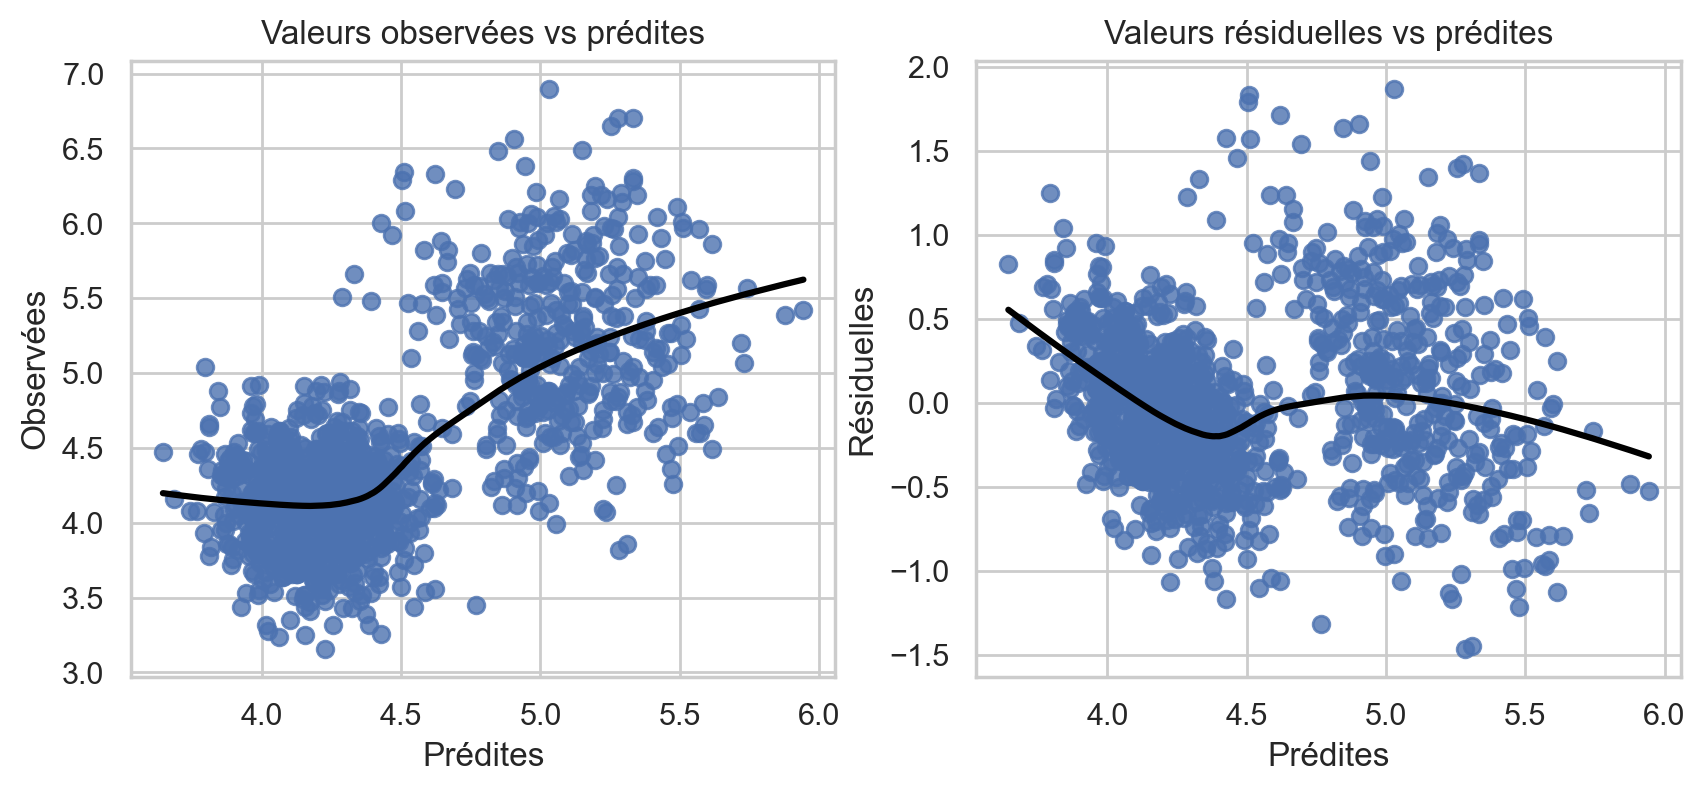

In [724]:
# Linearite:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'black'})
    ax[0].set_title("Valeurs observées vs prédites")
    ax[0].set(xlabel="Prédites", ylabel="Observées")

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'black'})
    ax[1].set_title("Valeurs résiduelles vs prédites")
    ax[1].set(xlabel="Prédites", ylabel="Résiduelles")
    
linearity_test(reg_multiple_1, y_train)

La relation n'est pas linéaire, On distinguent deux groupes.
Cela ne veut pas dire que le modèle est totalement inéfficace, mais il n'est vraiment adapté.

Il y a les solutions potentielles: 
- Transformation non-linéaire sur les variables dépendantes/indépendantes.
- Ajout d'une feature, transformation de features préexistantes (mise au carré par exemple).
- Ajout de features non considérées précédemment.

### 3. Normalité de la distribution des résidus : 

- *Omnibus* test, 
    - H0 : les résidus sont distribués selon une loi Normale. 
    - H1 : Refus de H0
    - (La valeur de *Prob(Omnibus)* doit être proche de 1.)    

Ici elle est 0, H0 est refusée, les coefficiants estimés ne seront pas BLUE. <br>
Cependant, en regardant graphiquement la distribution, on constate qu'elle est plus ou moins normal.
On suppose ici que cest parce que notre echantillon n'est pas assez grand pour que le test soit significatif.

- *Prob(Jacque-Bera)* est redondant avec Prob(Omnibus), une valeur élevée pour le *Jarque-Bera* indique que les résidus sont distribués selon une loi Normale.

Visualiser la distribution des residus sous forme d'histogramme

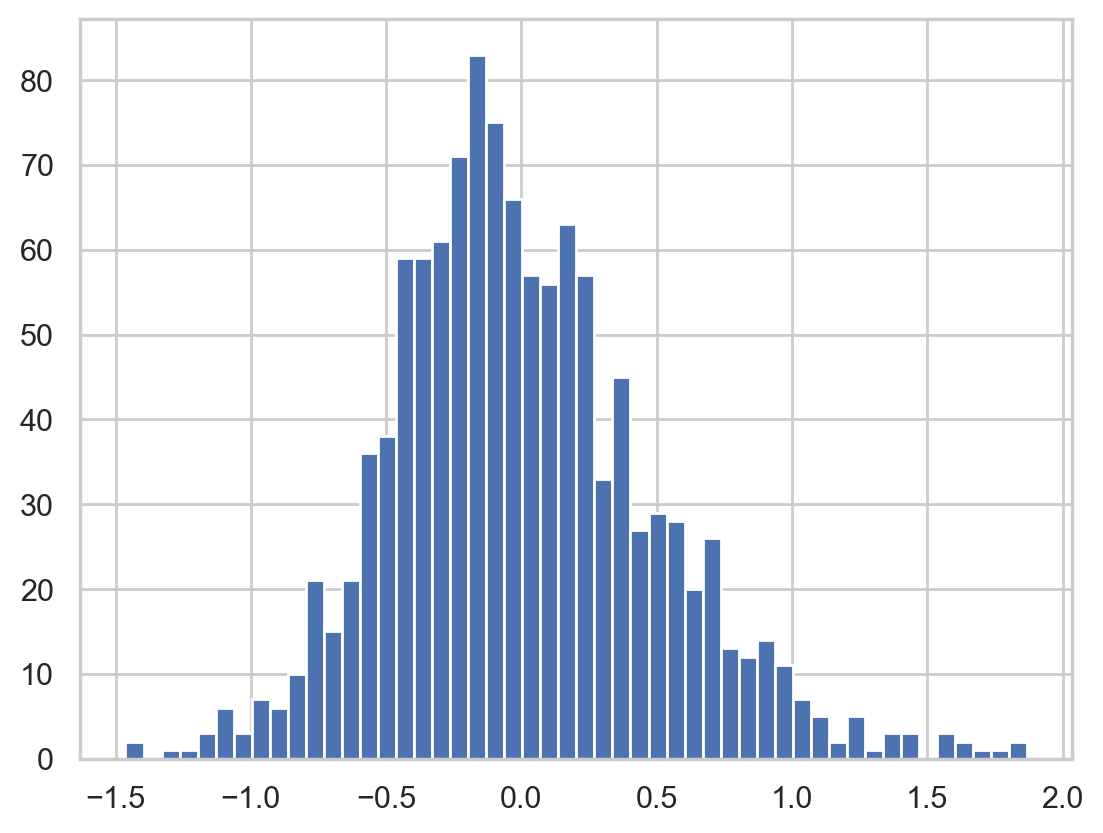

In [725]:
# Représenter nos residus avec un histogramme
y_pred=reg_multiple_1.predict(X_train)
residus = y_train - y_pred
plt.hist(residus,bins=50)
plt.show()

Selon le graphique, on constate que les résidus ont une distribution plus ou moins normale.

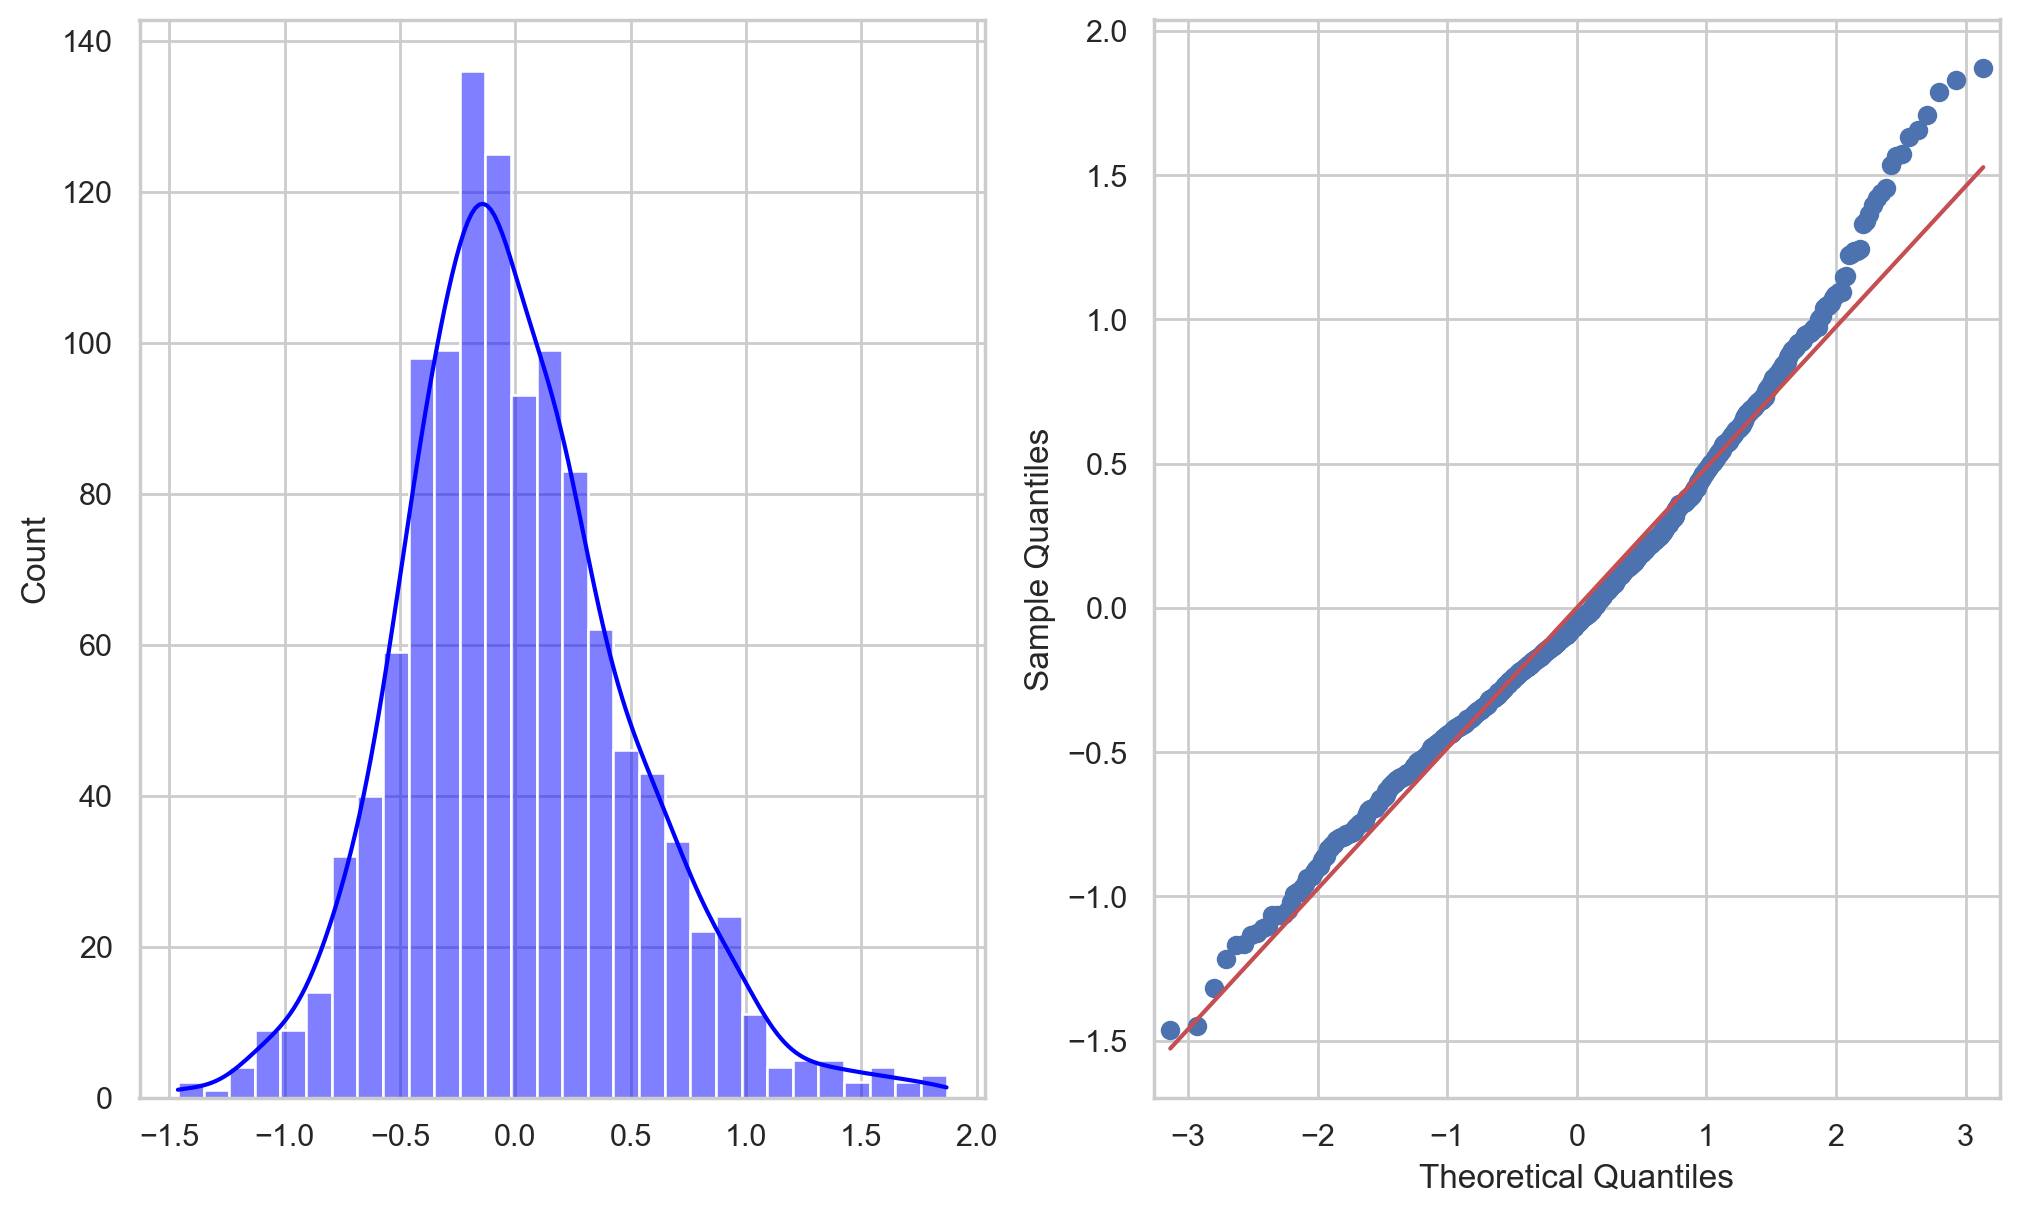

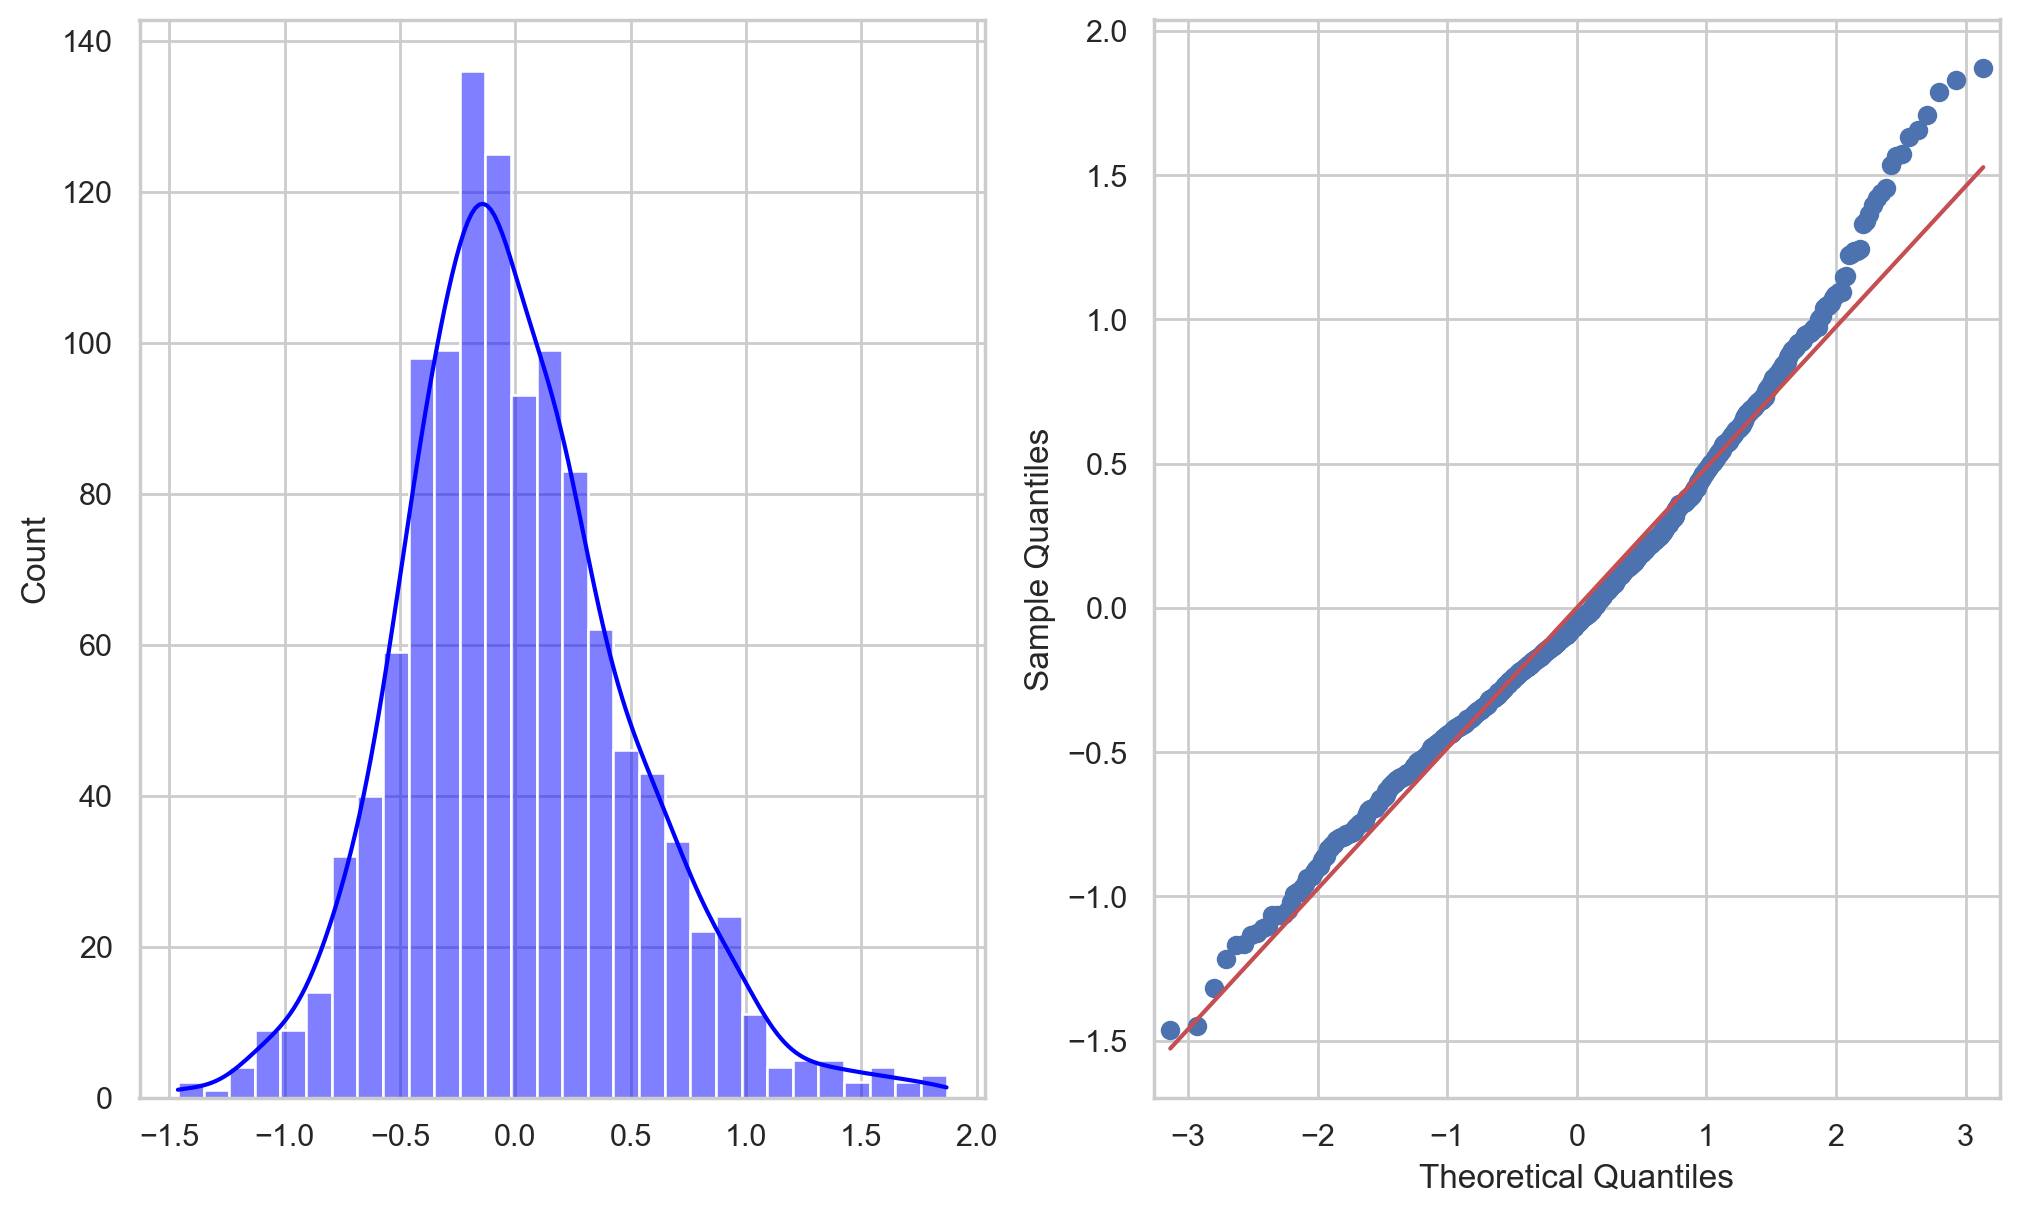

In [726]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 7))
sns.histplot(residus,kde=True, color ='blue',ax=ax1)
sm.ProbPlot(residus).qqplot(line='s', ax=ax2)

**Test de Shapiro-Wilk** <br>
    - On peut savoir si les échantillons tirés au hasard proviennent de la distribution normale. <br>
    - Plus la valeur statistique W est petite, moins il est probable que les données proviennent d'une distribution normale.

In [727]:
shapiro_test = stats.shapiro(residus)
shapiro_test

ShapiroResult(statistic=0.9837262630462646, pvalue=3.642248169732909e-10)

Letest de shapiro nous indique qu' il ne s'agit pas d'une distribution normal, mais graphiquement on est quand meme proche. Le fait qu'il ne s'agisse pas tout a fait d'une distribution normal ne doit pas nous bloquer.

 ### 4. Homocédasticité 
    - Pour verifier si la variance de residus est constante.

Il y plusieurs facons pour vérifier l'homoscedasticité:
- Breusch-Pagan test
- White test
- Visualisation graphique

Comme nos residus ont echoué le test de normalité, c'est mieux d'utiliser le test de White au lieu du BP test.

{'Test Statistic': 98.54382081417977, 'p-value': 2.2931853488004334e-12, 'F-Statistic': 5.283783523537637, 'F-Test p-value': 5.796846582244855e-13}


Text(0.5, 1.0, 'Homoscédasticité')

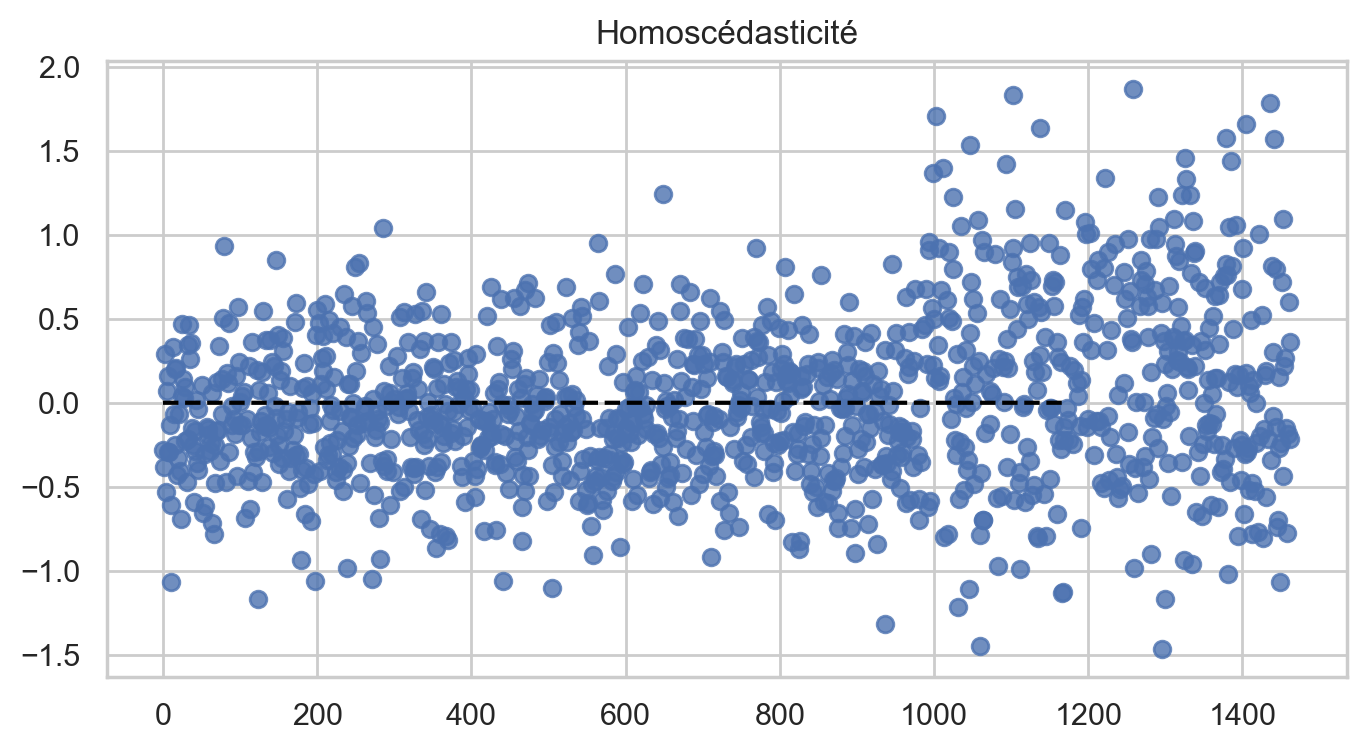

In [728]:
# Homoscedasticite:
white_test = het_white(reg_multiple_1.resid, reg_multiple_1.model.exog )
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=reg_multiple_1.resid.index, y=reg_multiple_1.resid, alpha=0.8)
plt.plot(np.repeat(0, len(reg_multiple_1.resid.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

le text de White : 
 - H0 : Il y a homoscédasticité 
 - H1 : Il y a hétéroscédasticité

La P-valeur < 0.05 (5%), donc on rejete l'hypothese nulle : Il y a hétéroscédasticité.

Ici, on prend les observations dans l'ordre donnée dans le dataset (avec les index), qui est:
- D'abord les billets vrai
- Ensuite les billets faux.
Ce qui explique l'apparance de manque de constance dans la distribution des residus.
On observe un résidu plus élevé pour les billets faux.

### 5. Non-autocorrélation
  - La corrélation des erreurs (résidus) dans le temps. 

**Durbin-Watson** 
 - Valeurs DW proche de 2 = pas de corrélation entre les résiduels
 - Loin de 2 = ne satisfait pas l'hypothèse d'indépendance résiduelle

Donc notre valeur DW est 1.974 , ce qui signifie qu'il y a pas d'autocorrélation.


### 6. Multicollinéarité
On suppose que les prédicteurs utilisés dans la régression ne sont pas corrélés les uns aux autres. 

- Le **cond. No.** est superieur à 30, ce qui peut indiquer qu'il y a un problème de multicollinéarité.
- Le **VIF** < 10, cela indique qu'il y a pas un problème de multicollinéarité.

In [729]:
# VIF (variance inflation factor)
variables = reg_multiple_1.model.exog # 要求在reg_multiple裡面直接拿取variable X
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

# endog = variable y 
# exog = variable x

[1.0149497057950003,
 1.1404387009379209,
 1.2528008354104854,
 1.3787230768857526,
 1.5415658682095223]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.
Meme si le cond.no est élevée: il y a une influence de intercept car on n'a pas centré les donnees X. 

### Application du modèle de regression multiple

D'apres les tests réalisés: 
- les données ne sont pas linéaires.
- Un modèle non-linéaire pourrait données de meilleurs résultats
- Mais, dans le cadre de ce projet, on doit utiliser une regression linéaire.

On va mainteant appliquer ce modèle pour prédire les valeurs nulles dans **margin_low**

In [730]:
# new dataframe with only the missing data as shown previously 
features_names_rg = ['diagonal','height_left','height_right','margin_up','length']
df_na = df_billets1[df_billets1['margin_low'].isnull()]

x_null = df_billets1[features_names_rg]
y_null = reg_multiple_1.predict(x_null)

In [731]:
tmp = df_na.copy()
tmp.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72            1    171.94       103.89        103.45         NaN       3.25   
99            1    171.93       104.07        104.18         NaN       3.14   
151           1    172.07       103.80        104.38         NaN       3.02   
197           1    171.45       103.66        103.80         NaN       3.62   
241           1    171.83       104.14        104.06         NaN       3.02   

     length  
72   112.79  
99   113.08  
151  112.93  
197  113.27  
241  112.36

In [732]:
# Combler les valeurs dans les valeur manquant de margin low
tmp['margin_low'] = y_null

In [733]:
tmp.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72            1    171.94       103.89        103.45    4.316697       3.25   
99            1    171.93       104.07        104.18    4.403277       3.14   
151           1    172.07       103.80        104.38    4.426124       3.02   
197           1    171.45       103.66        103.80    4.331748       3.62   
241           1    171.83       104.14        104.06    4.657649       3.02   

     length  
72   112.79  
99   113.08  
151  112.93  
197  113.27  
241  112.36

In [734]:
# concat deux dataframes
tmp2 = df_billets1.dropna(axis=0).copy()
df_new = pd.concat([tmp, tmp2])

In [735]:
df_new.shape

(1500, 7)

#### Vérification des données, l'échelle de grandeur des données n'est pas la même
Analyse descriptive:

In [736]:
# Resume des donnees apres regression lineaire:
df_new.info()
df_new.describe().T


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 72 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 93.8 KB


count        mean       std     min     25%     50%     75%  \
is_genuine    1500.0    0.666667  0.471562    0.00    0.00    1.00    1.00   
diagonal      1500.0  171.958440  0.305195  171.04  171.75  171.96  172.17   
height_left   1500.0  104.029533  0.299462  103.14  103.82  104.04  104.23   
height_right  1500.0  103.920307  0.325627  102.82  103.71  103.92  104.15   
margin_low    1500.0    4.483611  0.659614    2.98    4.02    4.31    4.87   
margin_up     1500.0    3.151473  0.231813    2.27    2.99    3.14    3.31   
length        1500.0  112.678500  0.872730  109.49  112.03  112.96  113.34   

                 max  
is_genuine      1.00  
diagonal      173.01  
height_left   104.88  
height_right  104.95  
margin_low      6.90  
margin_up       3.91  
length        114.44

            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
0                500          500           500         500        500     500
1               1000         1000          1000        1000       1000    1000


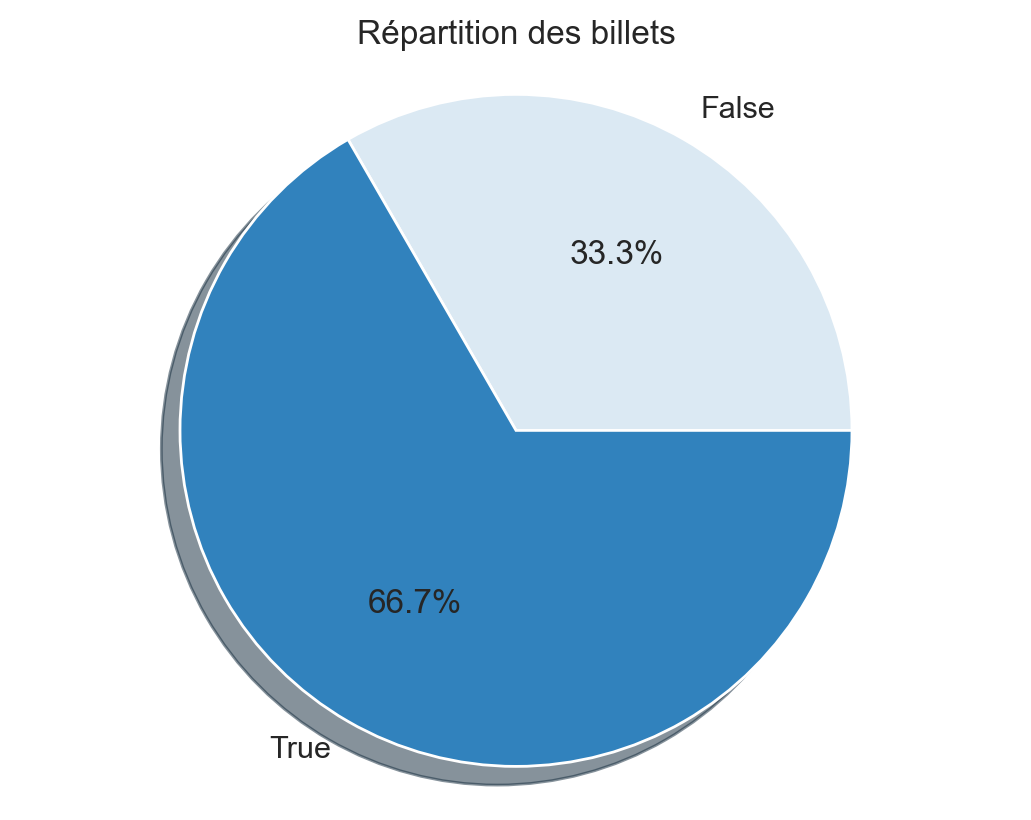

In [737]:
# Repartition des vrais/faux billets dans notre dataset d'apprentissage:
print(df_new.groupby(["is_genuine"]).count())

# Graphique:
fig1, ax1 = plt.subplots()
ax1.pie(df_new.groupby(["is_genuine"])["diagonal"].count(),
        labels=["False","True"],
        autopct="%1.1f%%",
        colors=["#dbe9f3","#3182bd"],
        shadow=True)
ax1.axis("equal")
plt.title("Répartition des billets")
plt.show()

In [738]:
# Billets moyens selon l'authenticité:
print(df_new.groupby(["is_genuine"]).mean())

             diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                                
0           171.90116    104.19034     104.14362    5.214151    3.35016   
1           171.98708    103.94913     103.80865    4.118341    3.05213   

               length  
is_genuine             
0           111.63064  
1           113.20243  


## Analyse en composantes principales (ACP)

    Avant de réaliser le modèle pour prédire les faux billets, on fait d'abord ACP pour regarder : 
    - Les relations entre les variables 
    - La variabilité des individues

  - On affiche le diagramme qui décrit le pourcentage d’inertie totale associé à chaque axe.
  - On affiche également une courbe qui représente la somme cumulée des inerties.

In [739]:
df_tmp_pca =df_new.drop(columns=["is_genuine"], axis=1, inplace=False)

In [740]:
sns.set()
# Selectionner les valeurs à utiliser pour notre analyse
X = df_tmp_pca.values
# On fait un centrer/reduire pour normaliser l'importance des données.
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X) # 放這個是為了算入每個國家不同的重要性
X_scaled[:5]

array([[-0.06044051, -0.46610259, -1.44479235, -0.25313193,  0.42516803,
         0.12780265],
       [-0.09321736,  0.13517643,  0.79778359, -0.12182943, -0.0495104 ,
         0.46020417],
       [ 0.36565855, -0.76674211,  1.41218796, -0.08718171, -0.56734141,
         0.28827235],
       [-1.66650621, -1.23440357, -0.36958471, -0.23030669,  2.02181364,
         0.67798448],
       [-0.42098587,  0.36900717,  0.42914097,  0.26393641, -0.56734141,
        -0.36506857]])

In [741]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5
mean  0.0  0.0 -0.0 -0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0

In [742]:
# Calcul des composantes principales
pca = PCA(n_components=0.99)
pca.fit(X_scaled)

PCA(n_components=0.99)

In [743]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([43.29, 16.96, 13.03, 11.82,  9.6 ,  5.3 ])

In [744]:
n_components = scree.size
scree_cum = scree.cumsum().round()
scree_cum

array([ 43.,  60.,  73.,  85.,  95., 100.])

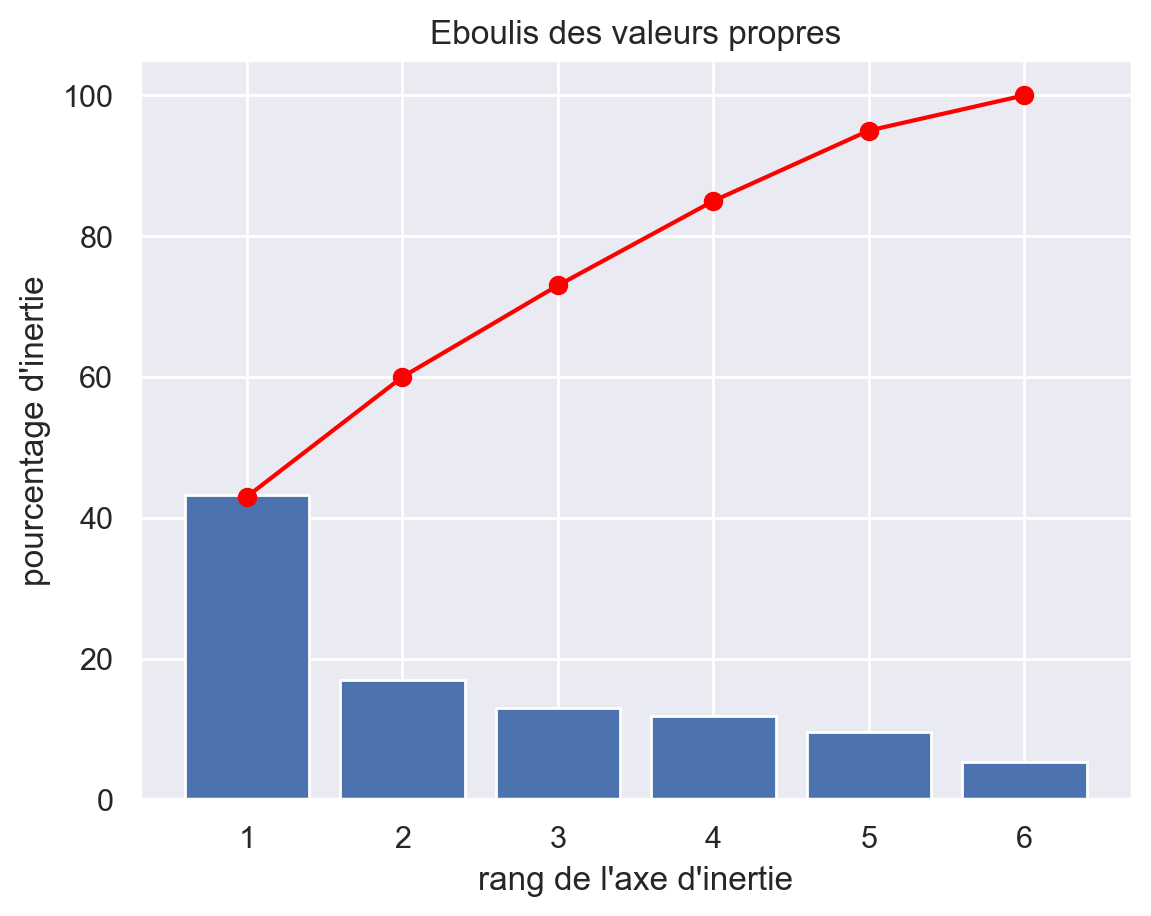

In [745]:
# Eboulis des valeurs propres
# Définisons ensuite une variable avec la liste de nos composantes :
x_list = range(1, n_components+1)
v = list(x_list)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [746]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs

0         1         2         3         4         5
0 -0.084761  0.330605  0.393609  0.507693  0.439397 -0.527035
1  0.941241  0.307661  0.108396 -0.072667 -0.004814  0.048557
2 -0.287914  0.885044 -0.163831 -0.109084 -0.269920  0.149013
3 -0.101923 -0.049084  0.866237 -0.088510 -0.444840  0.176406
4 -0.116302  0.101456  0.236886 -0.564156  0.711541  0.309034
5  0.008532  0.006251  0.000767  0.631634  0.172846  0.755679

In [747]:
pcs.columns = df_tmp_pca.columns
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

diagonal  height_left  height_right  margin_low  margin_up  length
F1     -0.08         0.33          0.39        0.51       0.44   -0.53
F2      0.94         0.31          0.11       -0.07      -0.00    0.05
F3     -0.29         0.89         -0.16       -0.11      -0.27    0.15
F4     -0.10        -0.05          0.87       -0.09      -0.44    0.18
F5     -0.12         0.10          0.24       -0.56       0.71    0.31
F6      0.01         0.01          0.00        0.63       0.17    0.76

<Axes: >

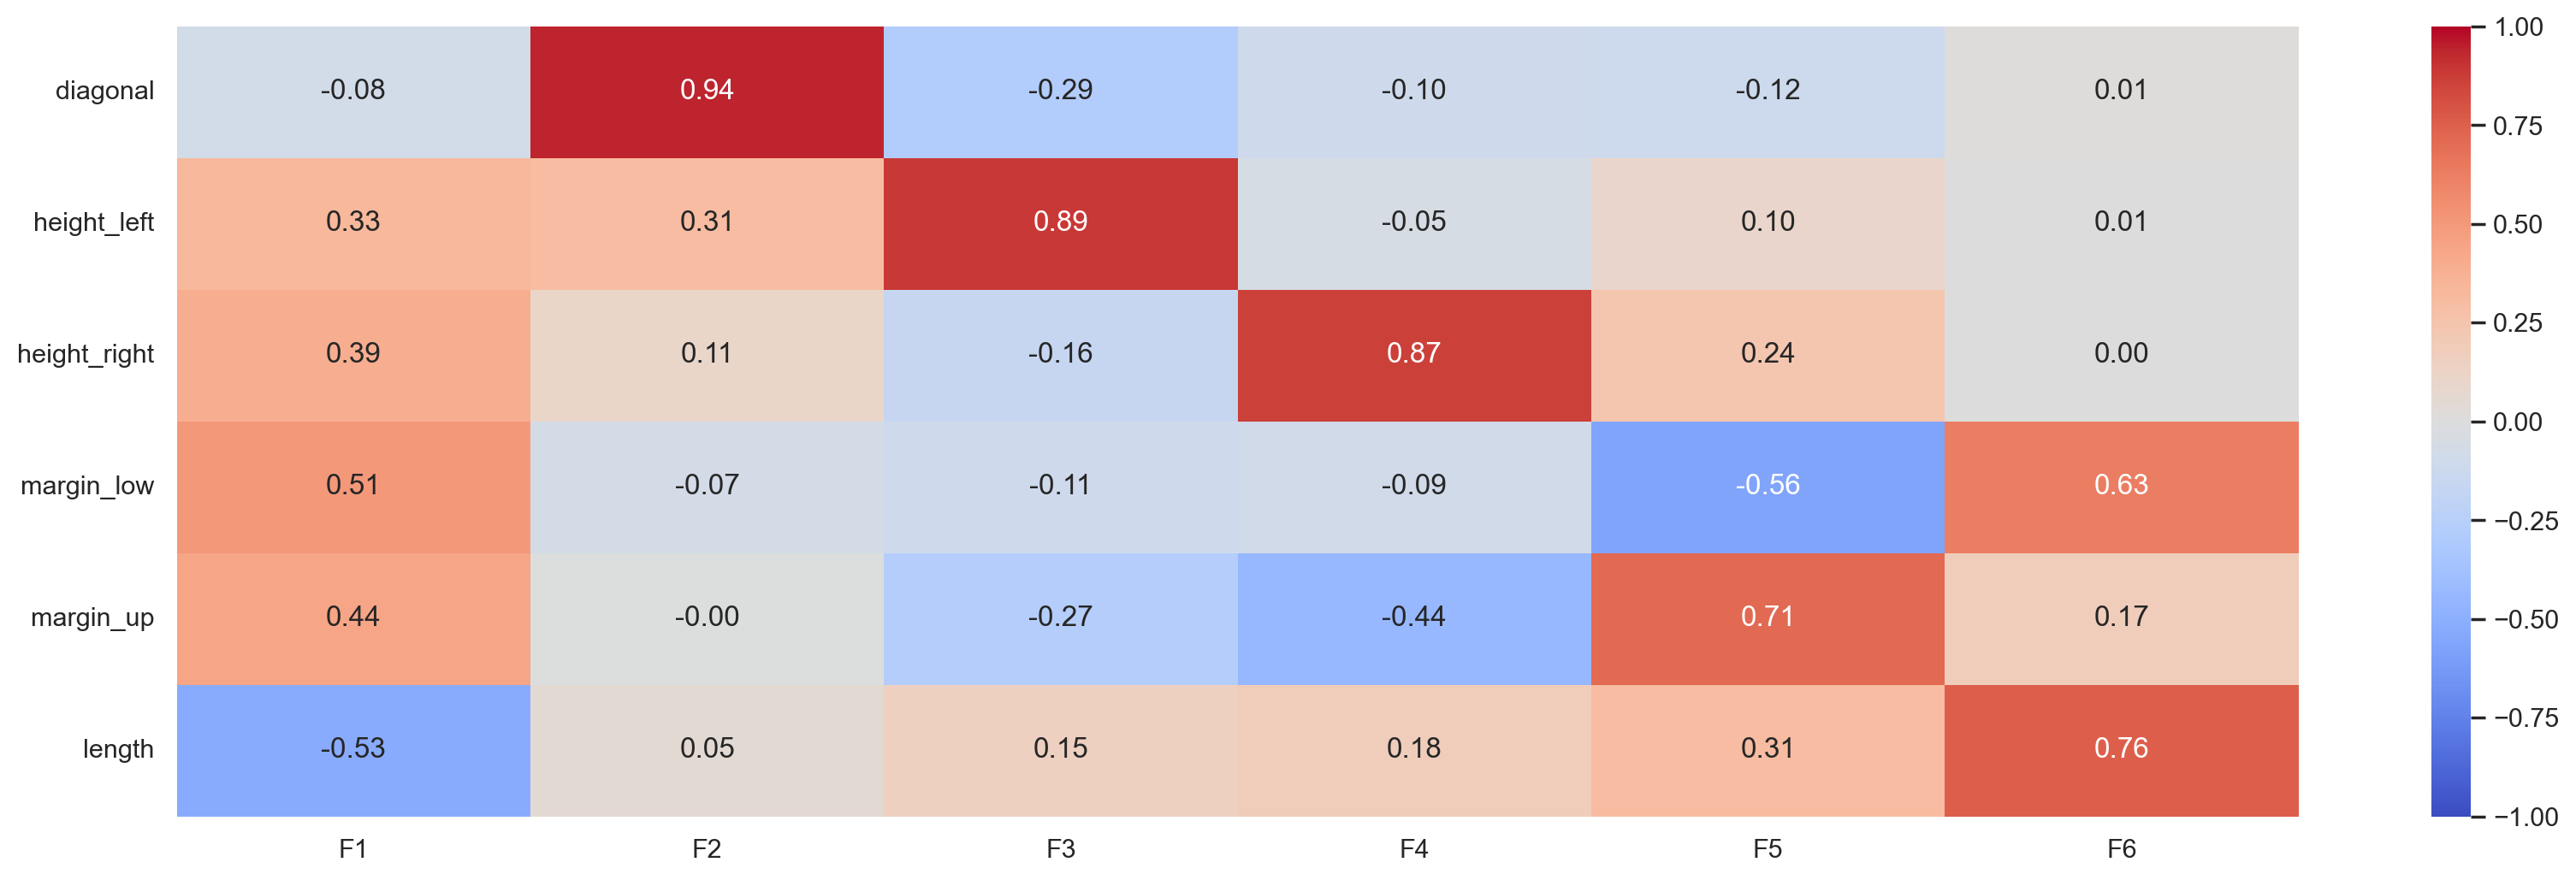

In [748]:
# Le heatmap pour la corrélations des variables avec les composantes principales
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

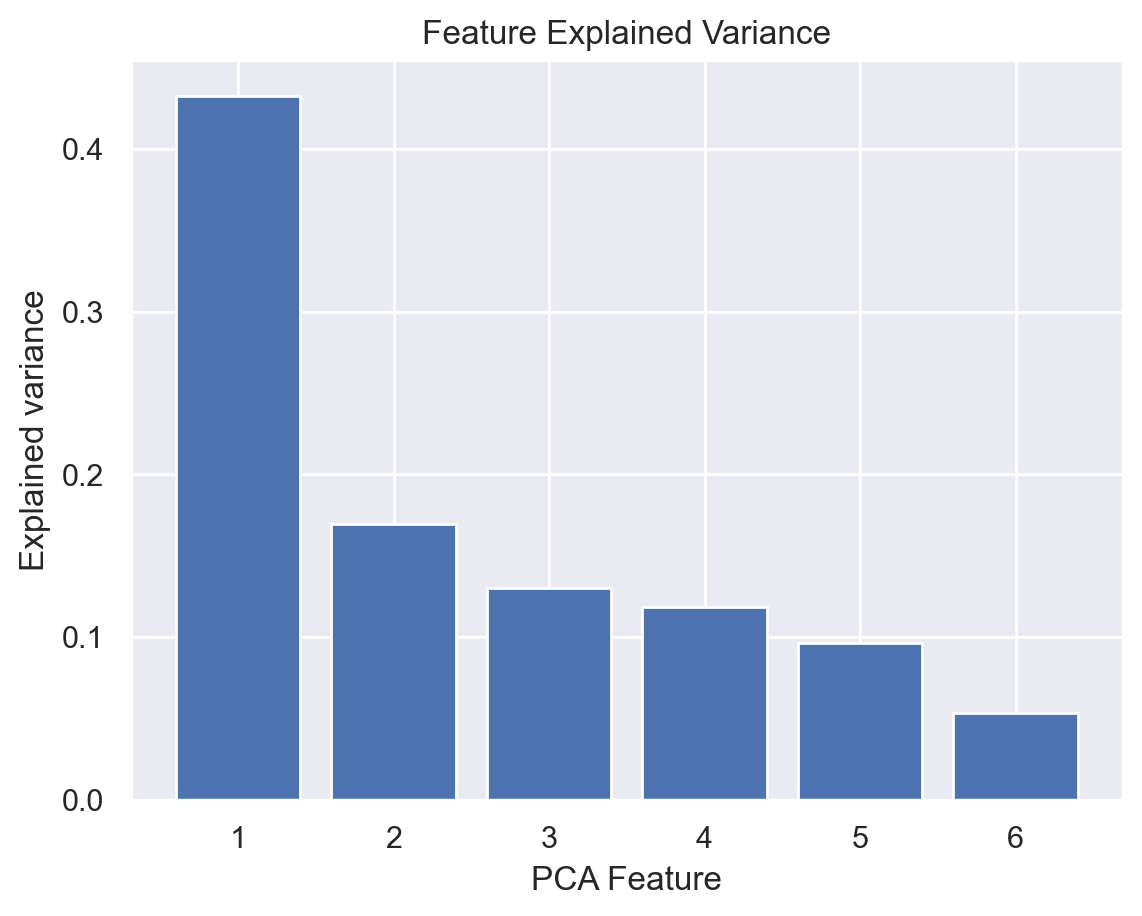

In [749]:
pca2 = PCA(n_components=6)
pca2.fit_transform(X_scaled)
plt.bar(range(1, len(pca2.explained_variance_ratio_)+1),
    pca2.explained_variance_ratio_
)
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [750]:
features_pca = df_tmp_pca.columns.values

In [751]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [752]:
# On affine F1 et F2 
x_y = (0,1)
x_y

(0, 1)

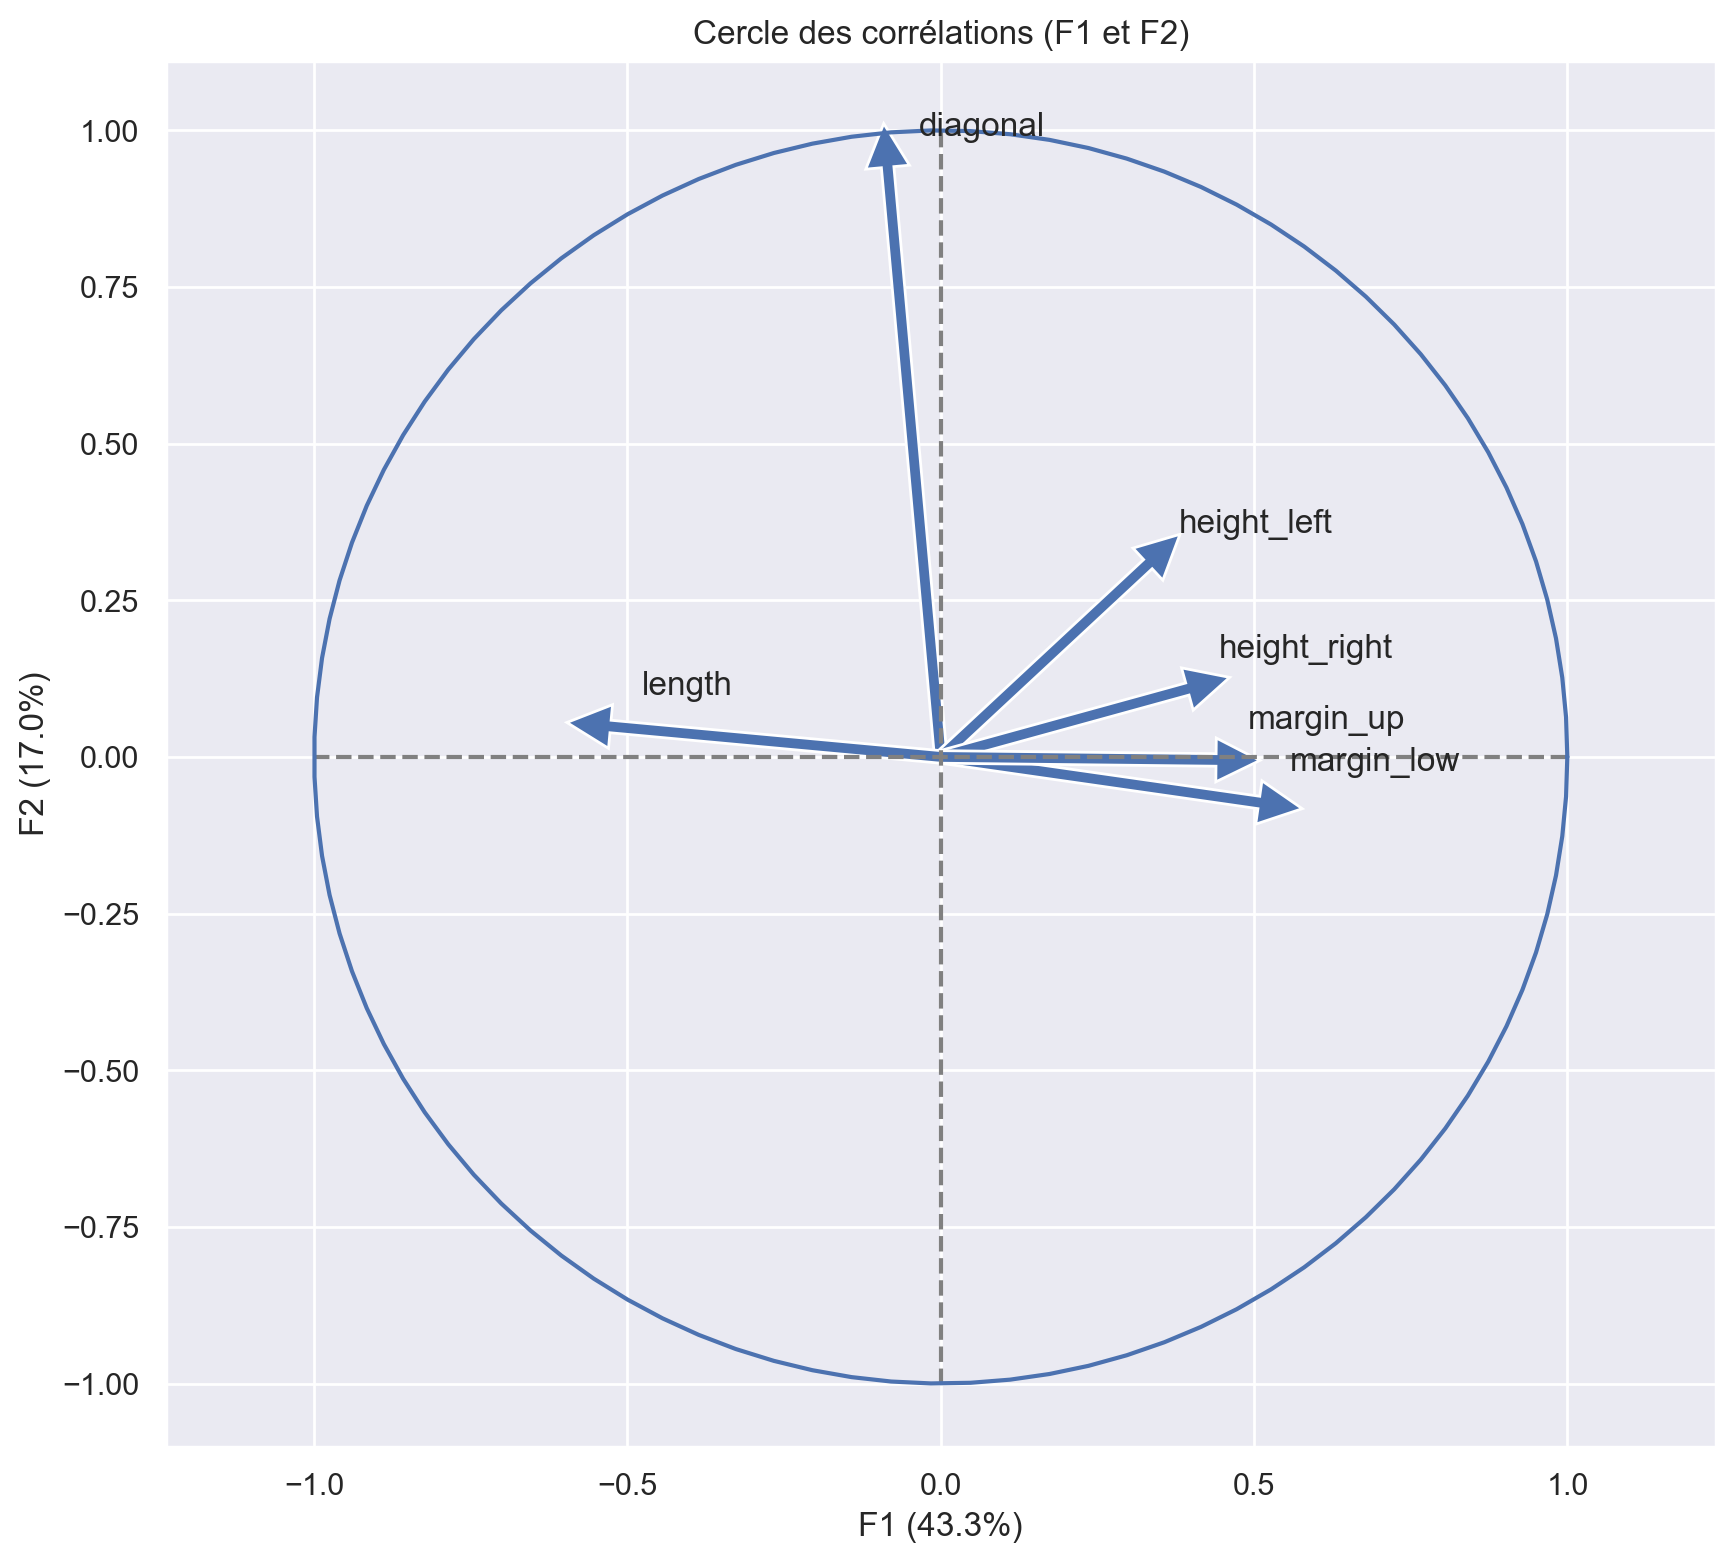

In [753]:
correlation_graph(pca, x_y, features_pca)

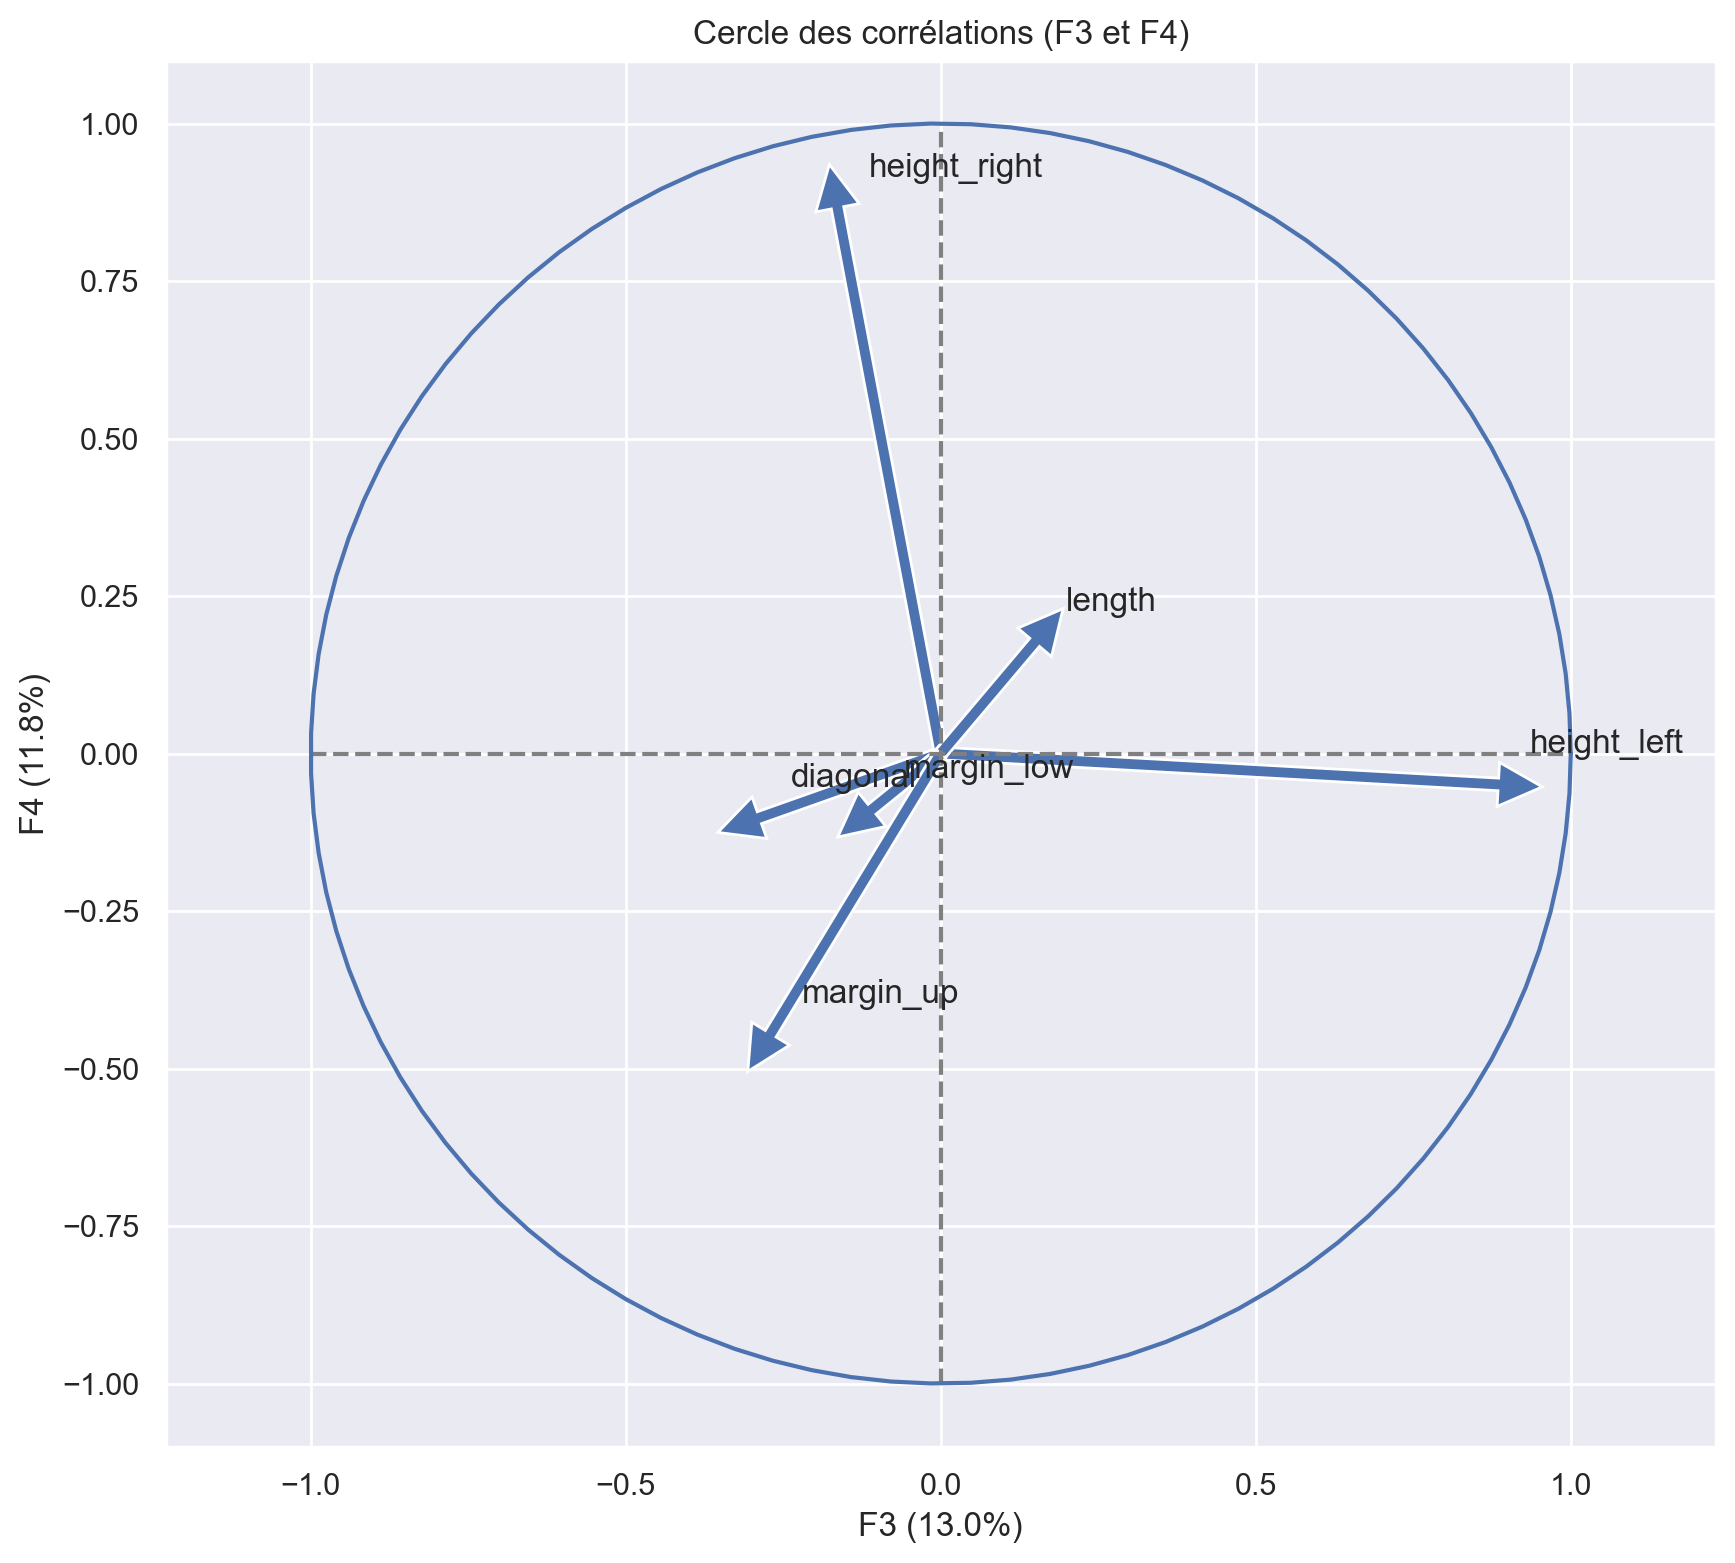

In [754]:
# On affine F3 et F4 
correlation_graph(pca, (2,3), features_pca)

In [755]:
list(range(6, -10,-1))

[6, 5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5, -6, -7, -8, -9]

### Projection des individus 

On va maintenant dessinner le nuage des individus.

In [756]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-7.26707787e-01, -3.34346027e-01, -2.26522429e-01,
        -1.36667579e+00,  1.02314882e-01,  5.64164672e-03],
       [ 4.04552283e-02,  7.17623594e-02,  1.11003713e-01,
         8.07925799e-01,  3.89260458e-01,  2.62918792e-01],
       [-1.74112019e-01,  2.84415122e-01, -8.09636256e-01,
         1.53460115e+00, -5.12069108e-02,  6.41223464e-02],
       [ 1.81569559e-03, -1.94849728e+00, -9.71719012e-01,
        -8.49102436e-01,  1.75908320e+00,  6.94111694e-01],
       [ 4.03706674e-01, -2.70378354e-01,  4.47434778e-01,
         5.61148270e-01, -4.77349583e-01, -2.08181906e-01]])

In [757]:
x_y = (0, 1) # choisir le premier et deuxieme composante (F1 et F2).
x_y

(0, 1)

In [758]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, s=100)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

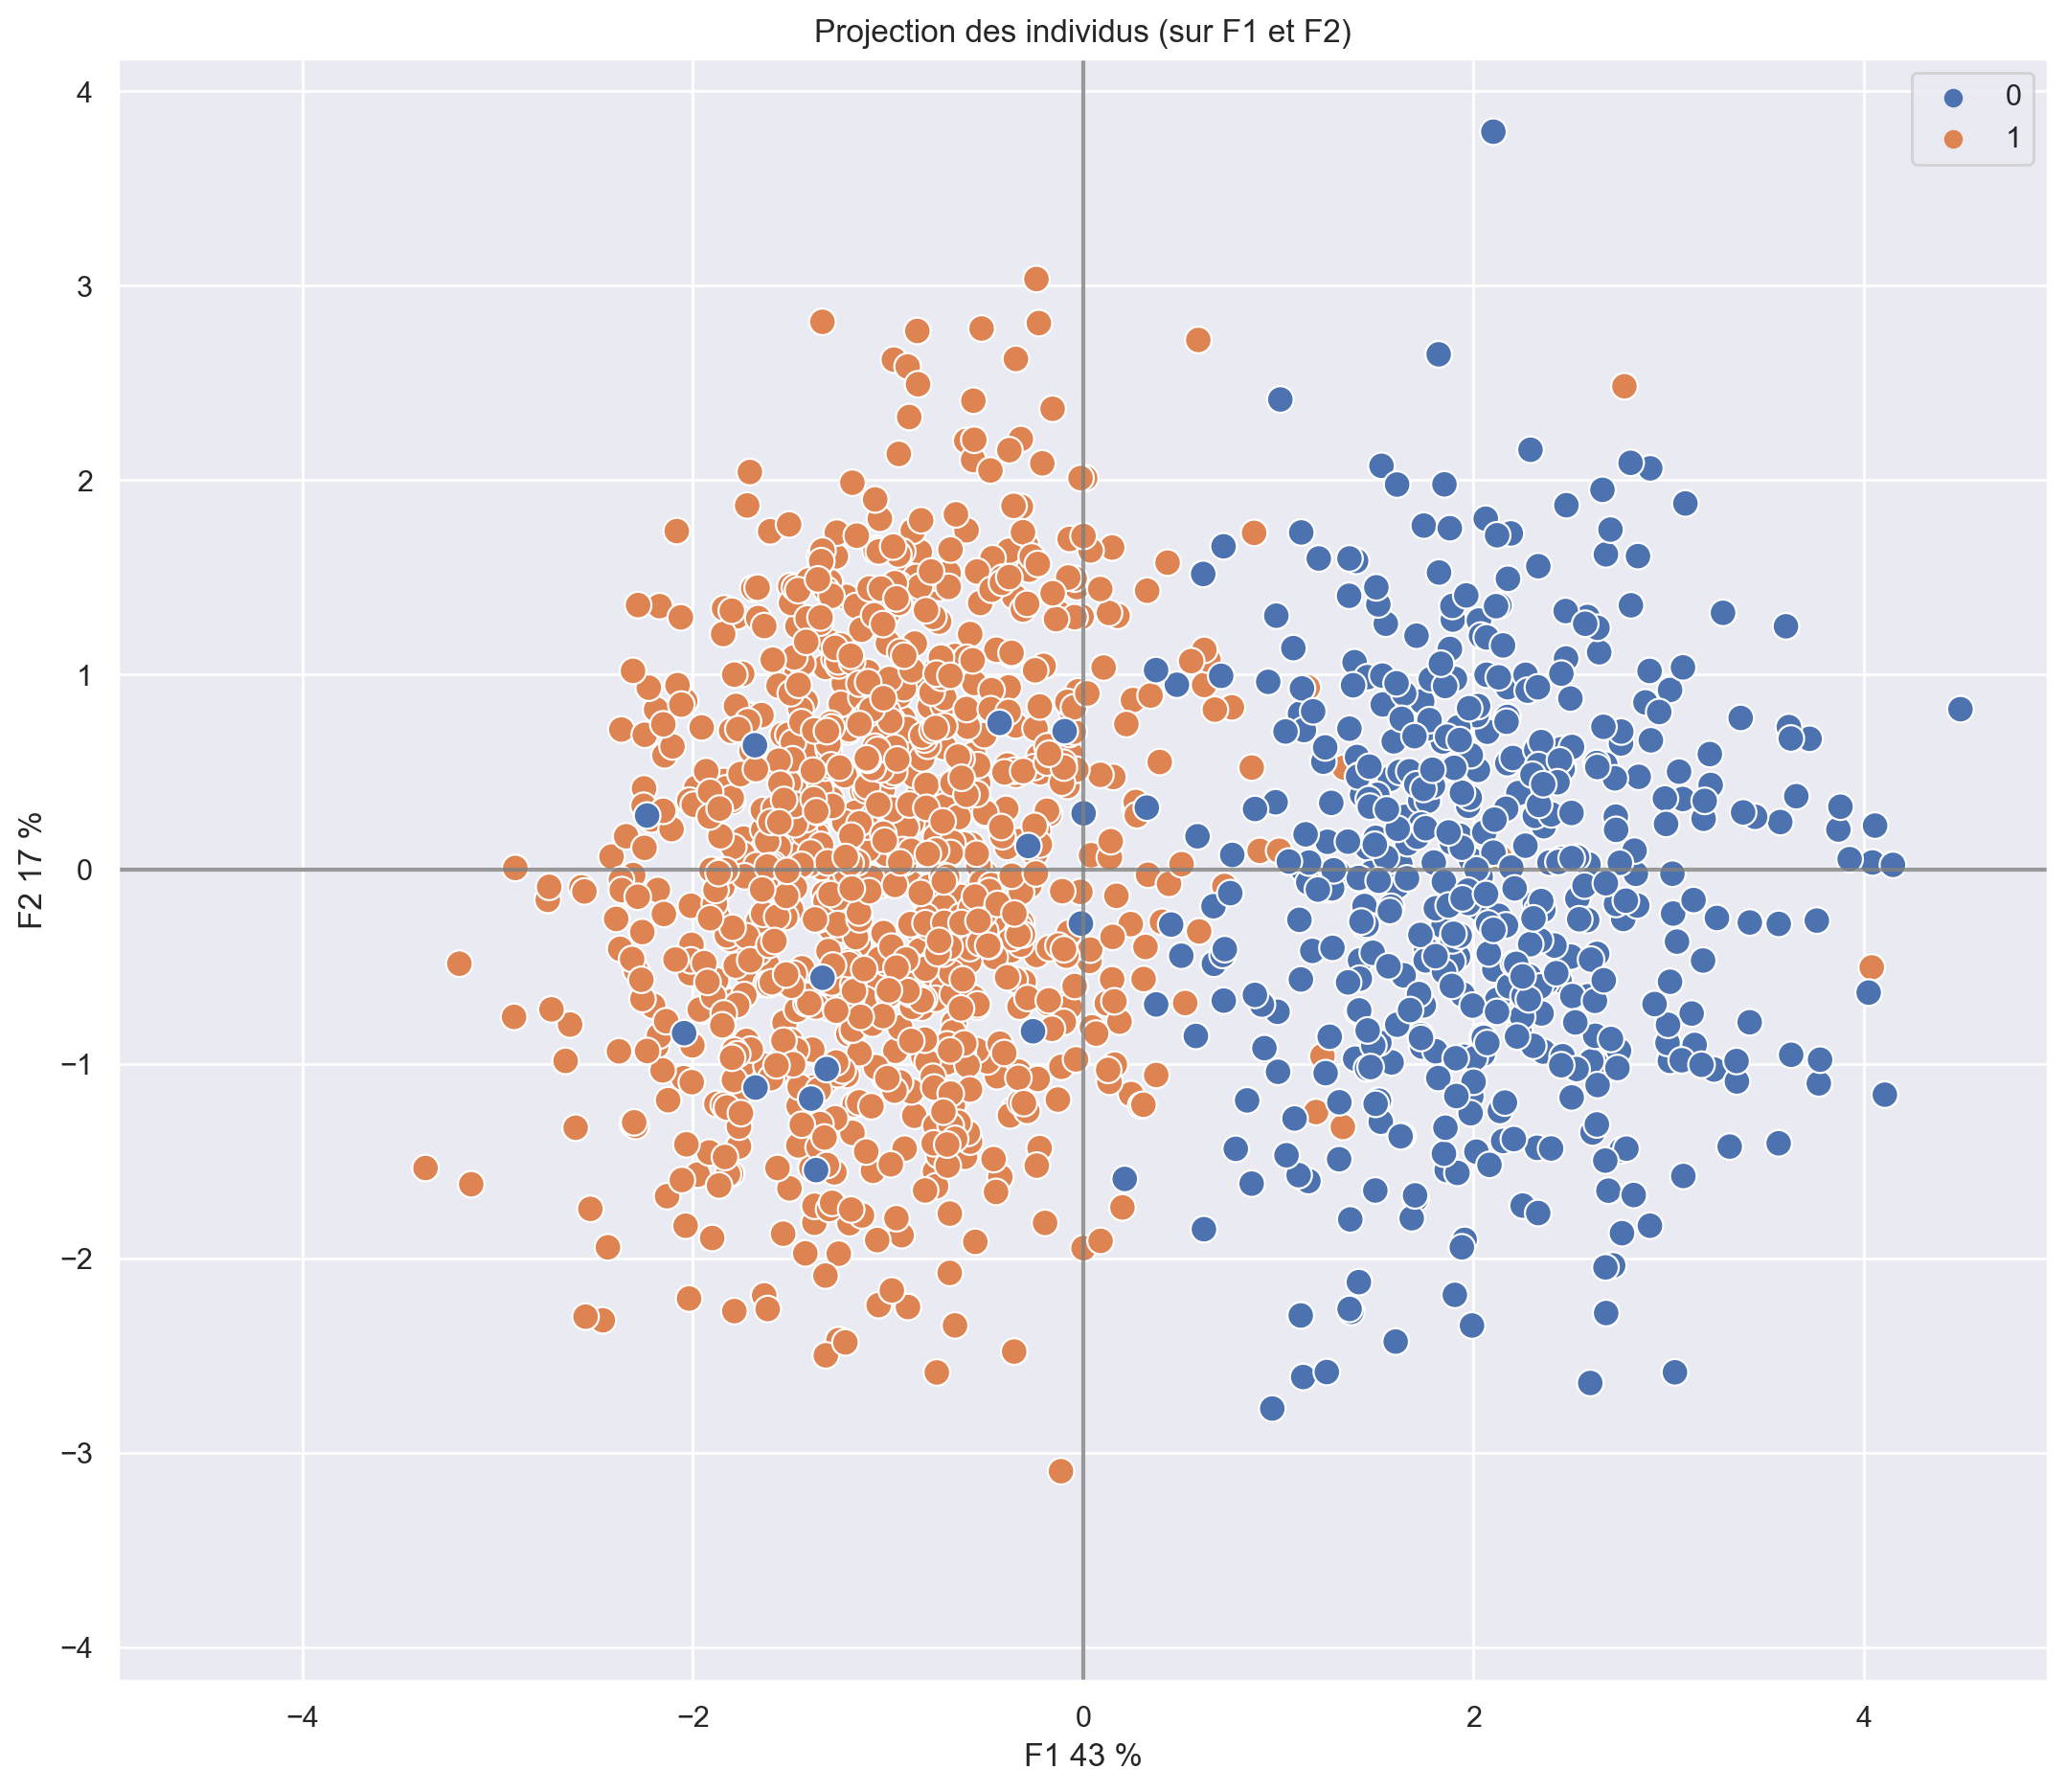

In [759]:
display_factorial_planes(X_proj, x_y, pca, labels=None, figsize=(13,11), clusters=df_billets1.is_genuine.values, marker="o")
#Les points de cinq couleurs représentent cinq groupes de clusters

- La répartition sur les axes d'inerties montrent bien la distinction entre les vrais et les faux billets.
- Quelques points sont mélangés.
    - Il y a plus de billets faux mélangés aux vrais billets que l'inverse.

In [760]:
x_y = (0, 2) # choisir le premier et deuxieme composante (F1 et F3)
x_y

(0, 2)

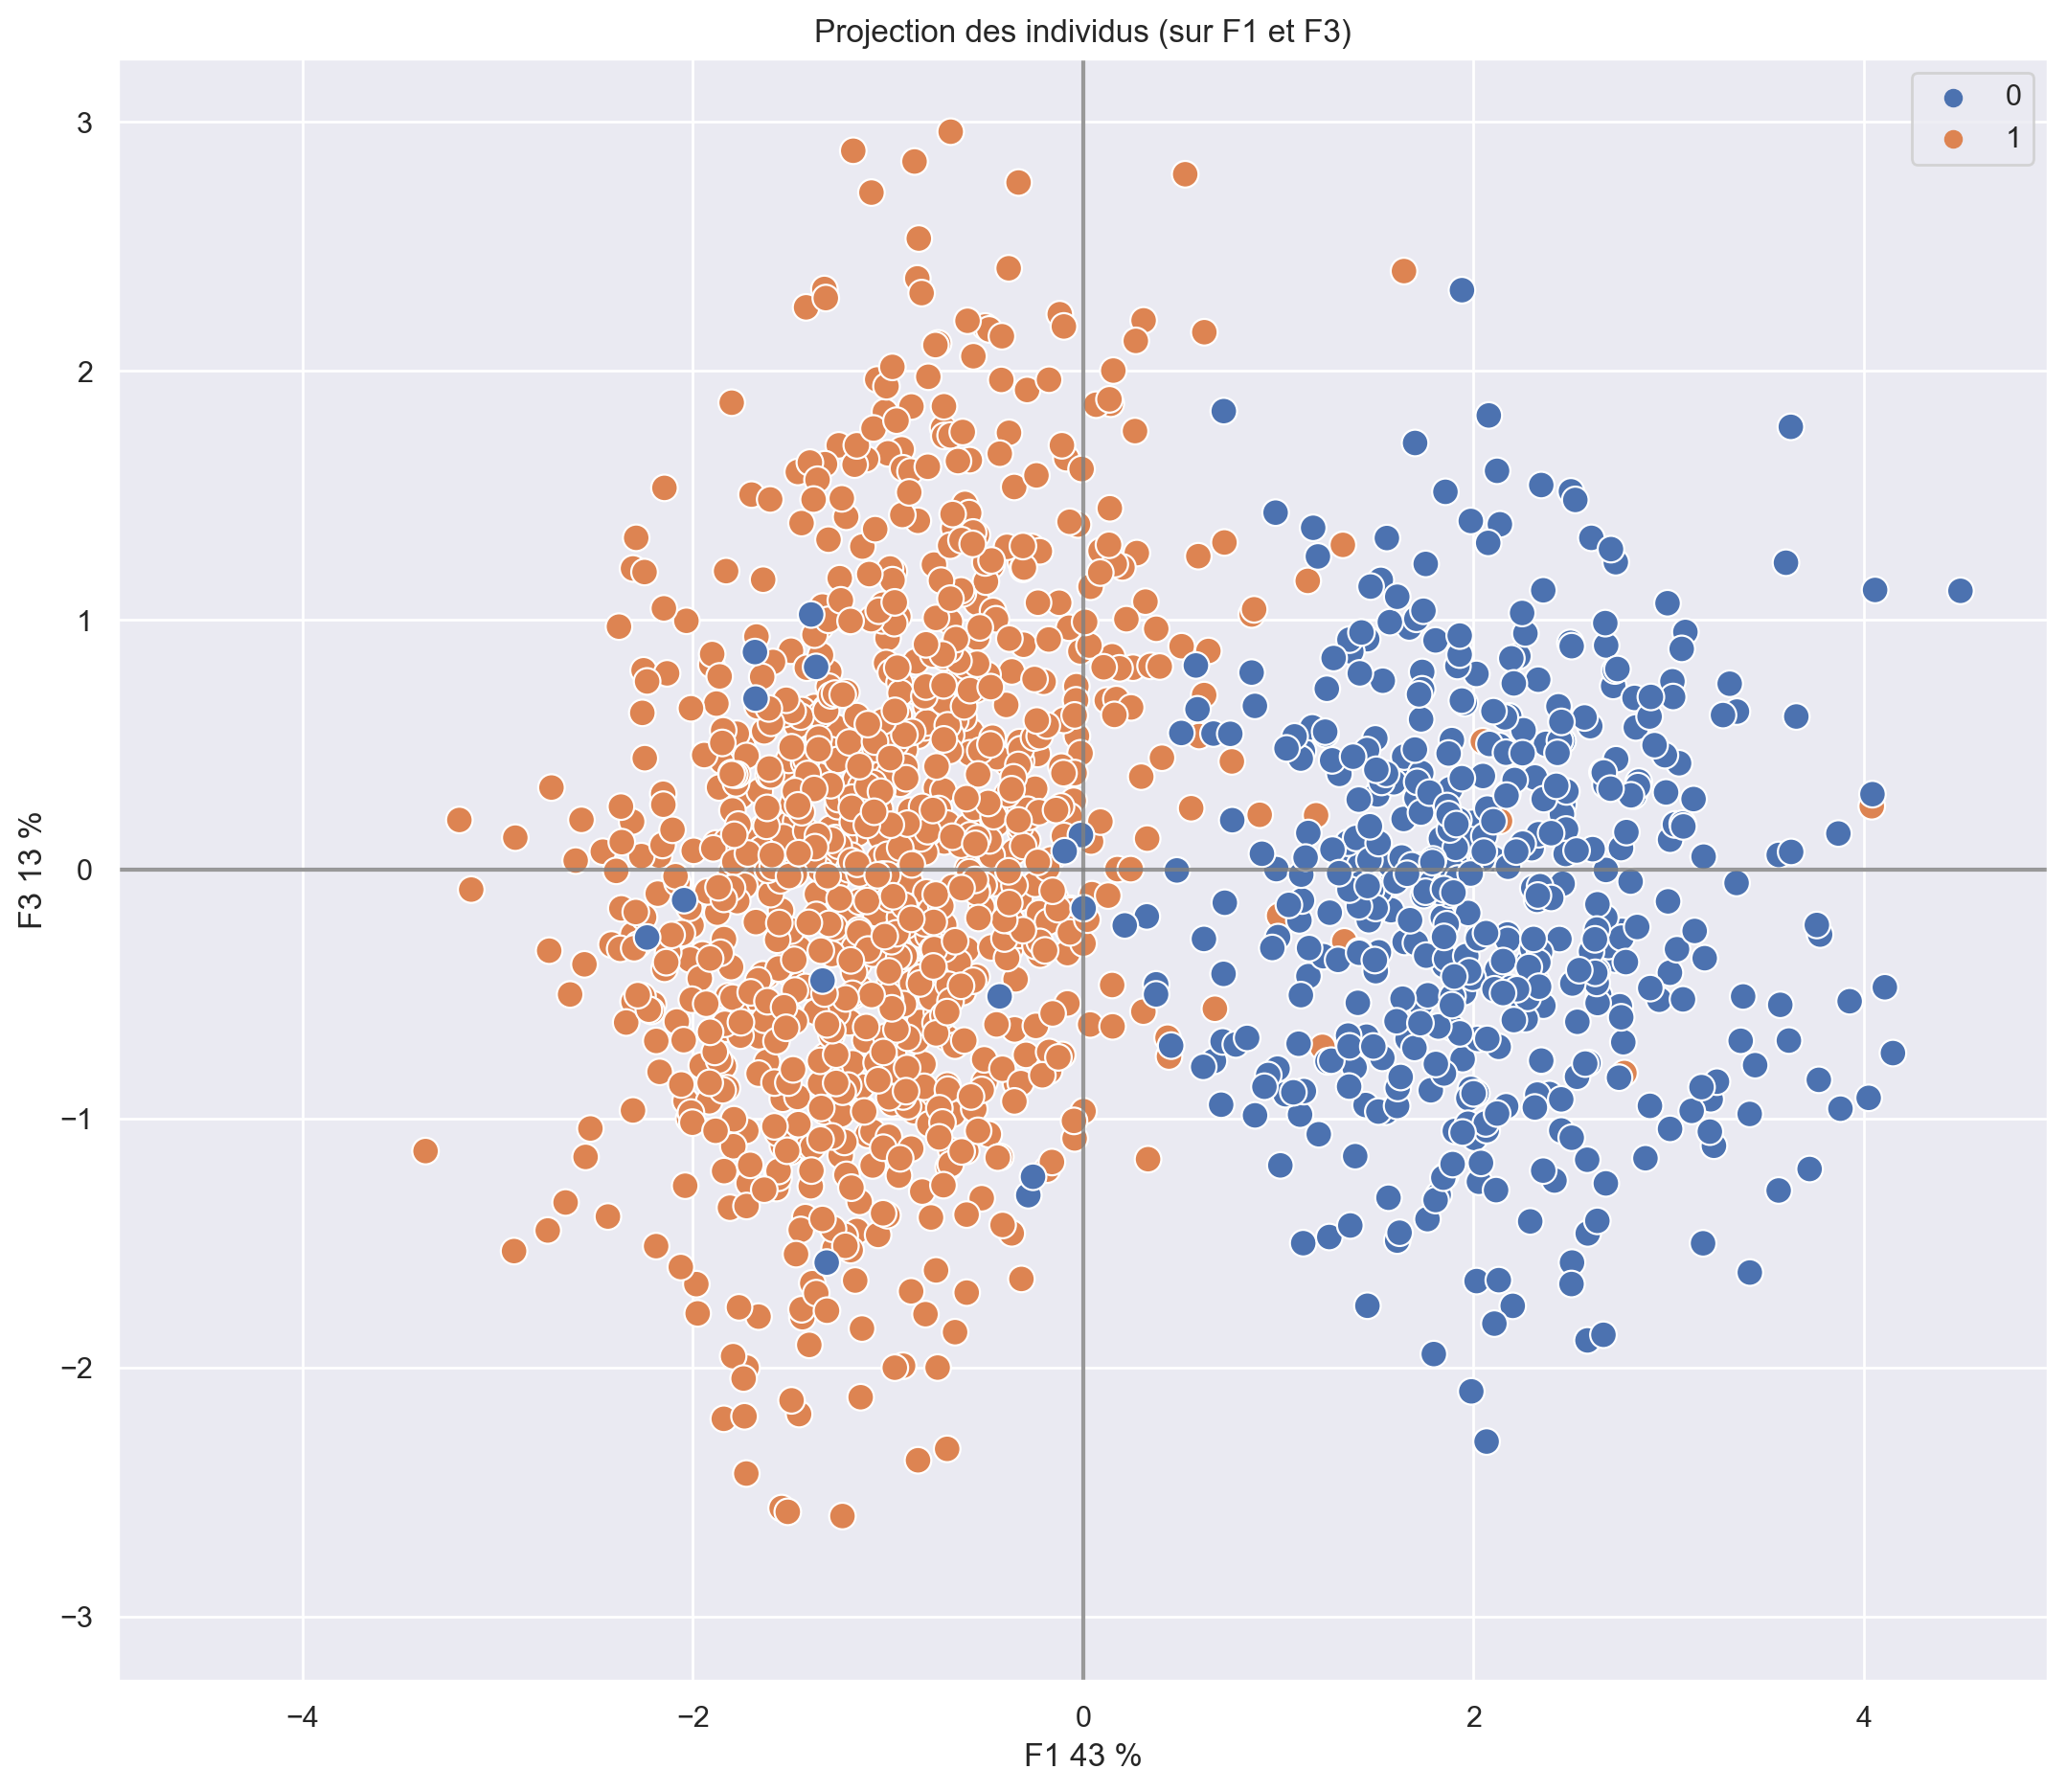

In [761]:
display_factorial_planes(X_proj, x_y, pca, labels=None, figsize=(13,11), clusters=df_billets1.is_genuine.values, marker="o")
#Les points de cinq couleurs représentent cinq groupes de clusters

On observe que les individus sont clairement divisés en deux groupes assez distinctes.
Cependant, on voit que la projection sur les axes d'inertie ne retranscrivent pas parfaitement les modalités (vrai ou faux) de la variable " *is_genuine* ".

# Prediction des faux billets

Nous allons essayer plusieurs modèles de prédiction, et choisir le modèle optimal.

## Algorithme k-means

Dans notre étude nous recherchons à partitionner notre jeu de données en 2 clusters distincts (vrai et faux billets)

In [762]:
tmp3=df_new.loc[:,['diagonal','height_left','height_right','margin_low','margin_up','length']]
y_actual_km = df_new[['is_genuine']]
tmp3.head()

diagonal  height_left  height_right  margin_low  margin_up  length
72     171.94       103.89        103.45    4.316697       3.25  112.79
99     171.93       104.07        104.18    4.403277       3.14  113.08
151    172.07       103.80        104.38    4.426124       3.02  112.93
197    171.45       103.66        103.80    4.331748       3.62  113.27
241    171.83       104.14        104.06    4.657649       3.02  112.36

In [763]:
#Préparation des données pour le clustering K-Means
#Transformation en array Numpy
X_km = tmp3.values

In [764]:
#Centrage / réduction des données (standariser)
std_scale = preprocessing.StandardScaler().fit(X_km)
X_scaled = std_scale.transform(X_km)

In [765]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_actual_km,test_size=0.2,random_state=1)

c:\Users\yutin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yutin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\yutin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yutin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

Text(0.5, 1.0, 'Nombre optimal de Clusters')

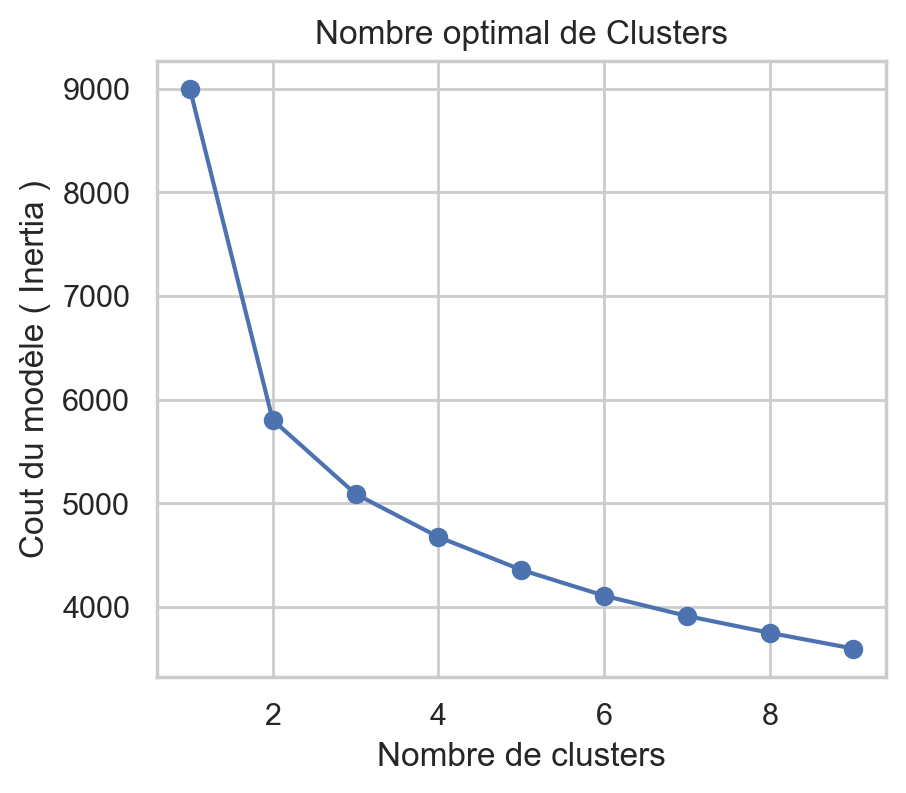

In [766]:
plt.figure(figsize=(16, 4))
sns.set(style="whitegrid")
plt.subplot(1,3,1)
plt.xlabel('A')
#On crée une liste dans laquelle on stocke les inerties 
inertia = []

# On fait une boucle de 2 à 9 pour tester toutes ces possibiliéts
k_range=range(1,10)
for k in k_range:
    #pour chaque k, on crée un modèle et on l’ajuste
    model=KMeans(n_clusters=k).fit(X_scaled)
    #on stocke l’inertie associée
    inertia.append(model.inertia_)

# Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.plot(k_range,inertia, marker='o' )
plt.xlabel('Nombre de clusters')
plt.ylabel('Cout du modèle ( Inertia )')
plt.title("Nombre optimal de Clusters")


Une zone de coude correspondante a 2 clusters

#### Application du modèle

In [767]:
# Nous définissons 2 clusters pour notre modèle et entrainons le sur le jeu d'entrainement
model_km = KMeans(n_clusters=2)
model_km.fit(X_train)
tmp_predicted_groups = model_km.predict(X_train)
tmp_predicted_groups

c:\Users\yutin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yutin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


array([0, 0, 1, ..., 1, 0, 1])

In [768]:
from sklearn.metrics import confusion_matrix
model_km_final = KMeans(n_clusters=2)
model_km_final.fit(X_scaled)
actual_km_final = y_actual_km
pred_km_final = model_km.predict(X_scaled)
confu_matrix_km_final = confusion_matrix(actual_km_final,pred_km_final) 

c:\Users\yutin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yutin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Nous allons maintenant comparer la prediction avec les valeurs originelles.

In [769]:
tmp_comparison_df = pd.DataFrame()
tmp_comparison_df["actual"] = y_train
tmp_comparison_df["predicted_group"] = tmp_predicted_groups
tmp_comparison_df.head()

actual  predicted_group
36         1                0
680        1                0
1302       0                1
532        1                0
767        1                0

K-means étant un algorithme non supervisé, on ne peux pas prevoir les groupes à l'avance. <br>
On constate que l'index du groupe prédit et la valeur de *is_genuine* sont inversés. Donc, nous allons aligner la predicton sur *is_genuine*.
- vrai billet = 1  
- faux billet = 0

In [770]:
# inverser les valeur tel que vrai billet=1 et faux billet=0
predicted_groups_km = 1-tmp_predicted_groups

In [771]:

print('Inertie totale :',model_km.inertia_) #calculer l'inertie

Inertie totale : 4637.316240852976


### Mesures pour évaluer la performance du modèle de K-means

-  La somme des carrés intra-cluster (inertia) 
-  Le coefficient de silhouette

**La somme des carrés intra-cluster (inertia)** 
 - Elle donne une idée de la qualité de la partition en clusters. 
 - Plus l'inertie est faible, mieux la partition est considérée comme étant de qualité.
 
 Ici, on a le résultat d'inertie totale : 4634.70
 
 Pourtant,il est difficile de juger si cette valeur est bonne ou mauvaise. Il est recommandé de comparer cette valeur à celle d'autres modèles K-means pour voir comment elle se situe par rapport à eux.

**Le coefficient de silhouette**
 - c'est un indicateur de qualité de clustering qui mesure à quel point les données d'un cluster sont similaires à celles de son propre cluster par rapport aux autres clusters
 - Plus le coefficient de silhouette est proche de 1, plus les données sont bien regroupées.

In [772]:
# Le coefficient de silhouette
silhouette_score(X_train,predicted_groups_km)

0.3429744979865626

 **La valeur du coefficient de silhouette est entre -1 à 1**: 

 - proche de 1  : la classification est dense et bien séparée 
 - proche de 0  : la classification qui pourrait être améliorée 
 - proche de -1 : une classification incorrecte

Ici, notre valeur est 0.3436. En soi, ce n'est pas suffisant pour determiner si notre modèle est efficace, mais peut etre utilisé pour comparer d'autres modeles k-means.

### Matrice de confusion (k-means)

    La matrice de confusion est un outil utilisé pour évaluer les modèles de classification supervisée.
Comme le K-means est un algorithme de clustering non supervisé qui ne prévoit pas de labels de classe.
Cependant, dans notre cas, les clusters générés par k-means peuvent correspondent à la variable qu'on souhaite prédire ( *is_genuine* ).
- Un cluster correspond aux vrais billets
- Un autre cluster correspond aux faux billets

Donc, on peut utiliser une matrice de confusion pour comparer les prédictions avec les valeurs réélles (actual values).



On vérifie la prédiction avec les données de test

In [773]:
predicted_groups_test_km =  1 - model_km.predict(X_test)
confu_matrix_test_km = confusion_matrix(y_test,predicted_groups_test_km) 
confu_matrix_test_km

array([[ 96,   2],
       [  3, 199]], dtype=int64)

<Axes: >

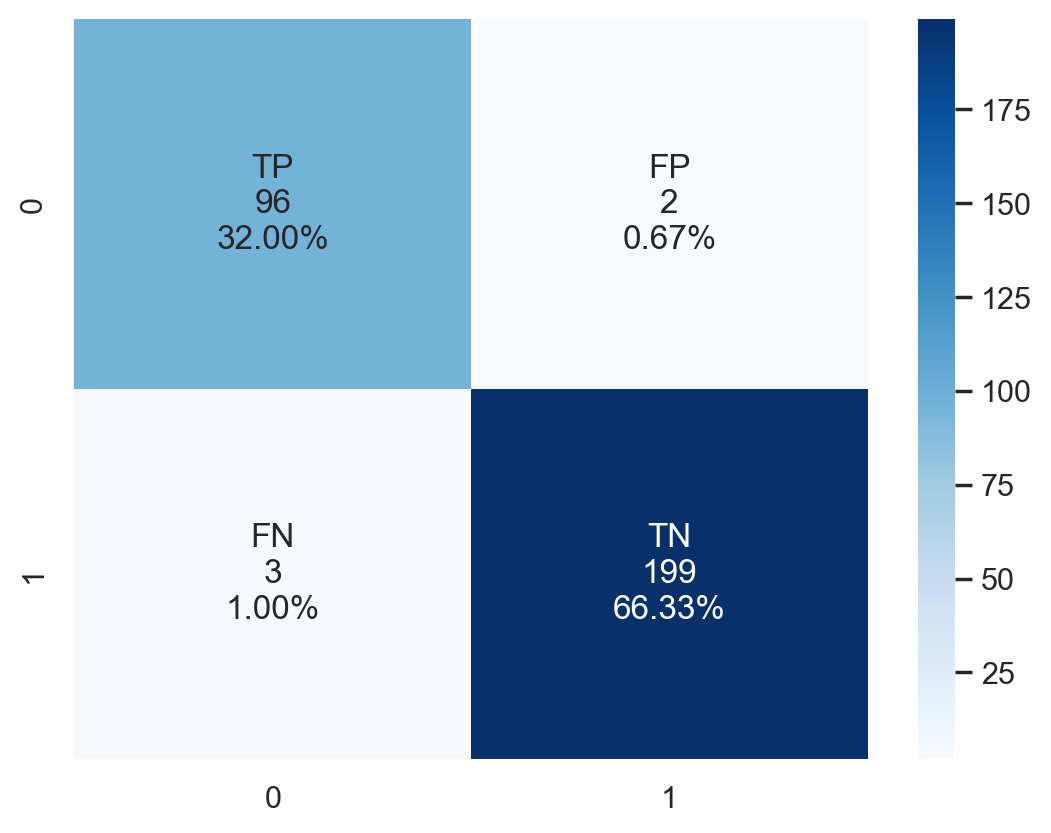

In [774]:
group_name = ['TP','FP','FN','TN']
group_counts = ["{}".format(value) for value in confu_matrix_test_km.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confu_matrix_test_km.flatten()/np.sum(confu_matrix_test_km)]

labels_km = [f"{v1}\n{v2}\n{v3}" for v1,v2,v3 in zip(group_name,group_counts,group_percentages)]

labels_km = np.asarray(labels_km).reshape(2,2)

sns.heatmap(confu_matrix_test_km,annot=labels_km, fmt='',cmap= 'Blues')  #scientific notation change : fmt = 'd'(int)

- **Sensibilité** : Taux de positif prédit comme positif 
- **Spécificité** : Taux de négatifs prédit comme négatif

In [775]:
tp = confu_matrix_test_km[0,0]
fp = confu_matrix_test_km[0,1]
fn = confu_matrix_test_km[1,0]
tn = confu_matrix_test_km[1,1]

sensibility = tp/(tp+fn) 
specificity = tn/(tn+fp)

print("sensibility:", sensibility)
print("specificity:", specificity)

sensibility: 0.9696969696969697
specificity: 0.9900497512437811


## Algorithme K-NN (k Nearest Neighbors)

Nous allons constuire un modèle de prédiction avec l'algorthme K-NN.

In [776]:
tmp3=df_new.loc[:,['diagonal','height_left','height_right','margin_low','margin_up','length']]
tmp3.head()

diagonal  height_left  height_right  margin_low  margin_up  length
72     171.94       103.89        103.45    4.316697       3.25  112.79
99     171.93       104.07        104.18    4.403277       3.14  113.08
151    172.07       103.80        104.38    4.426124       3.02  112.93
197    171.45       103.66        103.80    4.331748       3.62  113.27
241    171.83       104.14        104.06    4.657649       3.02  112.36

In [777]:
X_knn = tmp3.values
y_actual_knn = df_new['is_genuine']

In [778]:
# Création d'un objet de la classe StandardScaler
scaler = StandardScaler()

# Centrer et réduire les données
X_scaled_knn = scaler.fit_transform(X_knn)

On fait les donnees dans traning set et testing set

In [779]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_knn, y_actual_knn,test_size=0.2,random_state=1)

In [780]:
knn_model = KNeighborsClassifier(n_neighbors=2,p=2,weights='distance',algorithm='auto') # n_neighbors =5是K值的預設值 # p=2 歐基里德距離 # weight權重 = distance表示採用加權的距離
knn_model.fit(X_train, y_train)  # n neightbors最好是基數(K值為基數最佳),我們加入weight加權的的話可以幫助該點依靠權重分類

KNeighborsClassifier(n_neighbors=2, weights='distance')

In [781]:
knn_model.score(X_test,y_test)
# 1表示係數吻合 perfect fitting

0.9833333333333333

Trouver le bon nombre de voisins (K)

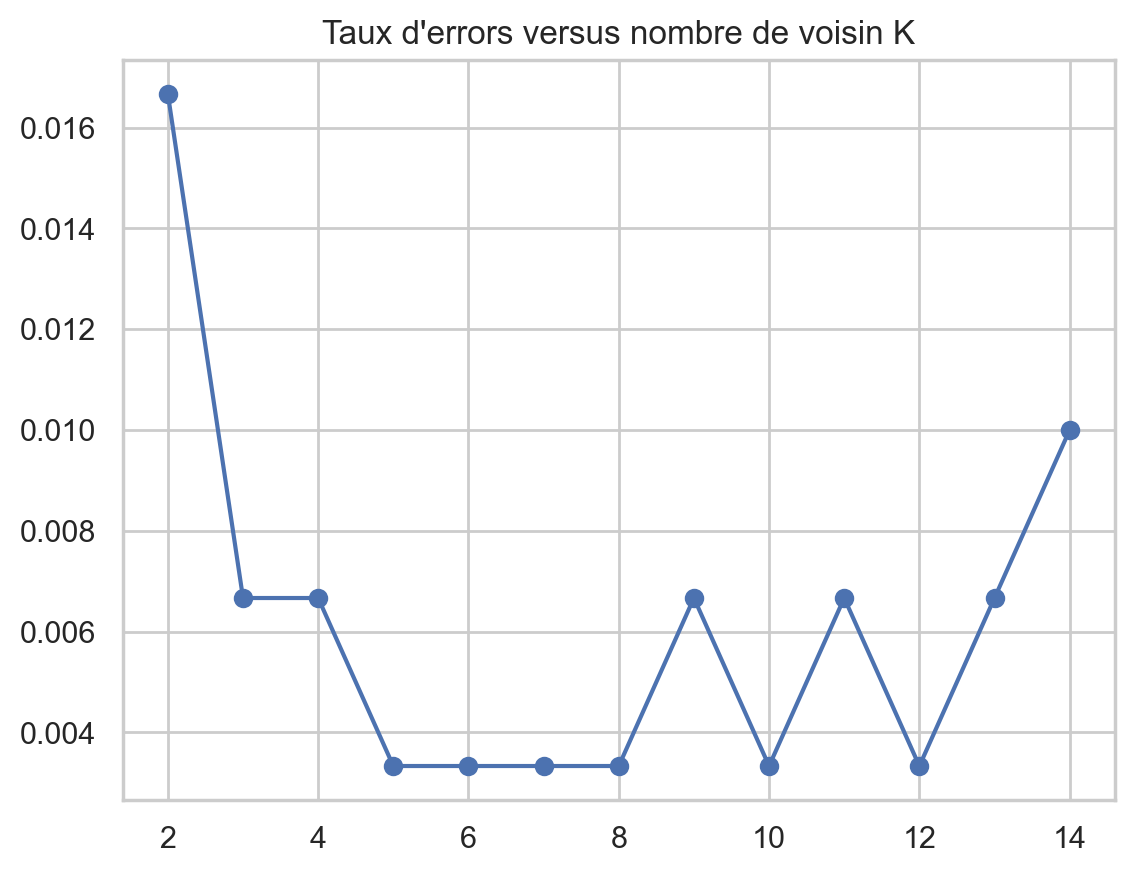

In [782]:
# Optimisation du score sur les données test
errors = []
for k in range(2, 15):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    errors.append(np.mean(y_pred !=y_test))
plt.plot(range(2, 15), errors, 'o-')
plt.title('Taux d\'errors versus nombre de voisin K')
plt.show()

D'après le graphique, pour minimiser le taux d'erreurs, on peut utiliser k = 5.

On refait le modèle avec 5 k

In [783]:
knn_model = KNeighborsClassifier(n_neighbors=5,p=2,weights='distance',algorithm='auto') # n_neighbors =5是K值的預設值 # p=2 歐基里德距離 # weight權重 = distance表示採用加權的距離
knn_model.fit(X_train, y_train)  

KNeighborsClassifier(weights='distance')

In [784]:
knn_model.score(X_test,y_test)
# 1表示係數吻合 perfect fitting

0.9933333333333333

Le score est en effet meileur avec 5 K au lieu de 2.

## Mesures pour évaluer la performance du modèle de K-NN

Plusieurs mesures que l'on peut utiliser: 

-  **Accuracy (exactitude)**
    - calcul de nombre de prédictions correctes par rapport au nombre total d'observations (la mesure la plus courante)
    
-  **Matrice de confusion (confusion matrix)**
    -  Visualise le nombre de vrais positifs / vrais négatifs / faux positifs / faux négatifs
    -  On peut aussi dériver d'autres mesures :
        - Sensibilité (recall): taux de positif prédit comme positif 
        - Spécificité : taux de négatifs prédit comme négatif
        - Précision : mesure la proportion de vrais positifs parmi les observations classsées positives 
        - F1-score : moyenne harmonique de la précision et du rappel
            
-  **Courbe ROC (receiver operating characteristic)**
    -  Mesurer le taux de vrais positifs (true positive rate) par rapport au taux de faux positifs (false positive rate) pour différents seuils de classification

-  **Mesure de distance (distance metric)**
    -  Mesurer la qualité des regroupements effectués par le modèle en utilisant des distances entre les points <br>
    -  la distance euclidienne / Manhattan / Chebychev

-  **Validation croisée (cross-validation)**
    -  En utilisant plusieurs échantillons de données différents pour évaluer
    -  Réduire les biais

### Matrice de confusion (k-nn)

    La matrice de confusion est un outil utilisé pour évaluer les modèles de classification supervisée.

In [785]:
confu_matrix_knn = confusion_matrix(y_test,knn_model.predict(X_test)) 
confu_matrix_knn

array([[ 97,   1],
       [  1, 201]], dtype=int64)

<Axes: >

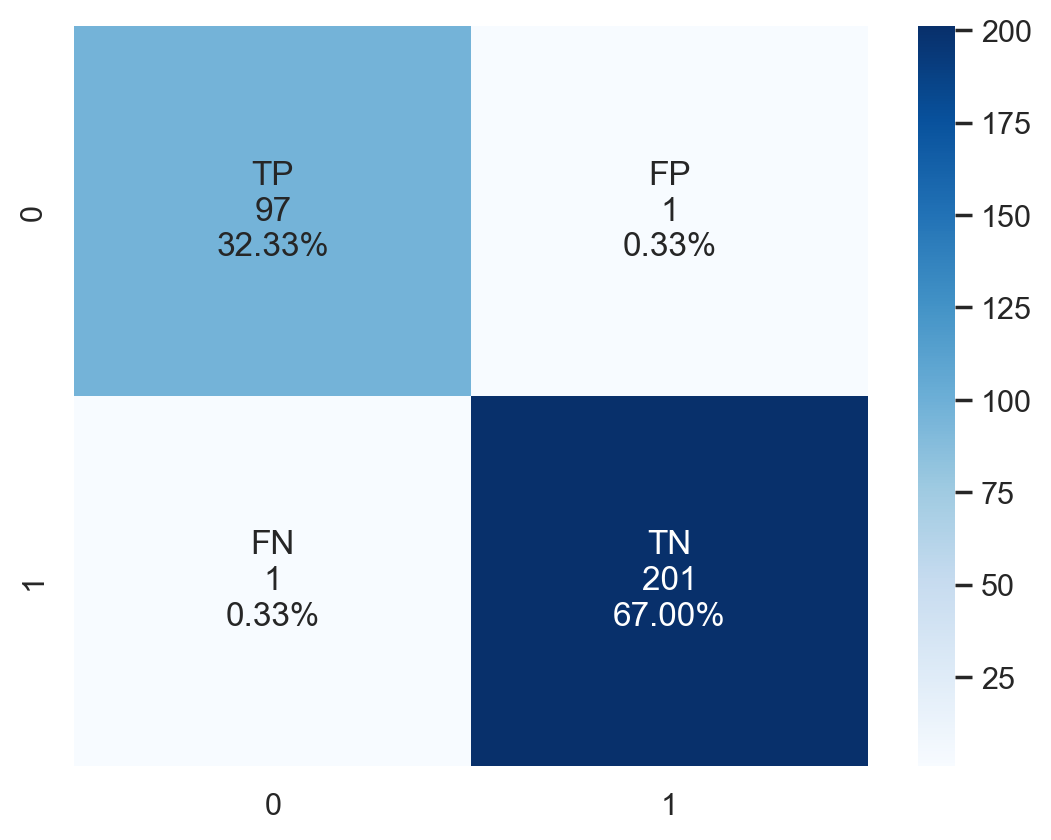

In [786]:
group_name = ['TP',  'FP', 'FN', 'TN']
group_counts = ["{}".format(value) for value in confu_matrix_knn.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confu_matrix_knn.flatten()/np.sum(confu_matrix_knn)]

labels_knn = [f"{v1}\n{v2}\n{v3}" for v1,v2,v3 in zip(group_name,group_counts,group_percentages)]

labels_knn = np.asarray(labels_knn).reshape(2,2)

sns.heatmap(confu_matrix_knn,annot=labels_knn, fmt='',cmap= 'Blues')  #scientific notation change : fmt = 'd'(int)

- **Sensibilité** : Taux de positif prédit comme positif 
- **Spécificité** : Taux de négatifs prédit comme négatif

In [787]:
# sensibility (recall | rappel)
sensibility = recall_score(y_test, y_pred)
print('sensibility :', sensibility)

sensibility : 0.995049504950495


In [788]:
# specificity
tp = confu_matrix_knn[0,0]
fp = confu_matrix_knn[0,1]
fn = confu_matrix_knn[1,0]
tn = confu_matrix_knn[1,1]

specificity = tn/(tn+fp)

print("specificity:", specificity)

specificity: 0.995049504950495


In [789]:
# precision
y_pred = knn_model.predict(X_test)
precision = precision_score(y_test, y_pred)
print('precision :', precision)

precision : 0.995049504950495


On calcule le F1 score avec la formule

In [790]:
# On calcule le F1 score avec la formule
F1_score = 2*(precision * sensibility) / (precision + sensibility)
F1_score

0.995049504950495

On verifie avec la fonction f1_score()

In [791]:
# F1 score
y_pred = knn_model.predict(X_test)
f1_score(y_test, y_pred)

0.995049504950495

### Algorithme de régression logistique 

In [792]:
X_features_names_final = ['diagonal','height_left','height_right','margin_low','margin_up','length']

X_reglog_final = df_new[X_features_names_final] # predictors
y = df_new['is_genuine'].values # predicted

On prepare les données à la même échelle(standardisation) pour réduire les biais et rendre le modèle plus stable.

In [793]:
# Centrer/reduire les parametres
std_scale = preprocessing.StandardScaler().fit(X_reglog_final)
X_reglog_final_scaled = std_scale.transform(X_reglog_final)

In [794]:
X_reglog_final.shape

(1500, 6)

Logit(Odds) = 1n(p/(1-p))=w_0+w_1 X

In [795]:
tmp = X_features_names_final.copy()
tmp.append("is_genuine") # ajouter X derriere
tmp

['diagonal',
 'height_left',
 'height_right',
 'margin_low',
 'margin_up',
 'length',
 'is_genuine']

In [796]:
# On refait un dataframe avec les données standardisées
df_reglog_with_scaled_X = pd.DataFrame(X_reglog_final_scaled, columns=X_features_names_final)
df_reglog_with_scaled_X["is_genuine"] = y

In [797]:
df_reglog_with_scaled_X

diagonal  height_left  height_right  margin_low  margin_up    length  \
0    -0.060441    -0.466103     -1.444792   -0.253132   0.425168  0.127803   
1    -0.093217     0.135176      0.797784   -0.121829  -0.049510  0.460204   
2     0.365659    -0.766742      1.412188   -0.087182  -0.567341  0.288272   
3    -1.666506    -1.234404     -0.369585   -0.230307   2.021814  0.677984   
4    -0.420986     0.369007      0.429141    0.263936  -0.567341 -0.365069   
...        ...          ...           ...         ...        ...       ...   
1495 -0.683201     1.170713      0.767063   -0.096468  -0.265273 -1.602978   
1496  0.758981     2.005822      1.596509    1.192594   0.942999 -1.958303   
1497 -0.519316    -0.065250      0.613462    1.556564   0.899846 -0.835016   
1498  0.332882     0.836669      0.429141    1.040939   1.331372 -0.491152   
1499 -1.600953     0.402412     -0.308144    0.222006   0.942999 -0.697470   

      is_genuine  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
1495           0  
1496           0  
1497           0  
1498           0  
1499           0  

[1500 rows x 7 columns]

In [798]:
import statsmodels.api as sm
# use the families module
family = families.Binomial()

# On fait d'abord le modele  avec le module de stats, pour avoir un summary plus détaillé.
model_reglog_from_stats = smf.glm('is_genuine ~ diagonal + height_left + height_right + margin_low + margin_up + length', data=df_reglog_with_scaled_X, family=sm.families.Binomial()).fit()
print(model_reglog_from_stats.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1493
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -42.481
Date:                Tue, 09 May 2023   Deviance:                       84.962
Time:                        22:22:40   Pearson chi2:                 2.63e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7037
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.2684      0.365      6.218   

In [799]:
model_reglog_from_stats2 = smf.glm('is_genuine ~ height_left + height_right + margin_low + margin_up + length', data=df_reglog_with_scaled_X, family=sm.families.Binomial()).fit()
print(model_reglog_from_stats2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1494
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -42.483
Date:                Tue, 09 May 2023   Deviance:                       84.966
Time:                        22:22:40   Pearson chi2:                 2.63e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7037
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.2690      0.365      6.222   

In [800]:
model_reglog_from_stats3 = smf.glm('is_genuine ~ height_right + margin_low + margin_up + length', data=df_reglog_with_scaled_X, family=sm.families.Binomial()).fit()
print(model_reglog_from_stats3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1495
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43.744
Date:                Tue, 09 May 2023   Deviance:                       87.487
Time:                        22:22:41   Pearson chi2:                 3.20e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7032
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.2584      0.358      6.305   

Donc les variables plus significatives sont *height_right*, *margin_low*, *margin_up* et *length*. 
On va utiliser ces 4 variables pour faire notre modèle de la prédiction.

In [801]:
new_features_names = ['height_right','margin_low','margin_up','length']

# Centrer/reduire les parametres
# Cette fois-ci, seulement avec les params qui nous interessent.
std_scale = preprocessing.StandardScaler().fit(X_reglog_final[new_features_names])

df_reglog_with_scaled_X2 =std_scale.transform(X_reglog_final[new_features_names])
df_reglog_with_scaled_X2

array([[-1.44479235, -0.25313193,  0.42516803,  0.12780265],
       [ 0.79778359, -0.12182943, -0.0495104 ,  0.46020417],
       [ 1.41218796, -0.08718171, -0.56734141,  0.28827235],
       ...,
       [ 0.61346228,  1.55656401,  0.89984645, -0.83501554],
       [ 0.42914097,  1.0409392 ,  1.33137229, -0.4911519 ],
       [-0.30814427,  0.22200567,  0.94299904, -0.69747008]])

In [802]:
# On separe les données train/test
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_reglog_with_scaled_X2,y, test_size =0.2, random_state = 1)

### Modélisation finale de regression logistique

In [803]:
# On entraine notre modèle
model_reglog_final = linear_model.LogisticRegression()
model_reglog_final.fit(X_train2,y_train2)

LogisticRegression()

In [804]:
# actual données
actual_y = y_test2 # predicted y的數據shape必須和predictor x 的大小一樣才能做
# prédiction sur les données de test.
predicted_y = model_reglog_final.predict(X_test2)  
confu_matrix_reglog_final = confusion_matrix(actual_y,predicted_y) 

In [805]:
predicted = model_reglog_final.predict(X_test2)

df_compare = pd.DataFrame()
df_compare["actual_value"] = actual_y
df_compare["predicted"] = predicted_y

In [806]:
df_compare

actual_value  predicted
0               1          1
1               1          1
2               0          0
3               1          1
4               0          0
..            ...        ...
295             0          0
296             0          0
297             0          0
298             1          1
299             1          1

[300 rows x 2 columns]

### Mesures pour évaluer la performance du modèle de regression logistique

Plusieurs mesures que l'on peut utiliser: 

-  **Matrice de confusion (confusion matrix)**
    -  Visualise le nombre de vrais positifs / vrais négatifs / faux positifs / faux négatifs
    -  On peut aussi dériver d'autres mesures :
        - Sensibilité (recall): taux de positif prédit comme positif 
        - Spécificité : taux de négatifs prédit comme négatif
        - Précision : mesure la proportion de vrais positifs parmi les observations classsées positives 
        - F1-score : moyenne harmonique de la précision et du rappel

-  **Accuracy (exactitude)** 
        - Mesure la proportion d'obervations correctement classées 

-  **Courbe ROC (receiver operating characteristic)**
        - En particulier dans le contexte de la classification binaire
        
-  **Validation croisée (cross-validation)**
    -  En utilisant plusieurs échantillons de données différents pour évaluer
    -  Réduire les biais

**Accuracy (exactitude)**

In [807]:
def check_prediction(row):
    if(row["actual_value"] == row["predicted"]): # 如果actual value和predicted的結果一樣,則返回1(預測成功)
        return 1 # return 1 if prediction if correct
    else:
        return 0

# return array indicating for each row if prediction is correct (1) or false (2)
result_array = df_compare.apply(lambda row: check_prediction(row), axis=1)

In [808]:
# Accuracy = TP + TN / datas totals
# We check the percentage of correct predictions
print('Accuracy (exactitude):', result_array.sum() / result_array.size)

Accuracy (exactitude): 0.9966666666666667


On peut utiliser la fonction score() qui donne aussi le taux de précision **Accuracy (exactitude)** des résultats.

In [809]:
# Le taux de précision des résultats de test (pertinence)
model_reglog_final.score(X_test2, y_test2)

0.9966666666666667

On a le meme resultat. 

 **Matrice de confusion (confusion matrix)**

In [810]:
confu_matrix = confusion_matrix(y_test2, model_reglog_final.predict(X_test2)) 
confu_matrix

array([[ 97,   1],
       [  0, 202]], dtype=int64)

<Axes: >

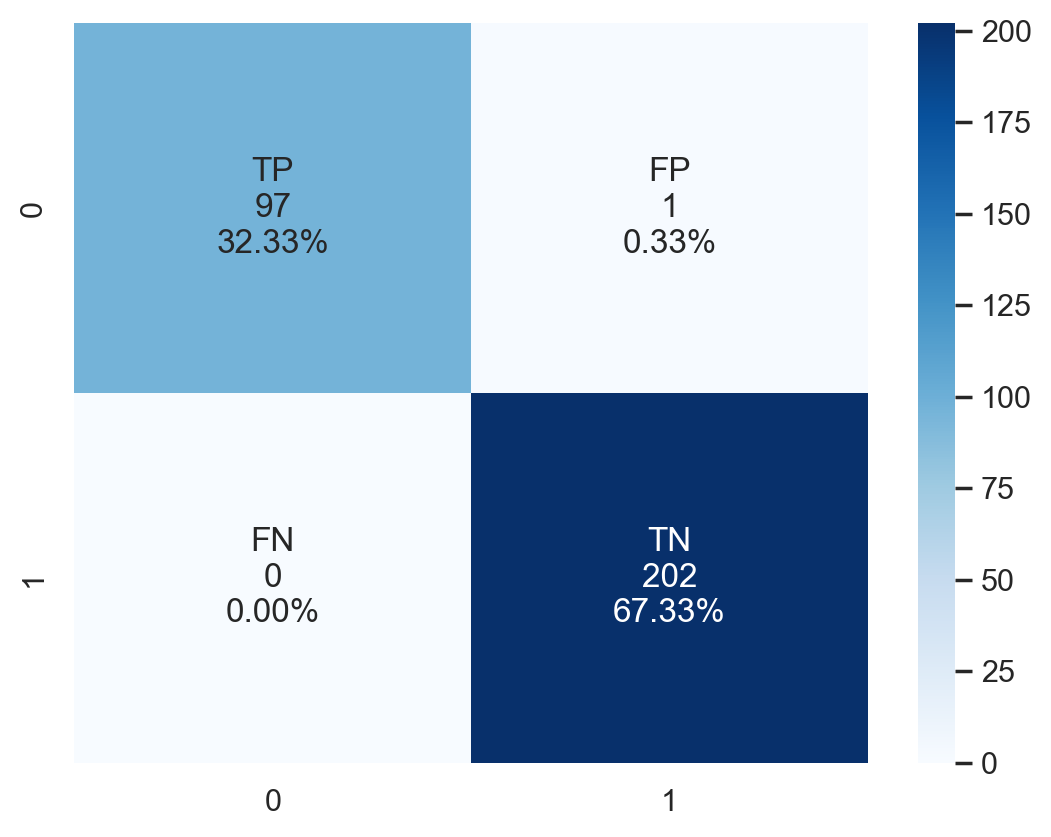

In [811]:
group_name = ['TP','FP','FN','TN']
group_counts = ["{}".format(value) for value in confu_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confu_matrix.flatten()/np.sum(confu_matrix)]

labels_reglog = [f"{v1}\n{v2}\n{v3}" for v1,v2,v3 in zip(group_name,group_counts,group_percentages)]

labels_reglog = np.asarray(labels_reglog).reshape(2,2)

sns.heatmap(confu_matrix,annot=labels_reglog, fmt='',cmap= 'Blues')  #scientific notation change : fmt = 'd'(int)

- TP = True positive      # it is true and it is predicted as true   
- FP = False positve         # it is false but it is predicted as true  
- FN = False negative        # it is true but it is predicted as false  
- TN = True negative       # it is false and it is predicted as false (guess right) 

- **Sensibilité** : Taux de positif prédit comme positif 
- **Spécificité** : Taux de négatifs prédit comme négatif

In [812]:
tp = confu_matrix[0,0]
fp = confu_matrix[0,1]
fn = confu_matrix[1,0]
tn = confu_matrix[1,1]

sensibility = tp/(tp+fn) 
specificity = tn/(tn+fp)

print("sensibility:", sensibility)
print("specificity:", specificity)

sensibility: 1.0
specificity: 0.9950738916256158


### La courbe ROC  (Receiver Operating Characteristic)
- Pour évaluer la performance d'un modèle de classification binaire 

- **roc_curve** calcule le taux de faux positifs (fpr), le taux de vrais positifs (tpr) et les seuils (thresholds) correspondants pour tracer la courbe ROC
- **auc** calcule l'aire sous la courbe ROC.  

In [813]:
# Corresponds to probabilities for the positive outcomes
y_scores = model_reglog_final.predict_proba(X_test2)[:, 1]
y_scores_noskill = [0 for _ in range(len(actual_y))]

In [814]:
sum(y_scores_noskill)

0

In [815]:
lr_auc = roc_auc_score(actual_y, y_scores)
ns_auc = roc_auc_score(actual_y, y_scores_noskill)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


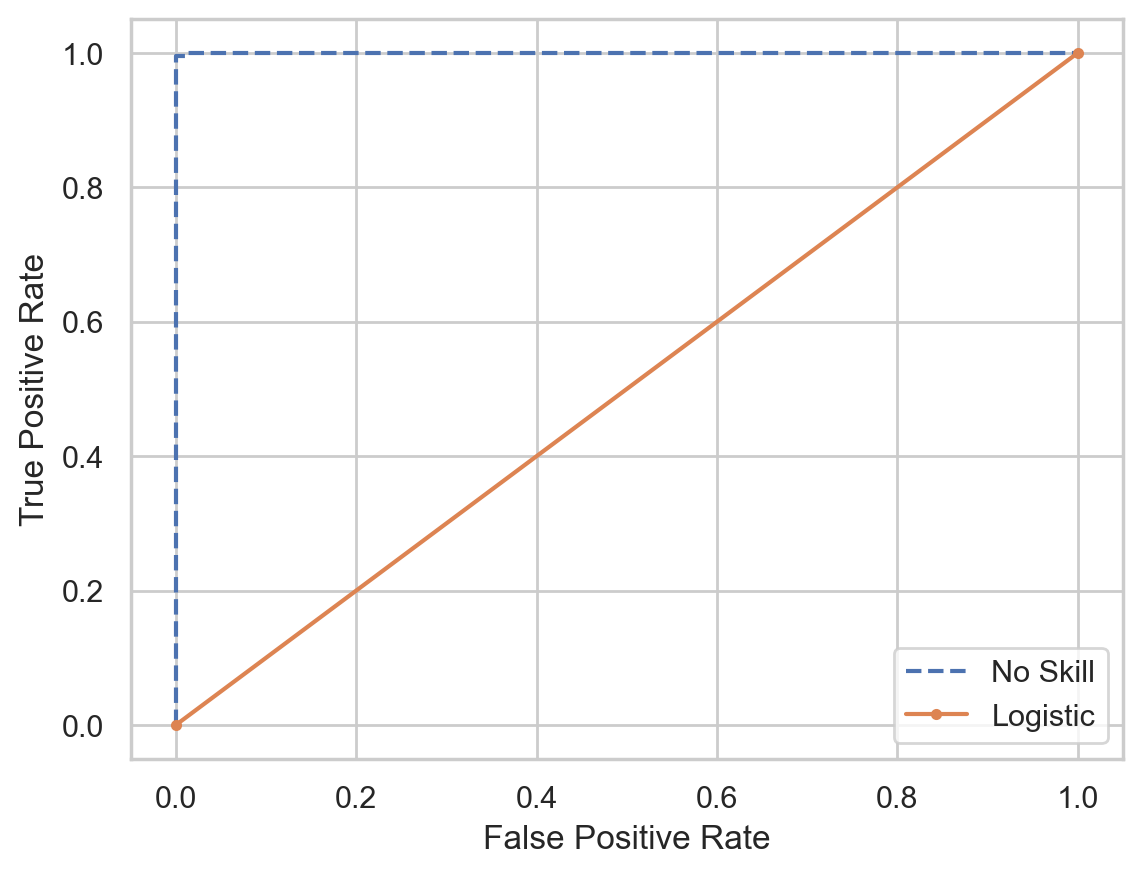

In [816]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(actual_y, y_scores)
lr_fpr, lr_tpr, _ = roc_curve(actual_y, y_scores_noskill)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Comme avec les metrics calculées plus haut, on retombe sur un modèle quasiment parfait avec une aire sous la courbe approximée à 1.

**Validation croisée (cross-validation)**

In [817]:
# Créer le nouveau modèle de régression logistique
lr = LogisticRegression()

# Validation croisée avec 5 folds
scores = cross_val_score(lr, X_reglog_final_scaled, y, cv=5)

# Scores moyens de la validation croisée
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.990 (+/- 0.012)


- Accuracy: 0.991 : cela signifie que l'on a une performance élevée avec une précision moyenne de 99,1 %.
- (+/- 0.011) : Une plage de variation de +/- 0,011. 

Puisque l'écart type est relativement faible, cela signifie que les performances de notre modèle avec validation croisée sont similaires, ce qui montre que notre modèle est relativement stable.

Pourquoi une validation croisée avec 5 folds (5 plis)? 

 - Maintenir une quantité suffisante de données pour l'entraînement tout en minimisant autant que possible le chevauchement entre l'ensemble de test et l'ensemble d'entraînement. 
 
 - 5 folds permet en général de fournir une évaluation fiable de la performance du modèle.

# Comparaison des 3 modèles

Voici les matrices de confusions obtenues en predisant les données de test avec les différents modèles.

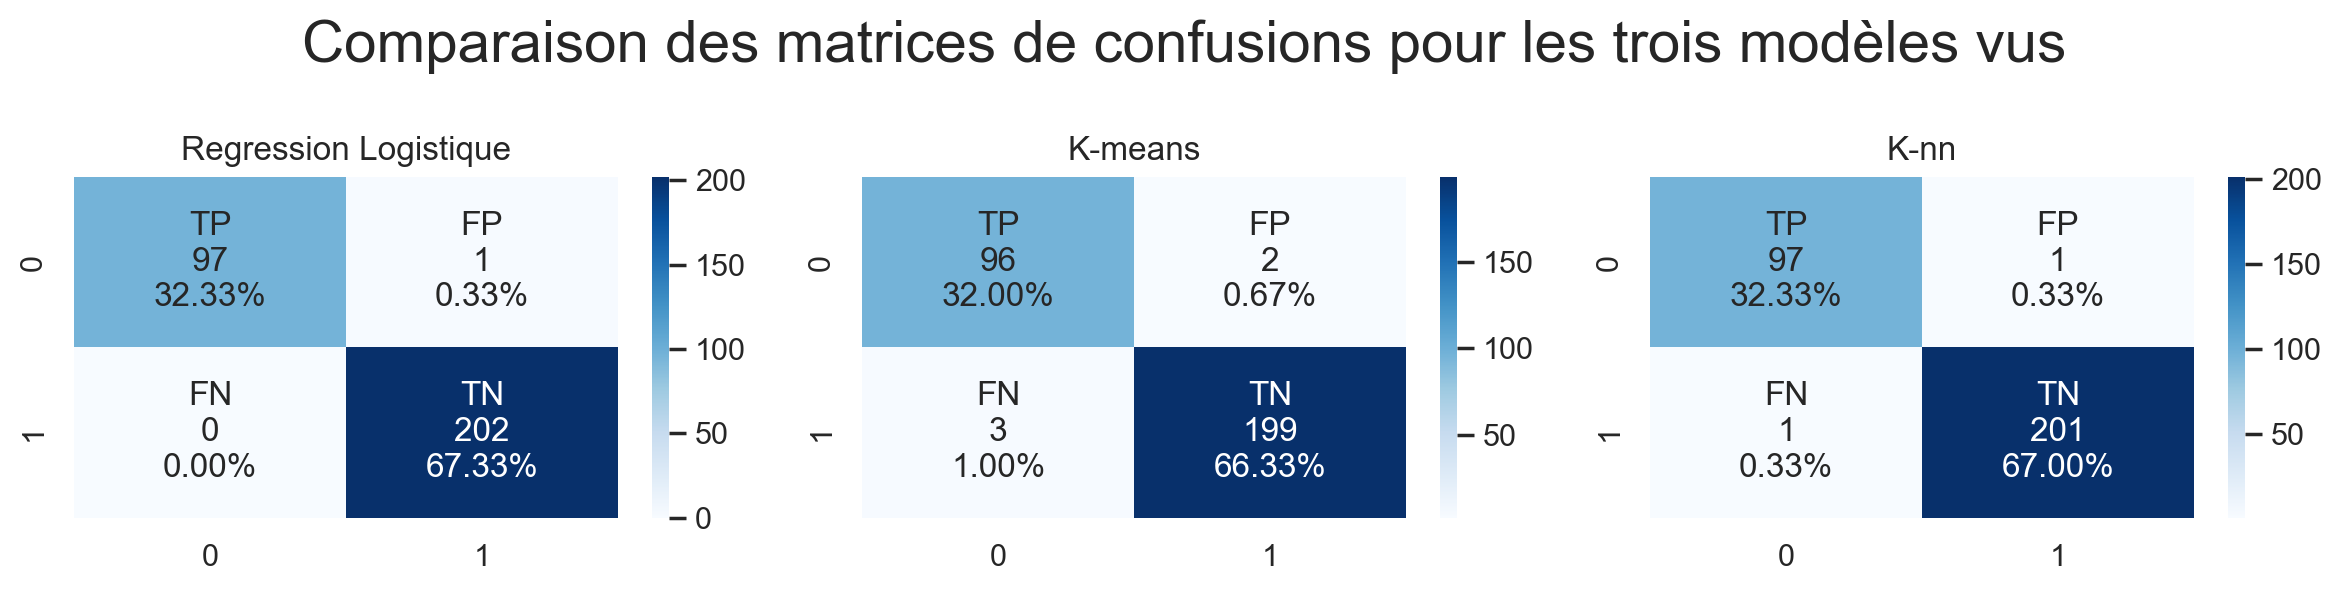

In [818]:
fig, axes = plt.subplots(ncols=3, figsize=(12,3))
fig.suptitle("Comparaison des matrices de confusions pour les trois modèles vus", size=21)

ax1, ax2, ax3 = axes

ax1.set_title("Regression Logistique")

sns.heatmap(confu_matrix,annot=labels_reglog, fmt='',cmap= 'Blues', ax = ax1)

ax2.set_title("K-means")
sns.heatmap(confu_matrix_test_km,annot=labels_km, fmt='',cmap= 'Blues', ax = ax2)  #scientific notation change : fmt = 'd'(int)

ax3.set_title("K-nn")
sns.heatmap(confu_matrix_knn,annot=labels_knn, fmt='',cmap= 'Blues', ax = ax3)  #scientific notation change : fmt = 'd'(int)
fig.tight_layout()


On sauvegarde le modèle de Regression Logistique, ainsi que le modèle de standardisation des X.
- Pour utiliser le modèle dans un autre programme.

In [819]:
import joblib
model_reglog_filename = "model_logistic_regression_final.joblib"
model_scale_filename = "model_std_scale_X_final.joblib"

joblib.dump(model_reglog_final, model_reglog_filename) # on sauvegarde le modèle et le scale.
joblib.dump(std_scale, model_scale_filename)



['model_std_scale_X_final.joblib']

### Conclusion

Nous avons lors de ce projet utilisé trois algorithmes d'apprentissage afin de prédire les faux billets.
Dans notre cas, notre modèle de prédiction basé sur la regression logistique donne des résultats plus performants. C'est donc ce modèle que nous avons retenu.

# Utilisation du modèle (test soutenance)

In [820]:
# Charger le dataset
tests=pd.read_csv('billets_test.csv',sep=',')
tests=tests.drop(["id"],axis=1)
tests

diagonal  height_left  height_right  margin_low  margin_up  length
0    172.09       103.95        103.73        4.39       3.09  113.19
1    171.52       104.17        104.03        5.27       3.16  111.82
2    171.78       103.80        103.75        3.81       3.24  113.39
3    172.02       104.08        103.99        5.57       3.30  111.10
4    171.79       104.34        104.37        5.00       3.07  111.87

In [821]:
x_features = tests[new_features_names]
x_features

height_right  margin_low  margin_up  length
0        103.73        4.39       3.09  113.19
1        104.03        5.27       3.16  111.82
2        103.75        3.81       3.24  113.39
3        103.99        5.57       3.30  111.10
4        104.37        5.00       3.07  111.87

In [822]:
# standardisation des données
std_scale = preprocessing.StandardScaler().fit(x_features)
test_x_scaled = std_scale.transform(x_features)
tests["prédiction"] = model_reglog_final.predict(test_x_scaled)

In [823]:
tests.head()

diagonal  height_left  height_right  margin_low  margin_up  length  \
0    172.09       103.95        103.73        4.39       3.09  113.19   
1    171.52       104.17        104.03        5.27       3.16  111.82   
2    171.78       103.80        103.75        3.81       3.24  113.39   
3    172.02       104.08        103.99        5.57       3.30  111.10   
4    171.79       104.34        104.37        5.00       3.07  111.87   

   prédiction  
0           1  
1           0  
2           1  
3           0  
4           0

In [824]:
# Affichage des prédictions
resultat= []
for i in tests['prédiction'] :
    if i == 1 :
        resultat.append('Vrai Billet')
        
    else :
        resultat.append('Faux Billet')

tests['prédiction_str'] = resultat

# Afficher le résultat en chiffre
print(tests['prédiction'].value_counts())

tests

0    3
1    2
Name: prédiction, dtype: int64


diagonal  height_left  height_right  margin_low  margin_up  length  \
0    172.09       103.95        103.73        4.39       3.09  113.19   
1    171.52       104.17        104.03        5.27       3.16  111.82   
2    171.78       103.80        103.75        3.81       3.24  113.39   
3    172.02       104.08        103.99        5.57       3.30  111.10   
4    171.79       104.34        104.37        5.00       3.07  111.87   

   prédiction prédiction_str  
0           1    Vrai Billet  
1           0    Faux Billet  
2           1    Vrai Billet  
3           0    Faux Billet  
4           0    Faux Billet

In [825]:
# Predict the probability of the first instance belonging to each class
probabilities = model_reglog_final.predict_proba(test_x_scaled)
probabilities

array([[6.28640755e-05, 9.99937136e-01],
       [8.81817075e-01, 1.18182925e-01],
       [4.10955236e-05, 9.99958904e-01],
       [9.99842563e-01, 1.57436799e-04],
       [5.07880245e-01, 4.92119755e-01]])

In [826]:
# Add the columns for the probability
tests["proba_faux_billet"] = probabilities[:,0]
tests["proba_vrai_billet"] = probabilities[:,1]

In [827]:
tests

diagonal  height_left  height_right  margin_low  margin_up  length  \
0    172.09       103.95        103.73        4.39       3.09  113.19   
1    171.52       104.17        104.03        5.27       3.16  111.82   
2    171.78       103.80        103.75        3.81       3.24  113.39   
3    172.02       104.08        103.99        5.57       3.30  111.10   
4    171.79       104.34        104.37        5.00       3.07  111.87   

   prédiction prédiction_str  proba_faux_billet  proba_vrai_billet  
0           1    Vrai Billet           0.000063           0.999937  
1           0    Faux Billet           0.881817           0.118183  
2           1    Vrai Billet           0.000041           0.999959  
3           0    Faux Billet           0.999843           0.000157  
4           0    Faux Billet           0.507880           0.492120